<a href="https://colab.research.google.com/github/mlbhl/Portfolio-management/blob/main/cross_sectional_predictability_231018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import os
import glob
from pathlib import Path
import requests

import yfinance as yf
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#os.getcwd()

'C:\\Users\\11120\\Documents\\Python\\code'

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Dataset

In [ ]:
start_date = '1990-01-01'
start_date_macro = '1985-01-01'
end_date = '2022-12-31'

In [ ]:
#raw = pd.read_excel('C:/Users/Byounghyo Lim/Desktop/article/manuscript/machine learning/code/all-new-multi-asset-dataset.xlsx',
#raw = pd.read_excel('/content/drive/MyDrive/dataset/all-new-multi-asset-dataset.xlsx',
#                    sheet_name='multi-asset-daily-export-us', index_col='Date')

#raw = pd.read_excel('C:/Users/11120/Documents/Python/data/ai-3-strategy.xlsx',
#                    sheet_name='Sheet2', index_col='Date')

#assets = ['us_stock','woexus_stock','em_stock','tr_bond','ig_bond','tip_bond','gold_alt','commodity_alt','reits_alt']
#assets = ['us_stock','woexus_stock','tr_bond','ig_bond','gold_alt','commodity_alt']
#assets = ['XLE','XLB','XLI','XAR','XLK','XLC','VHT','XLY','SOXX','XLU','XLF','XLP']
#dataset = raw[assets]

#dataset = dataset[start_date:end_date]
#dataset = dataset[start_date:]

In [ ]:
proxies = {'http': 'http://46.2.90.210:8080', 'https': 'http://46.2.90.210:8080'}
s = requests.Session()
s.proxies.update(proxies)

In [ ]:
#datasets = get_available_datasets(session=s)
datasets = get_available_datasets()
df_49_industry = [dataset for dataset in datasets if '49' in dataset and 'Industry' in dataset]
print(df_49_industry)

['49_Industry_Portfolios', '49_Industry_Portfolios_Wout_Div', '49_Industry_Portfolios_daily']


In [ ]:
# get 49-industry dataset from ken french website
industries = web.DataReader(df_49_industry[2],'famafrench',
                            start=start_date, end=end_date,
                            #session=s,
                           )
industries = industries[0]  # 0 == value-weighted, 1 == equal-weighted
industries = (industries/100+1).cumprod()*100  # returns to indices

dataset = industries.copy()
assets = industries.columns.to_list()

In [ ]:
# macroeconomic predictors
usrates = web.DataReader(
    ['DTB3','T10Y3M','DAAA','DBAA','VIXCLS'], 'fred',
    start=start_date_macro, end=end_date,
    #session=s,
)

uscpi = web.DataReader(
    ['CPIAUCSL'], 'fred',
    start=start_date_macro, end=end_date,
    #session=s,
)

macros = usrates.resample('M').last()
macros['TBILL'] = macros['DTB3'] - macros['DTB3'].rolling(12).mean()
macros['CREDIT'] = macros['DBAA'] - macros['DAAA']
macros.drop(['DTB3','DAAA','DBAA'], axis=1, inplace=True)

infl = uscpi.pct_change(12).shift().resample('M').last()
infl = (infl - infl.rolling(36).mean())*100
macros = macros.join(infl)

macros.rename(columns={'T10Y3M':'YC', 'VIXCLS':'VIX', 'CPIAUCSL':'UI'}, inplace=True)

In [ ]:
# aggregate cross-sectional predictors

# average pairwise correlation across assets
apc = pd.DataFrame(dataset.pct_change().rolling(21*3).corr().unstack().mean(axis=1).dropna(), columns=['CORR'])
apc = apc.resample('M').last()

# max-min momentum gap across assets
mgap = pd.DataFrame((dataset.pct_change(periods=21*12).max(axis=1)-dataset.pct_change(periods=21*12).min(axis=1)).dropna(),
                   columns=['MOMGAP'])
mgap = mgap.resample('M').last()

In [ ]:
def feature_extractor(dframe):
    dframe = dframe.round(4)

    # Momentum
    # Cross-sectional
    dframe['MOM1M'] = dframe['Close'].pct_change(periods=21).mul(100)
    dframe['MOM3M'] = dframe['Close'].pct_change(periods=21*3).mul(100)
    dframe['MOM6M'] = dframe['Close'].pct_change(periods=21*6).mul(100)
    dframe['MOM9M'] = dframe['Close'].pct_change(periods=21*9).mul(100)
    dframe['MOM1Y'] = dframe['Close'].pct_change(periods=21*12).mul(100)
    # Time-series
    #dframe['SMOM1M'] = np.where(dframe['MOM1M']>=0,1,-1)
    #dframe['SMOM3M'] = np.where(dframe['MOM3M']>=0,1,-1)
    #dframe['SMOM6M'] = np.where(dframe['MOM6M']>=0,1,-1)
    #dframe['SMOM9M'] = np.where(dframe['MOM9M']>=0,1,-1)
    #dframe['SMOM1Y'] = np.where(dframe['MOM1Y']>=0,1,-1)

    # Reversal
    # Cross-sectional
    dframe['REV1W'] = dframe['Close'].pct_change(periods=5).mul(100)
    dframe['REV2Y'] = dframe['Close'].pct_change(periods=21*24).mul(100)
    dframe['REV3Y'] = dframe['Close'].pct_change(periods=21*36).mul(100)
    dframe['REV4Y'] = dframe['Close'].pct_change(periods=21*48).mul(100)
    dframe['REV5Y'] = dframe['Close'].pct_change(periods=21*60).mul(100)
    # Time-series
    #dframe['SREV1W'] = np.where(dframe['REV1W']>=0,1,-1)
    #dframe['SREV2Y'] = np.where(dframe['REV2Y']>=0,1,-1)
    #dframe['SREV3Y'] = np.where(dframe['REV3Y']>=0,1,-1)
    #dframe['SREV4Y'] = np.where(dframe['REV4Y']>=0,1,-1)
    #dframe['SREV5Y'] = np.where(dframe['REV5Y']>=0,1,-1)

    # 52-week high momentum
    dframe['PTH'] = dframe['Close'].div(dframe['Close'].rolling(21*12).max()).sub(1).mul(100)
    dframe['HTP'] = dframe['MOM1Y'] - dframe['PTH']

    # Salient return
    dframe['MAX'] = dframe['Close'].pct_change().rolling(21).max().mul(100)
    dframe['MIN'] = dframe['Close'].pct_change().rolling(21).min().mul(100)

    # Volatility
    dframe['VOL1M'] = dframe['Close'].pct_change().rolling(21).std().mul(np.sqrt(21))
    dframe['VOL2Y'] = dframe['Close'].pct_change().rolling(21*24).std().mul(np.sqrt(21))

    dframe = dframe.resample('M').last()

    dframe['RETURN'] = dframe['Close'].pct_change()
    dframe = dframe.drop(['Close'], axis=1)

    return dframe

In [ ]:
asset_feature_dict = {}
for asset in assets:
    dframe = dataset[[asset]].rename(columns={asset:'Close'})
    dframe_feature = feature_extractor(dframe)
    dframe_feature.dropna(axis=0, inplace=True)

    dframe_feature = dframe_feature.join(apc)
    dframe_feature = dframe_feature.join(mgap)
    dframe_feature = dframe_feature.join(macros)

    dframe_feature['RETURN_T+1'] = dframe_feature['RETURN'].shift(-1) # the last data point is for final estimation
    dframe_feature = dframe_feature.drop(['RETURN'], axis=1)
    asset_feature_dict[asset] = dframe_feature

In [ ]:
panel = pd.concat([frame.round(4) for frame in asset_feature_dict.values()])
panel.fillna(0, inplace=True)
#panel.to_csv('/content/drive/MyDrive/dataset/cs/panel/panel.csv')
#panel.to_csv('C:/Users/11120/Documents/Python/data/cs/panel/panel.csv')

### Utils

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, quantile_transform

def scale_sort(df, feature_cols, scaler='MinMax'):

    for date in df.index.unique():
        for feature in feature_cols:
            x = df.loc[date, feature].values.reshape(-1,1)
            if scaler == 'MinMax':
                df.loc[date, feature] = (MinMaxScaler().fit_transform(x)).ravel()
            elif scaler == 'Standard':
                df.loc[date, feature] = (StandardScaler().fit_transform(x)).ravel()
            elif scaler == 'RankNorm':
                n_quantiles = len(x)
                df.loc[date, feature] = (quantile_transform(x, n_quantiles=n_quantiles, copy=True)*2-1).ravel()

    df.sort_index(inplace=True, kind='stable') # 'stable'로 해야 순서 안바뀜

    return "Done."

In [ ]:
def pass_sort(df):

    df.sort_index(inplace=True, kind='stable') # 'stable'로 해야 순서 안바뀜

    return "Done."

In [ ]:
def holdout_cv(X_train, n_valid):
    # frequency should be 'M'
    end_year = pd.to_datetime(X_train.index[-1]).year

    start_year = end_year - n_valid + 1

    valid_start_date = datetime.date(start_year,1,31).strftime(format="%Y-%m-%d")
    valid_end_date = datetime.date(end_year,12,31).strftime(format="%Y-%m-%d")

    valid_range = X_train.index.slice_locs(start=valid_start_date, end=valid_end_date)

    train_idx = np.array(list(range(0, valid_range[0])), dtype=int)
    valid_idx = np.array(list(range(valid_range[0], valid_range[1])), dtype=int)

    yield (train_idx, valid_idx)

In [ ]:
def R2(y_true, y_pred):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = (y_true**2).sum(axis=0, dtype=np.float64)
    return 1 - (numerator/denominator)

In [ ]:
def CER(pfret, bmret, riskaversion):
    cer_pf = pfret.mean()*12 - 0.5*riskaversion*(pfret.var()*12)
    cer_bm = bmret.mean()*12 - 0.5*riskaversion*(bmret.var()*12)
    cer_gain = cer_pf - cer_bm
    return cer_gain

In [ ]:
def PORT(y_pred, riskaversion, minwgt, maxwgt, init_date):
    # y_pred <- (-1,n_assets)
    oosexpret = y_pred.copy()
    dfpass = panel.copy()
    pass_sort(df=dfpass)
    dfpass_ = dfpass[:-n_assets]
    oosvol = dfpass_.loc[init_date:]['VOL2Y'].values.reshape(-1,n_assets) # T

    #pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
    pfweight = pd.DataFrame((oosexpret).clip(minwgt,maxwgt))
    pfweight[pfweight.sum(axis=1)==0.] = 1/n_assets  # minwgt==0인 경우만
    pfweight[pfweight>0] = pfweight[pfweight>0].div(pfweight[pfweight>0].sum(axis=1), axis=0) # T+1
    pfweight[pfweight<0] = pfweight[pfweight<0].div(pfweight[pfweight<0].sum(axis=1), axis=0).mul(-1) # T+1
    pfweight = pfweight.values

    oosret = dfpass_.loc[init_date:]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
    pfret = (pfweight * oosret).sum(axis=1)
    bmret = (oosret / n_assets).sum(axis=1)

    cer = CER(pfret, bmret, riskaversion)
    turnover = (abs(pfweight[1:] - np.roll(pfweight,shift=1,axis=0)[1:]).sum(axis=1)/2).mean()
    idx = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
    idx.index = pd.date_range(init_date, dfpass_.index[-1], freq='M')
    idx.columns = ['model','bm']

    return cer, turnover, idx, pfweight

In [ ]:
def ts_plot(data):
    col = data.columns
    fig = plt.figure(figsize = (12, 6))
    gs = fig.add_gridspec(nrows = 1, ncols = 1)
    ax = fig.add_subplot(gs[0])
    for i in range(len(col)):
        ax.plot(data[col[i]], label=col[i])
    ax.set_ylabel('(pt)', rotation = 0)
    ax.yaxis.set_label_coords(-0.02, 1.02)
    ax.legend(loc = 'upper left')

In [ ]:
def stacked_plot(data):
    x = data.index
    cols = data.columns
    y = {}
    for col in cols:
        y[col] = data[col].values
    y = pd.DataFrame(y).T
    labels = list(data.columns)
    fig = plt.figure(figsize = (12, 6))
    gs = fig.add_gridspec(nrows = 1, ncols = 1)
    ax = fig.add_subplot(gs[0])
    ax.stackplot(x, y, labels=labels)
    ax.set_ylabel('(%)', rotation = 0)
    ax.yaxis.set_label_coords(-0.02, 1.02)
    ax.legend(loc = 'upper left')

### Models

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from scipy.stats import loguniform
from itertools import product

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, ReLU, LeakyReLU, ELU
from tensorflow.keras.layers import Dot, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K

In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
class myLoss(Loss):
    def __init__(self,mu,sigma):
       super().__init__()
       self.mu = mu
       self.sigma = sigma
    def call(self,y_true,y_pred):
        mse_loss = tf.keras.losses.MeanSquaredError()
        mse_loss = mse_loss(y_true, y_pred)
        kl_loss = 1 + self.sigma - tf.square(self.mu) - tf.exp(self.sigma)
        kl_loss = -0.5 * tf.reduce_sum(kl_loss)
        return mse_loss + kl_loss

In [ ]:
x = tf.constant([[1., 2.], [3., 4.]])
y = tf.constant([[1.5, 1.5], [3.5, 4.9]])

In [ ]:
tf.exp(x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 2.7182817,  7.389056 ],
       [20.085537 , 54.59815  ]], dtype=float32)>

In [ ]:
mse_loss = tf.keras.losses.MeanSquaredError()
mse_loss = mse_loss(x, y)
print(mse_loss)

tf.Tensor(0.39000005, shape=(), dtype=float32)


In [ ]:
kl_loss = 1 + x - tf.square(y) - tf.exp(x)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=1)
print(kl_loss)

tf.Tensor([ 4.803669 50.97184 ], shape=(2,), dtype=float32)


In [ ]:
mse_loss + kl_loss

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 5.193669, 51.36184 ], dtype=float32)>

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
def CAE(h_units=32, k_units=16, n_factors=3, lr=0.001, reg=0.01, dropout=0.1):
    # input layer
    input_feature = Input(shape=(n_assets,n_features))
    input_target = Input((n_assets,))

    # factor network
    h = Flatten()(input_feature)
    h = Dense(h_units, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1(reg))(h)
    h = Dropout(dropout)(h, training=True)
    h = BatchNormalization()(h)
    h = Dense(h_units, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1(reg))(h)
    h = Dropout(dropout)(h, training=True)
    h = BatchNormalization()(h)
    h = Dense(n_assets * n_factors)(h)
    output_feature = Reshape((n_assets,n_factors))(h)

    # target network
    #output_target = Dense(n_factors)(input_target)
    k = Dense(k_units, kernel_regularizer=L1(reg))(input_target)
    k = Dropout(dropout)(k, training=True)
    k = BatchNormalization()(k)
    k = LeakyReLU()(k)
    mu = Dense(n_factors)(k)
    sigma = Dense(n_factors)(k)

    def sample_z(args):
        mu, sigma = args
        batch     = tf.shape(mu)[0]
        dim       = tf.shape(mu)[1]
        epsilon   = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * sigma) * epsilon

    output_target = Lambda(sample_z, output_shape=(n_factors,))([mu,sigma])

    # define encoders
    feature_encoder = Model(inputs=input_feature, outputs=output_feature)
    target_encoder = Model(inputs=input_target, outputs=[mu,sigma,output_target])

    # autoencoder output
    output = Dot(axes=(2,1))([feature_encoder(input_feature), target_encoder(input_target)[2]])

    # define autoencoder model
    autoencoder = Model(inputs=[input_feature, input_target], outputs=output)

    #def myloss(mu,sigma):
    #    def kl_reconstruction_loss(y_true, y_pred):
    #        # Reconstruction loss
    #        reconstruction_loss = tf.keras.losses.MeanSquaredError()
    #        reconstruction_loss = reconstruction_loss(y_true, y_pred)
    #        # KL divergence loss
    #        kl_loss = 1 + sigma - tf.square(mu) - tf.exp(sigma)
    #        kl_loss = tf.reduce_sum(kl_loss)
    #        kl_loss *= -0.5
    #        # Total loss = 50% rec + 50% KL divergence loss
    #        return tf.reduce_mean(reconstruction_loss + kl_loss)
    #    return kl_reconstruction_loss

    # optimizer
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    autoencoder.compile(optimizer=optimizer,
                        loss=myLoss(mu,sigma),
                        )

    return autoencoder, feature_encoder, target_encoder

In [ ]:
def CAE(h_units=32, k_units=16, n_factors=3, lr=0.001, reg=0.01, dropout=0.1):
    # input layer
    input_feature = Input(shape=(n_assets,n_features))
    input_target = Input((n_assets,))

    # factor network
    h = Flatten()(input_feature)
    h = Dense(h_units, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1(reg))(h)
    h = Dropout(dropout)(h, training=True)
    h = BatchNormalization()(h)
    h = Dense(h_units, activation='elu', kernel_initializer='he_normal', kernel_regularizer=L1(reg))(h)
    h = Dropout(dropout)(h, training=True)
    h = BatchNormalization()(h)
    h = Dense(n_assets * n_factors)(h)
    output_feature = Reshape((n_assets,n_factors))(h)

    # target network
    output_target = Dense(n_factors)(input_target)
    #k = Dense(k_units, kernel_regularizer=L1(reg))(input_target)
    #k = BatchNormalization()(k)
    #k = LeakyReLU()(k)
    #output_target = Dense(n_factors)(k)

    # output layer
    output = Dot(axes=(2,1))([output_feature, output_target])

    # define model
    autoencoder = Model(inputs=[input_feature, input_target], outputs=output)
    feature_encoder = Model(inputs=input_feature, outputs=output_feature)
    target_encoder = Model(inputs=input_target, outputs=output_target)

    # optimizer
    optimizer = Adam(learning_rate=lr)
    autoencoder.compile(optimizer=optimizer,
                        loss=tf.keras.losses.MeanSquaredError(),
                        #metrics=[tf.keras.metrics.MeanSquaredError()]
                       )

    return autoencoder, feature_encoder, target_encoder

In [ ]:
def testCAE(X_train, y_train, X_test, y_test, roll_window=12):
    y_total = autoencoder.predict([X_test.values.reshape(-1,n_assets,n_features), y_test.values.reshape(-1,n_assets)])
    total_r2 = R2(y_test.values, y_total.ravel())

    feature_train_encoded = feature_encoder.predict(X_train.values.reshape(-1,n_assets,n_features))
    #target_train_encoded = target_encoder.predict(y_train.values.reshape(-1,n_assets))
    target_train_encoded = target_encoder.predict(y_train.values.reshape(-1,n_assets))[2]
    feature_test_encoded = feature_encoder.predict(X_test.values.reshape(-1,n_assets,n_features))
    #target_test_encoded = target_encoder.predict(y_test.values.reshape(-1,n_assets))
    target_test_encoded = target_encoder.predict(y_test.values.reshape(-1,n_assets))[2]

    target_encoded = np.append(target_train_encoded, target_test_encoded, axis=0)
    rolling_mean_target_encoded = pd.DataFrame(target_encoded).rolling(roll_window, min_periods=1).mean().to_numpy()
    #prevailing_mean_target_encoded = np.cumsum(target_encoded, axis=0) / np.arange(1,len(target_encoded)+1).reshape(-1,1)
    rolling_mean_target_train_encoded = rolling_mean_target_encoded[:len(target_train_encoded)]
    rolling_mean_target_test_encoded = rolling_mean_target_encoded[len(target_train_encoded):]

    y_pred = []
    for t in range(len(feature_test_encoded)):
        B = feature_test_encoded[t]
        if t == 0:
            F = rolling_mean_target_train_encoded[-1]
        else:
            F = rolling_mean_target_test_encoded[t-1]
        y_pred_ = np.dot(B,F)
        y_pred.append(y_pred_)
    y_pred = np.array(y_pred).ravel()
    pred_r2 = R2(y_test.values, y_pred)

    F_last = rolling_mean_target_encoded[-1]

    return total_r2, pred_r2, y_pred, F_last

In [ ]:
#def predictCAE(target_train_encoded, feature_test_encoded, target_test_encoded, y_test, feature_last_encoded):
#    oosr2, y_pred, rolling_mean_target_encoded = testCAE(target_train_encoded, feature_test_encoded, target_test_encoded, y_test)
#    B = feature_last_encoded[0]
#    F = rolling_mean_target_encoded[-1]
#    y_last = np.dot(B,F)
#    return y_last

### Test

In [ ]:
#data = pd.read_csv('C:/Users/11120/Documents/Python/data/cs/panel/panel.csv', index_col='Date')
#data = pd.read_csv('/content/drive/MyDrive/dataset/cs/panel/panel.csv', index_col='Date')
df = panel.copy()

In [ ]:
#scale_feature_cols = [
#    'MOM1M','MOM3M','MOM6M','MOM9M','MOM1Y',
#    'REV1W','REV2Y','REV3Y','REV4Y','REV5Y',
#    'PTH','HTP','MAX','MIN','VOL1M'
#]

#scale_sort(df=df, feature_cols=scale_feature_cols, scaler='RankNorm')

In [ ]:
# 더 나음
pass_sort(df=df)

'Done.'

In [ ]:
n_assets = len(assets)
df_ = df[:-n_assets]

X_full, y_full = df_.drop(['VOL2Y','RETURN_T+1'], axis=1), df_['RETURN_T+1']
X_last = df[-n_assets:].drop(['VOL2Y','RETURN_T+1'], axis=1)

X_full.shape, y_full.shape, X_last.shape

((16464, 22), (16464,), (49, 22))

In [ ]:
X_last.columns

Index(['MOM1M', 'MOM3M', 'MOM6M', 'MOM9M', 'MOM1Y', 'REV1W', 'REV2Y', 'REV3Y',
       'REV4Y', 'REV5Y', 'PTH', 'HTP', 'MAX', 'MIN', 'VOL1M', 'CORR', 'MOMGAP',
       'YC', 'VIX', 'TBILL', 'CREDIT', 'UI'],
      dtype='object')

In [ ]:
variables = X_last.columns.to_list()
n_assets = len(assets)
n_features = len(variables)
n_valid = 4
n_test = 1
init_test_year = '2012'
init_test_date = datetime.date(int(init_test_year),1,1).strftime(format="%Y-%m-%d")
last_test_date = X_full.index[-1]
roll_window = 18

factor_opts = [5]
h_unit_opts = [32]
k_unit_opts = [16]
lr_opts = [0.001]
reg_opts = [0.01]
dropout_opts = [0.1]
batch_opts = [64]

param_grid = list(product(h_unit_opts, k_unit_opts, factor_opts, lr_opts, reg_opts, dropout_opts, batch_opts))
logdir = 'logs/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tfboard_cb = TensorBoard(log_dir=logdir)
cb = EarlyStopping(patience=30, restore_best_weights=True)

In [ ]:
test_years = pd.to_datetime(X_full.loc[init_test_year:].resample('Y').last().index).year.to_list()
n_randoms = 1

final_total_r2 = pd.DataFrame(0., index=test_years, columns=['total_r2'])
final_pred_r2 = pd.DataFrame(0., index=test_years, columns=['pred_r2'])
final_y_test = pd.DataFrame(0., index=pd.date_range(init_test_date,last_test_date, freq='M'), columns=assets)
final_y_pred = pd.DataFrame(0., index=pd.date_range(init_test_date,last_test_date, freq='M'), columns=assets)
y_pred_last = []

for random in range(n_randoms):
    cum_total_r2 = []
    cum_pred_r2 = []
    cum_y_test = []
    cum_y_pred = []

    for year in test_years:
        train_year = str(year-1)
        test_start_year = str(year)
        test_end_year = str(year+n_test-1)  # n_test==1인 경우만 성립, 아니라면 for문 바꿔야 함
        X_train = X_full.loc[:train_year]
        y_train = y_full.loc[:train_year]
        X_test  = X_full.loc[test_start_year:test_end_year]
        y_test  = y_full.loc[test_start_year:test_end_year]

        for (train_idx, valid_idx) in holdout_cv(X_train, n_valid):
            X1_train = X_train.iloc[train_idx].values.reshape(-1,n_assets,n_features)
            X2_train = y_train.iloc[train_idx].values.reshape(-1,n_assets)
            X1_valid = X_train.iloc[valid_idx].values.reshape(-1,n_assets,n_features)
            X2_valid = y_train.iloc[valid_idx].values.reshape(-1,n_assets)

        scores = []
        for h_units, k_units, n_factors, lr, reg, dropout, batch in param_grid:
            autoencoder, feature_encoder, target_encoder = CAE(h_units=h_units, k_units=k_units, n_factors=n_factors,
                                                               lr=lr, reg=reg, dropout=dropout)
            autoencoder.fit([X1_train,X2_train], X2_train, epochs=200, batch_size=batch, verbose=2,
                            validation_data=([X1_valid,X2_valid], X2_valid), callbacks=[cb])

            mse = autoencoder.evaluate([X1_valid,X2_valid], X2_valid)#[0]  # 0=loss, 1~=metrics, None=no-metric
            scores.append([h_units, k_units, n_factors, lr, reg, dropout, batch, mse])

        scores = pd.DataFrame(scores, columns=['h_units','k_units','n_factors','lr','reg','dropout','batch','mse'])
        scores.sort_values('mse', ascending=True, inplace=True)

        optimized_h_units = int(scores.iloc[0]['h_units'])
        optimized_k_units = int(scores.iloc[0]['k_units'])
        optimized_n_factors = int(scores.iloc[0]['n_factors'])
        optimized_lr = scores.iloc[0]['lr']
        optimized_reg = scores.iloc[0]['reg']
        optimized_dropout = scores.iloc[0]['dropout']
        optimized_batch = int(scores.iloc[0]['batch'])

        autoencoder, feature_encoder, target_encoder = CAE(h_units=optimized_h_units, k_units=optimized_k_units, n_factors=optimized_n_factors,
                                                           lr=optimized_lr, reg=optimized_reg, dropout=optimized_dropout)
        autoencoder.fit([X1_train,X2_train], X2_train, epochs=200, batch_size=batch, verbose=2,
                        validation_data=([X1_valid,X2_valid], X2_valid), callbacks=[cb])

        total_r2, pred_r2, y_pred, F_last = testCAE(X_train, y_train, X_test, y_test, roll_window=roll_window)
        cum_total_r2.append(total_r2)
        cum_pred_r2.append(pred_r2)
        cum_y_test.append(y_test.values)
        cum_y_pred.append(y_pred)

    final_total_r2 += pd.DataFrame(cum_total_r2, index=test_years, columns=['total_r2'])
    final_pred_r2 += pd.DataFrame(cum_pred_r2, index=test_years, columns=['pred_r2'])
    final_y_test += pd.DataFrame(pd.DataFrame(cum_y_test).values.reshape(-1,n_assets)[:-(12-last_test_date.month)], index=pd.date_range(init_test_date,last_test_date, freq='M'), columns=assets)
    final_y_pred += pd.DataFrame(pd.DataFrame(cum_y_pred).values.reshape(-1,n_assets)[:-(12-last_test_date.month)], index=pd.date_range(init_test_date,last_test_date, freq='M'), columns=assets)

    B_last = feature_encoder.predict(X_last.values.reshape(-1,n_assets,n_features))
    y_pred_last_ = np.dot(B_last,F_last)
    y_pred_last.append(y_pred_last_)

final_total_r2 /= n_randoms
final_pred_r2 /= n_randoms
final_y_test /= n_randoms
final_y_pred /= n_randoms

y_pred_last = pd.DataFrame(np.array(y_pred_last).reshape(-1,n_assets), columns=assets)

Train on 157 samples, validate on 48 samples
Epoch 1/200
157/157 - 17s - loss: 160.1993 - val_loss: 80.8995 - 17s/epoch - 106ms/sample
Epoch 2/200
157/157 - 0s - loss: 135.1906 - val_loss: 51.2152 - 38ms/epoch - 240us/sample
Epoch 3/200
157/157 - 0s - loss: 119.8586 - val_loss: 29.7031 - 35ms/epoch - 220us/sample
Epoch 4/200
157/157 - 0s - loss: 112.8129 - val_loss: 25.2824 - 40ms/epoch - 254us/sample
Epoch 5/200
157/157 - 0s - loss: 106.3983 - val_loss: 21.7057 - 40ms/epoch - 253us/sample
Epoch 6/200
157/157 - 0s - loss: 99.9925 - val_loss: 19.1644 - 38ms/epoch - 245us/sample
Epoch 7/200
157/157 - 0s - loss: 94.4805 - val_loss: 21.9675 - 35ms/epoch - 222us/sample
Epoch 8/200
157/157 - 0s - loss: 92.1120 - val_loss: 16.8545 - 38ms/epoch - 243us/sample
Epoch 9/200
157/157 - 0s - loss: 83.3218 - val_loss: 18.3247 - 29ms/epoch - 187us/sample
Epoch 10/200
157/157 - 0s - loss: 78.2029 - val_loss: 17.7709 - 31ms/epoch - 199us/sample
Epoch 11/200
157/157 - 0s - loss: 72.5416 - val_loss: 16.14

In [ ]:
R2(final_y_test.values.ravel()[:-n_assets], final_y_pred.values.ravel()[:-n_assets])

-3.5455670097744996

In [ ]:
riskaversion = 3
minwgt = 0.
maxwgt = 1.
init_date = final_y_pred.index[0]
cer, turnover, idx, pfweight = PORT(final_y_pred.values, riskaversion, minwgt, maxwgt, init_date)

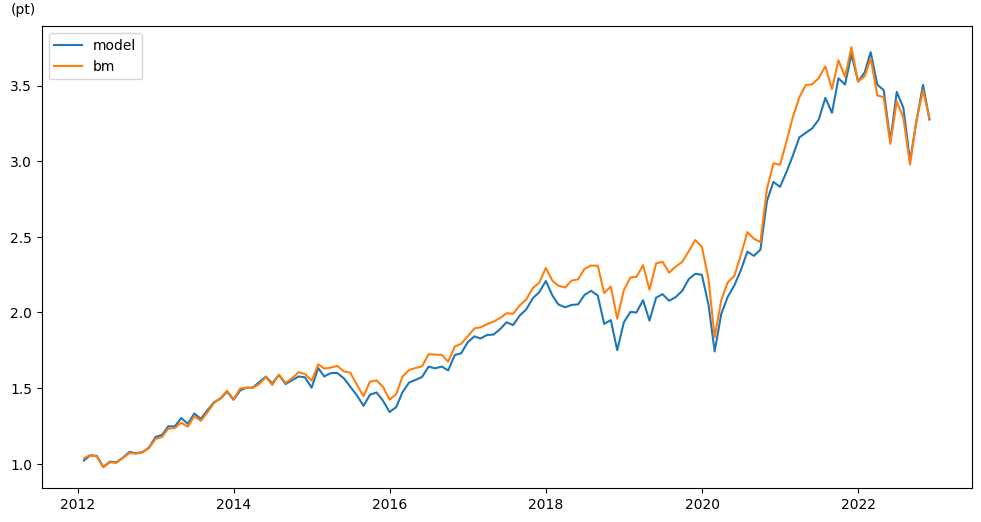

In [ ]:
ts_plot(idx)

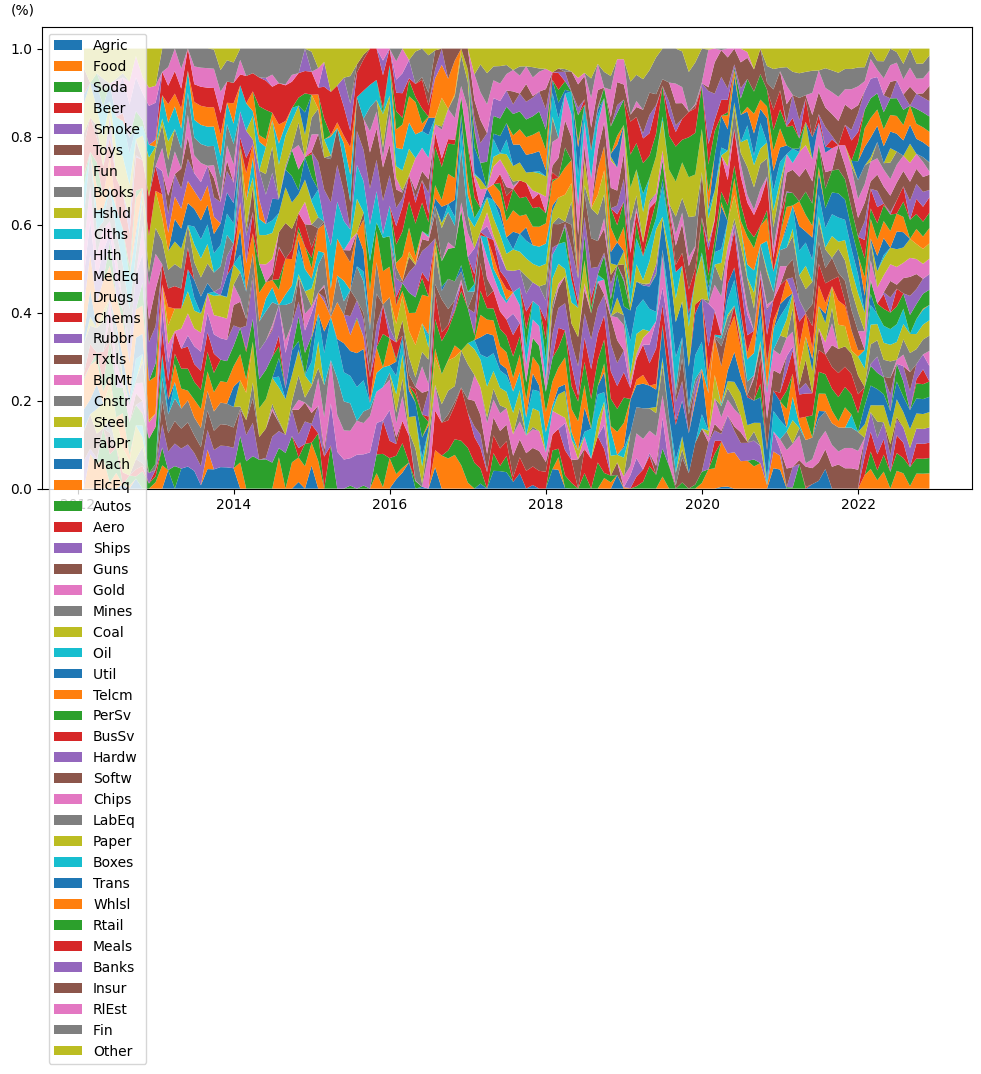

In [ ]:
stacked_plot(pd.DataFrame(pfweight, index=pd.date_range(init_test_date,last_test_date,freq='M'), columns=assets))

In [ ]:
y_pred_last.mean(axis=0)

Agric    0.042495
Food    -0.072712
Soda     0.001481
Beer     0.011705
Smoke    0.076733
Toys    -0.046567
Fun      0.030922
Books    0.141354
Hshld    0.098435
Clths    0.179353
Hlth    -0.006064
MedEq    0.137370
Drugs    0.012718
Chems    0.130159
Rubbr    0.109815
Txtls   -0.104400
BldMt    0.018261
Cnstr   -0.077402
Steel    0.095011
FabPr   -0.089762
Mach    -0.111951
ElcEq   -0.105255
Autos   -0.029515
Aero    -0.021765
Ships    0.123512
Guns     0.032982
Gold    -0.071094
Mines    0.006648
Coal    -0.061705
Oil     -0.032726
Util     0.021570
Telcm   -0.014821
PerSv    0.086784
BusSv    0.025405
Hardw    0.140132
Softw   -0.039758
Chips   -0.005332
LabEq   -0.121150
Paper   -0.151840
Boxes   -0.028126
Trans    0.217497
Whlsl   -0.049432
Rtail    0.167295
Meals    0.045939
Banks    0.059758
Insur    0.113273
RlEst   -0.004009
Fin     -0.186614
Other   -0.179826
dtype: float64

In [ ]:
turnover

0.34482767934102876

In [ ]:
idx.pct_change().mean()*12

model    0.123804
bm       0.119661
dtype: float64

In [ ]:
idx.pct_change().mean() / idx.pct_change().std() * np.sqrt(12)

model    0.77714
bm       0.75505
dtype: float64

In [ ]:
naive_mean = DummyRegressor(strategy='mean')
naive_mean.fit(X_full.values, y_full.values)
R2(y_test.values, naive_mean.predict(X_test.values))

0.016716440843153157

In [ ]:
scores = []
for h_units, k_units, n_factors, lr, reg, dropout, batch in param_grid:

    autoencoder, feature_encoder, target_encoder = CAE(h_units=h_units, k_units=k_units, n_factors=n_factors, lr=lr, reg=reg, dropout=dropout)

    for fold, (train_idx, test_idx) in enumerate(ts_cv(X_train, n_test=3, test_window=3)):
        X1_train = X_train.iloc[train_idx].values.reshape(-1,n_assets,n_features)
        X2_train = y_train.iloc[train_idx].values.reshape(-1,n_assets)
        X1_test = X_train.iloc[test_idx].values.reshape(-1,n_assets,n_features)
        X2_test = y_train.iloc[test_idx].values.reshape(-1,n_assets)

        autoencoder.fit([X1_train, X2_train], X2_train, epochs=250, batch_size=batch, verbose=2,
                        validation_data=([X1_test,X2_test], X2_test), callbacks=[cb])

    feature_train_encoded = feature_encoder.predict(X_train.values.reshape(-1,n_assets,n_features))
    target_train_encoded = target_encoder.predict(y_train.values.reshape(-1,n_assets))
    feature_test_encoded = feature_encoder.predict(X_test.values.reshape(-1,n_assets,n_features))
    target_test_encoded = target_encoder.predict(y_test.values.reshape(-1,n_assets))

    isr2 = validCAE(feature_train_encoded, target_train_encoded, y_train)[0]
    oosr2 = testCAE(feature_train_encoded, target_train_encoded, feature_test_encoded, target_test_encoded, y_test)[0]
    scores.append([h_units, k_units, n_factors, lr, reg, batch, isr2, oosr2])

scores = pd.DataFrame(scores, columns=['h_units','k_units','n_factors','lr','reg','batch','isR2','oosR2'])

In [ ]:
scores.sort_values('oosR2', ascending=False)

In [ ]:
#scores.sort_values('isR2', ascending=False)[:20]

In [ ]:
#scores.sort_values('oosR2', ascending=False)[:20]

In [ ]:
# Final CAE model
h_units = 16
k_units = 16
n_factors = 3
lr = 0.001
reg = 0.01
dropout = 0.1
batch_size = 32

autoencoder, feature_encoder, target_encoder = CAE(h_units=h_units, k_units=k_units, n_factors=n_factors, lr=lr, reg=reg, dropout=dropout)

for fold, (train_idx, test_idx) in enumerate(holdout_cv(X_train, n_valid=3)):
    X1_train = X_train.iloc[train_idx].values.reshape(-1,n_assets,n_features)
    X2_train = y_train.iloc[train_idx].values.reshape(-1,n_assets)
    X1_test = X_train.iloc[test_idx].values.reshape(-1,n_assets,n_features)
    X2_test = y_train.iloc[test_idx].values.reshape(-1,n_assets)

    autoencoder.fit([X1_train, X2_train], X2_train, epochs=250, batch_size=batch_size, verbose=0,
                    validation_data=([X1_test,X2_test], X2_test), callbacks=[cb])

feature_train_encoded = feature_encoder.predict(X_train.values.reshape(-1,n_assets,n_features))
target_train_encoded = target_encoder.predict(y_train.values.reshape(-1,n_assets))
feature_test_encoded = feature_encoder.predict(X_test.values.reshape(-1,n_assets,n_features))
target_test_encoded = target_encoder.predict(y_test.values.reshape(-1,n_assets))
feature_last_encoded = feature_encoder.predict(X_last.values.reshape(-1,n_assets,n_features))

NameError: ignored

In [ ]:
MeanSquaredError, MeanAbsoluteError, MeanSquaredLogarithmicError, CosineSimilarity

In [ ]:
import os
import random

SEED=2
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
n_assets = len(assets)
df_ = df[:-n_assets]
train = df_.loc[:'2018-12-31']
test = df_.loc['2019-01-31':]

X_train, y_train = train.drop(['VOL2Y','RETURN_T+1'], axis=1), train['RETURN_T+1']
X_test, y_test = test.drop(['VOL2Y','RETURN_T+1'], axis=1), test['RETURN_T+1']
X_last = df[-n_assets:].drop(['VOL2Y','RETURN_T+1'], axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_last.shape

((1728, 19), (1728,), (282, 19), (282,), (6, 19))

In [ ]:
# Final CAE model
h_units = 16
k_units = 16
n_factors = 2
lr = 0.001
reg = 0.01
dropout = 0.1
batch_size = 32

tf.random.set_seed(SEED)
autoencoder, feature_encoder, target_encoder = CAE(h_units=h_units, k_units=k_units, n_factors=n_factors, lr=lr, reg=reg, dropout=dropout)

In [ ]:
feature_train_encoded = feature_encoder.predict(X_train.values.reshape(-1,n_assets,n_features))
target_train_encoded = target_encoder.predict(y_train.values.reshape(-1,n_assets))
target_train_autoencoded = autoencoder.predict([X_train.values.reshape(-1,n_assets,n_features), y_train.values.reshape(-1,n_assets)])

9/9 [==============================] - 0s 2ms/step


In [ ]:
feature_train_encoded.shape, target_train_encoded.shape, target_train_autoencoded.shape, y_train.values.reshape(-1,n_assets).shape

((288, 6, 2), (288, 2), (288, 6), (288, 6))

In [ ]:
np.dot(feature_train_encoded[22],target_train_encoded[22]), target_train_autoencoded[22]

(array([ 0.05666382, -0.33086398, -0.1381731 , -0.05857586,  0.01538505,
         0.06815237], dtype=float32),
 array([ 0.05666382, -0.33086398, -0.1381731 , -0.05857586,  0.01538505,
         0.06815237], dtype=float32))

In [ ]:
y_train.values.reshape(-1,n_assets)[22]

array([-0.0186, -0.0141, -0.0102, -0.0138, -0.0055,  0.0136])

In [ ]:
X1_train = X_train[:1200].values.reshape(-1,n_assets,n_features)
X2_train = y_train[:1200].values.reshape(-1,n_assets)
X1_test = X_train[1200:].values.reshape(-1,n_assets,n_features)
X2_test = y_train[1200:].values.reshape(-1,n_assets)
autoencoder.fit([X1_train, X2_train], X2_train, epochs=250, batch_size=batch_size, verbose=0,
                #validation_data=([X1_train, X2_train], X2_train), callbacks=[cb])
                validation_data=([X1_test, X2_test], X2_test), callbacks=[cb])

feature_train_encoded = feature_encoder.predict(X_train.values.reshape(-1,n_assets,n_features))
target_train_encoded = target_encoder.predict(y_train.values.reshape(-1,n_assets))
feature_test_encoded = feature_encoder.predict(X_test.values.reshape(-1,n_assets,n_features))
target_test_encoded = target_encoder.predict(y_test.values.reshape(-1,n_assets))
feature_last_encoded = feature_encoder.predict(X_last.values.reshape(-1,n_assets,n_features))
target_train_autoencoded = autoencoder.predict([X_train.values.reshape(-1,n_assets,n_features), y_train.values.reshape(-1,n_assets)])
target_test_autoencoded = autoencoder.predict([X_test.values.reshape(-1,n_assets,n_features), y_test.values.reshape(-1,n_assets)])

2/2 [==============================] - 0s 6ms/step


In [ ]:
a=autoencoder.evaluate([X1_test, X2_test], X2_test)[1]

3/3 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 2.4986e-04


In [ ]:
a

0.0002498577523510903

In [ ]:
np.dot(feature_train_encoded[22],target_train_encoded[22]), target_train_autoencoded[22]

(array([ 0.00232112, -0.0015981 , -0.00378422, -0.00399339, -0.01667852,
        -0.00140809], dtype=float32),
 array([ 0.00232112, -0.0015981 , -0.00378422, -0.00399339, -0.01667852,
        -0.00140809], dtype=float32))

In [ ]:
np.dot(feature_test_encoded[21],target_test_encoded[21]), target_test_autoencoded[21]

(array([ 0.0963631 ,  0.10971273, -0.01454531,  0.00748133, -0.01392133,
         0.08675435], dtype=float32),
 array([ 0.0963631 ,  0.10971273, -0.01454531,  0.00748133, -0.01392133,
         0.08675435], dtype=float32))

In [ ]:
isr2, y_pred_train = validCAE(feature_train_encoded, target_train_encoded, y_train)
oosr2, y_pred_test, mean_target_encoded = testCAE(target_train_encoded, feature_test_encoded, target_test_encoded, y_test)
y_pred_train = y_pred_train.reshape(-1,n_assets)
y_pred_test = y_pred_test.reshape(-1,n_assets)

In [ ]:
y_pred_test[:3]

array([[-4.94271809e-03, -6.43628770e-03,  5.11575966e-05,
        -1.50036256e-03, -2.86235345e-03, -5.35642288e-03],
       [-9.35996422e-04, -1.30287408e-03, -9.30070014e-05,
        -3.37981137e-04, -8.78250665e-04, -1.04594874e-03],
       [ 7.19109628e-04,  5.67662853e-04, -2.94107403e-04,
        -1.81246004e-04, -1.03242256e-03,  4.70807262e-04]])

In [ ]:
autoencoder.result()

NameError: ignored

<Axes: >

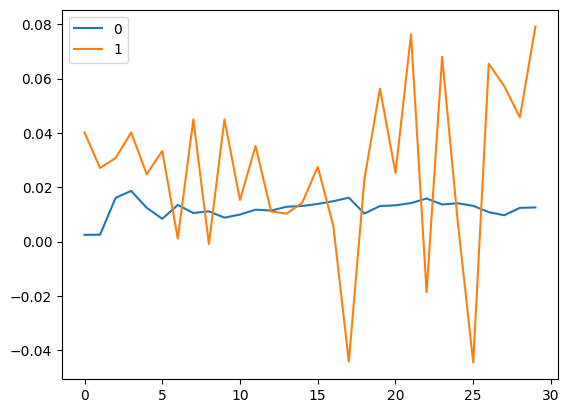

In [ ]:
pd.DataFrame([y_pred_train[:,0],y_train.values.reshape(-1,n_assets)[:,0]]).T[:30].plot()

<Axes: >

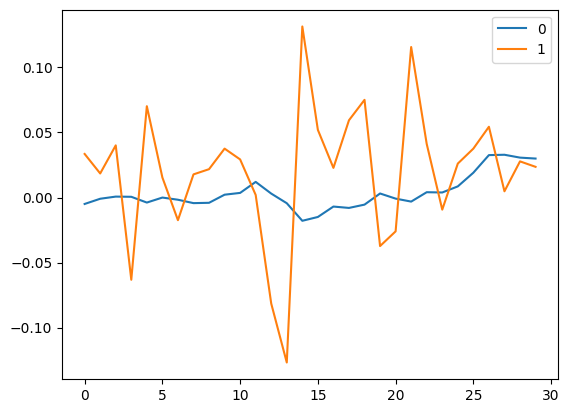

In [ ]:
pd.DataFrame([y_pred_test[:,0],y_test.values.reshape(-1,n_assets)[:,0]]).T[:30].plot()

In [ ]:
riskaversion=1
minwgt=0.
maxwgt=1.
cer, turnover, idx = PORT(y_pred_test, riskaversion, minwgt, maxwgt)

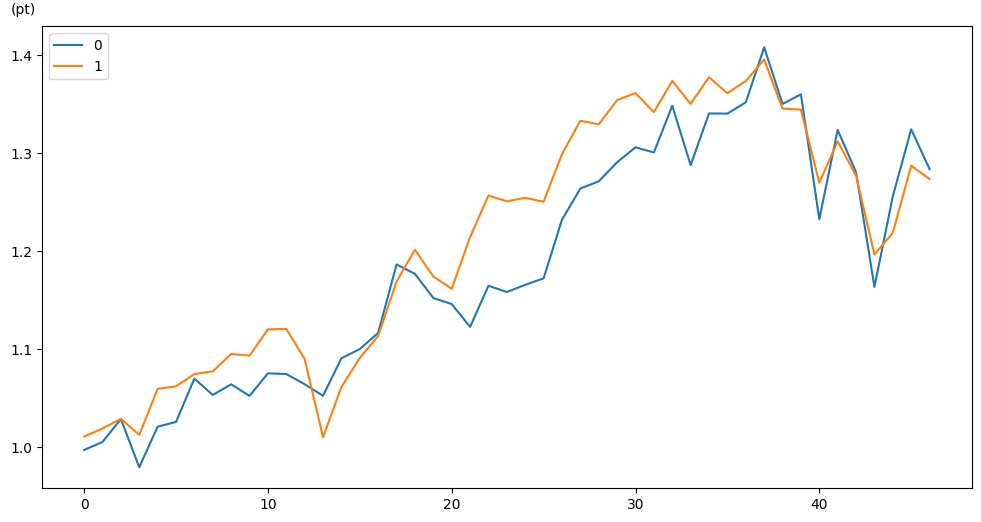

In [ ]:
ts_plot(idx)

In [ ]:
turnover

0.15836308804254437

Memo  
AAPM 논문과 다른 점:  
(1) prevailing mean이 아닌 time-varying nature 고려할 수 있는 rolling mean 사용  
(2) cross-section 정보와 time-series 정보 사용  
(3) flattening과 reshaping 통해 asset class간 interaction 십분 활용  
(4) 일반화 성능 담보를 위한 heavy regulization  

In [ ]:
isr2, y_pred_train = validCAE(feature_train_encoded, target_train_encoded, y_train)
#oosr2, y_pred_test, mean_target_encoded = testCAE(feature_train_encoded, target_train_encoded, feature_test_encoded, target_test_encoded, y_test)

In [ ]:
isr2, y_pred_train, intercept, betas = validCAE_(feature_train_encoded, y_train)
oosr2, y_pred_test, coefs = testCAE_(feature_train_encoded, y_train, feature_test_encoded, y_test)

In [ ]:
isr2, oosr2

(-0.02162762463699397, -0.029813180283128293)

In [ ]:
y_pred_train = y_pred_train.reshape(-1,n_assets)
#y_pred_test = y_pred_test.reshape(-1,n_assets)

<Axes: >

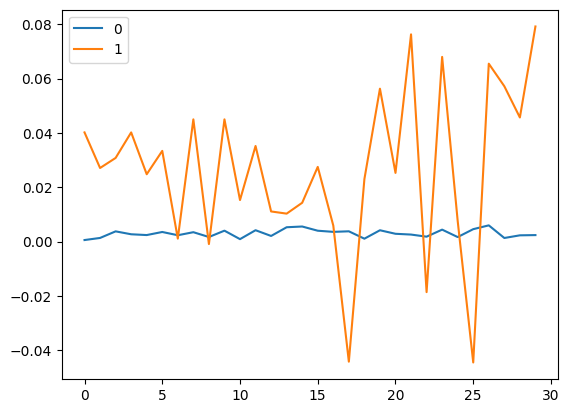

In [ ]:
pd.DataFrame([y_pred_train[:,0],y_train.values.reshape(-1,n_assets)[:,0]]).T[:30].plot()

<Axes: >

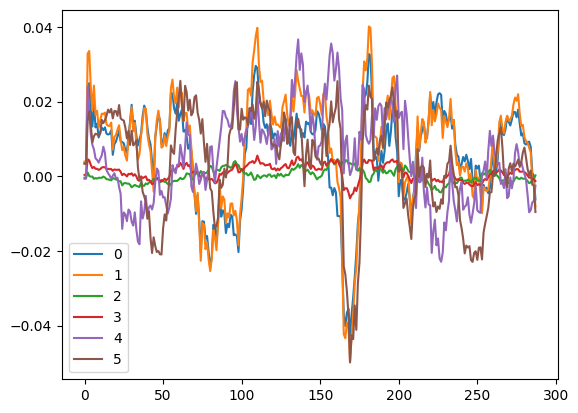

In [ ]:
pd.DataFrame(y_pred_train).plot()

<Axes: >

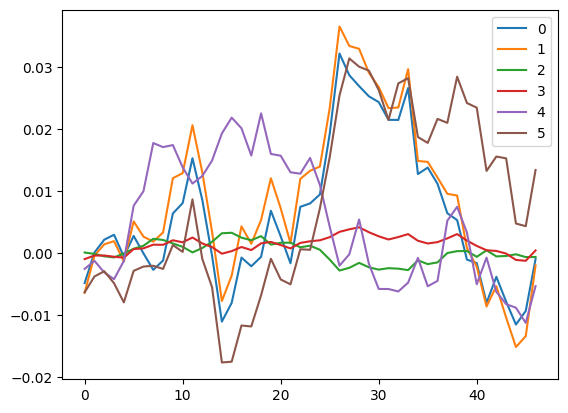

In [ ]:
pd.DataFrame(y_pred_test).plot()

<Axes: >

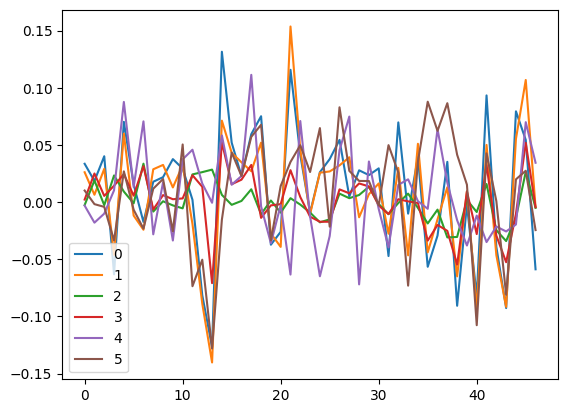

In [ ]:
pd.DataFrame(y_test.values.reshape(-1,n_assets)).plot()

In [ ]:
B_last = feature_last_encoded.copy()
F_last = mean_target_encoded[-1]
y_pred_last = np.dot(B_last,F_last)
y_pred_last

array([[0.00993423, 0.01018754, 0.00801886, 0.00894291, 0.00880534,
        0.00808406]])

In [ ]:
y_pred_last = predictCAE_(feature_train_encoded, y_train, feature_test_encoded, y_test, feature_last_encoded)
y_pred_last

array([[ 0.01236036,  0.02696618, -0.00618359,  0.00410569, -0.0009374 ,
         0.00576469]], dtype=float32)

In [ ]:
X_last

,MOM1M,MOM3M,MOM6M,MOM9M,MOM1Y,REV1W,REV2Y,REV3Y,REV4Y,REV5Y,PTH,HTP,MAX,MIN,CORR,MOMGAP
Date,,,,,,,,,,,,,,,,
2022-12-31,-5.8798,3.3038,1.1424,-16.9520,-19.7947,0.4616,3.7829,24.5413,60.9883,57.4249,-19.9293,0.1346,1.8015,-2.5316,0.4925,0.3854
2022-12-31,-0.4506,16.7938,4.2230,-10.1572,-13.5134,0.0440,-0.8277,6.2871,29.3252,14.7853,-14.6929,1.1795,2.5310,-2.4988,0.4925,0.3854
2022-12-31,-1.3505,9.8272,-3.9278,-13.3617,-19.3554,-0.6206,-19.3934,-6.1646,11.2263,-1.7840,-22.0512,2.6958,1.1673,-1.4930,0.4925,0.3854
2022-12-31,-0.5043,0.1057,-3.1680,-6.8640,-12.2474,-0.9417,-14.0658,-7.4129,-0.4524,-0.5286,-12.3190,0.0717,0.9329,-0.6555,0.4925,0.3854
2022-12-31,-0.4387,2.8821,-1.3710,-8.3377,-15.6507,-1.0926,-16.0712,-8.2357,4.8912,2.2949,-15.7616,0.1108,1.2404,-0.7888,0.4925,0.3854
2022-12-31,-1.0190,0.0221,-3.3088,-9.0471,-11.4349,-0.4145,-6.1774,3.6465,12.6114,11.3170,-12.3070,0.8722,1.0836,-0.9791,0.4925,0.3854
2022-12-31,3.4360,9.7812,-0.2200,-5.0393,0.4736,0.7247,-3.2667,22.6335,45.5308,44.9840,-11.0493,11.5229,2.8315,-1.3551,0.4925,0.3854
2022-12-31,-2.4479,1.0921,-6.1674,-6.9389,15.0640,1.4655,49.5302,43.9004,48.3523,43.7758,-15.9367,31.0006,1.9848,-2.8790,0.4925,0.3854
2022-12-31,-2.6333,6.9954,-5.9801,-22.6744,-23.4730,0.6680,-1.6380,-10.2008,5.5851,4.2315,-24.4057,0.9327,1.8985,-2.1861,0.4925,0.3854


In [ ]:
y_pred_train.shape

(945,)

<Axes: >

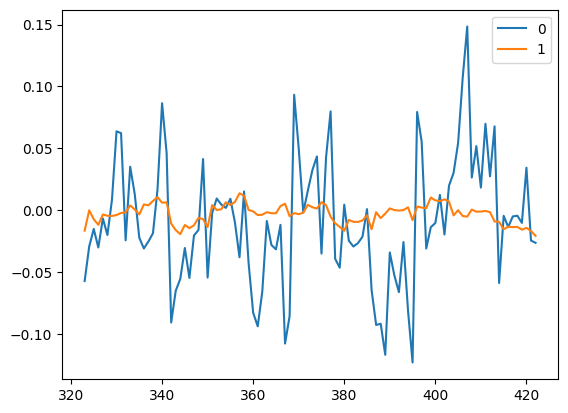

In [ ]:
pd.DataFrame([y_test.values,y_pred]).T[-100:].plot()

<Axes: >

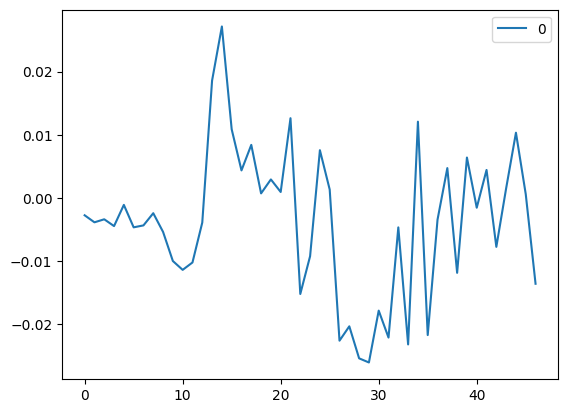

In [ ]:
pd.DataFrame(y_pred.reshape(-1,9)[:,3]).plot()

<Axes: >

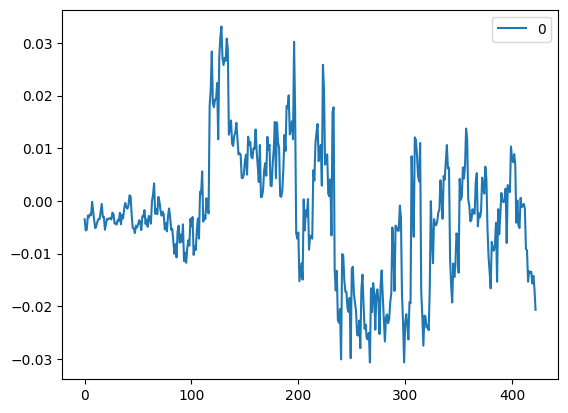

In [ ]:
pd.DataFrame(y_pred).plot()

In [ ]:
y1

array([0.390625  , 0.4296875 , 0.40234375, 0.29296875, 0.265625  ,
       0.296875  , 0.33203125, 0.3515625 , 0.3359375 ], dtype=float32)

In [ ]:
train_encoded.shape

(106, 9, 9)

In [ ]:
X_train_ae.shape

(954, 9)

In [ ]:
# Final forecasting model
model = OLS(X_train, n_test=3, test_window=3)
#model = RandomForest(X_train, n_test=3, test_window=3)
#model = GBRT(X_train, n_test=3, test_window=3)
model.fit(feature_train_encoded, y_train.values)
oosr2 = OOSR2(y_test.values, model.predict(X_test_ae))

NameError: ignored

In [ ]:
cer, turnover, idx, latest_pred = PORT(model, X_test_ae, X_last_ae, n_assets, riskaversion=4.5, minwgt=0., maxwgt=1.)

In [ ]:
oosr2, cer, turnover

(0.019206876696319153, -0.006576860104525028, 0.26125583)

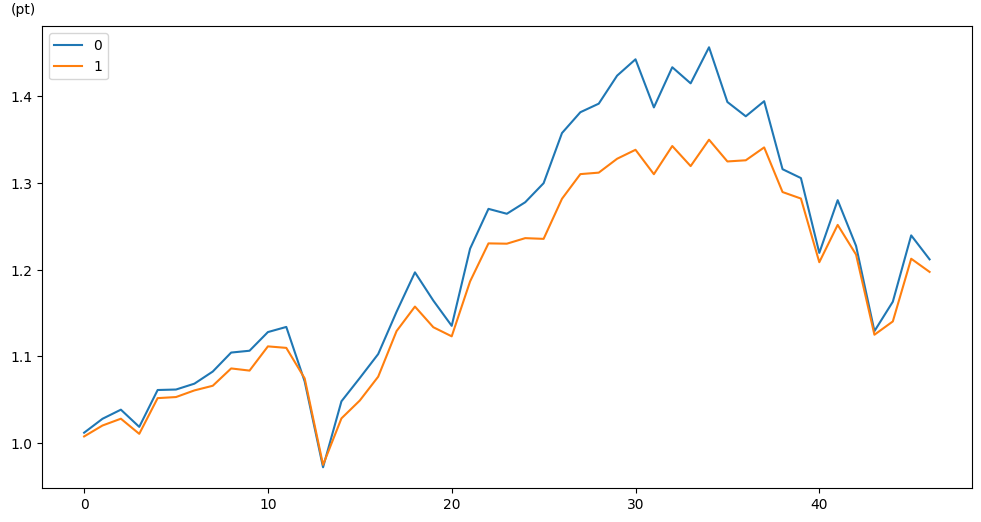

In [ ]:
ts_plot(idx)

####OLS

In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('regressor', LinearRegression()),
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()],
}

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test=3, test_window=3),
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=<generator object ts_cv at 0x000001EA55C66E30>,
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={'scaler': ['passthrough']}, refit='OOSR2',
             scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
0,0.0,0.0,0.0,0.0,passthrough,{'scaler': 'passthrough'},-0.558667,-0.435108,-0.107831,-0.367202,0.190214,1


In [ ]:
OOSR2(y_train.values, grid_search.predict(X_train.values))

0.09713592923996461

In [ ]:
OOSR2(y_test.values, grid_search.predict(X_test.values))

-0.13749267083262962

In [ ]:
best = grid_search.best_estimator_
best.named_steps["regressor"].intercept_

-0.013179052457891957

In [ ]:
best.named_steps["regressor"].coef_

array([ 1.36061132e-03, -1.63914976e-03,  1.92439459e-03,  1.88023039e-03,
       -3.23373775e-03,  3.83224989e-05,  2.58216988e-03,  1.68315141e-03,
       -2.99353162e-03, -1.09274477e-04, -3.78982406e-03,  3.43135312e-04,
       -4.34427556e-03,  8.39237649e-03, -2.22088176e-03, -6.31024492e-04,
        8.55467482e-04, -2.12150257e-03,  8.09413590e-04, -2.64850446e-03,
        3.97114438e-02, -3.45561305e-02, -5.44582938e-03,  1.85799235e-03,
        1.94448469e-03, -5.74674974e-03,  1.64645963e-03,  2.13819507e-03,
       -9.30965382e-03,  2.39270470e-03, -4.33059539e-03,  6.18161698e-03,
       -1.10332899e-04,  7.67726139e-03,  5.22832317e-03,  5.82155831e-05,
        8.13165274e-03,  5.93174734e-03,  2.47908802e-05,  6.42823699e-03,
        3.71491188e-03,  5.82782786e-05,  9.06812889e-03, -5.05537210e-03,
        1.23306327e-03, -1.09700117e-03, -5.67822206e-03,  2.23215473e-03,
       -3.78057841e-03])

In [ ]:
np.round(grid_search.predict(X_last.values)*100,4)

array([ 4.0853,  3.4637,  5.0223,  0.137 ,  0.5808, -0.7389, -0.4679,
       -0.043 ,  2.8113])

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = grid_search.predict(X_test.values).reshape(-1,n_assets) # T+1
dfpass = panel.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T

pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
pfweight[pfweight.sum(axis=1)==0] = 1/n_assets
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
CER(pfret, bmret, riskaversion)

-0.043798565129016906

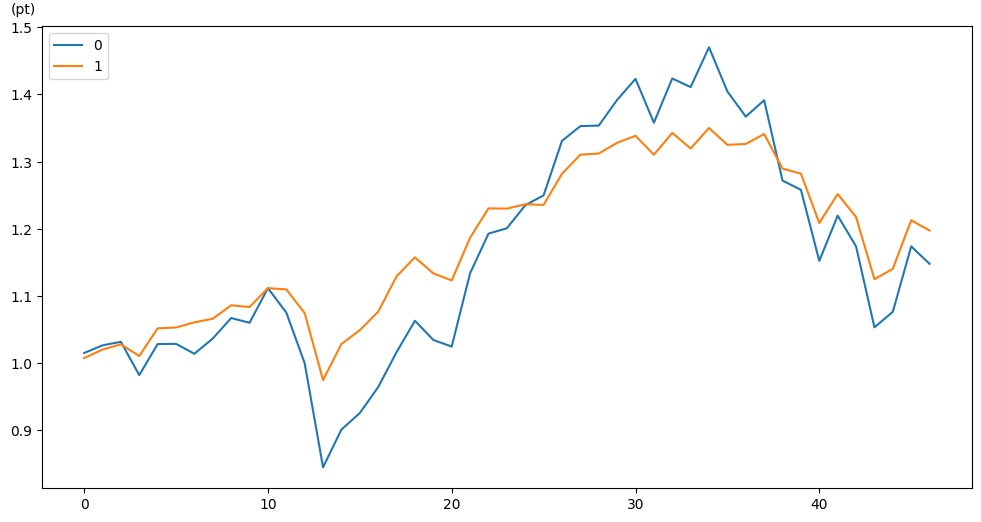

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

####Lasso

In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('regressor', Lasso()),
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()],
    'regressor__alpha': np.logspace(-3,1,100),
}

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test=3, test_window=3),
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=<generator object ts_cv at 0x000001EA55D59230>,
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('regressor', Lasso())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-0...
       1.70735265e+00, 1.87381742e+00, 2.05651231e+00, 2.25701972e+00,
       2.47707636e+00, 2.71858824e+00, 2.98364724e+00, 3.27454916e+00,
       3.59381366e+00, 3.94420606e+00, 4.32876128e+00, 4.75081016e+00,
       5.21400829e+00, 5.72236766e+00, 6.28029144e+00, 6.89261210e+00,
       7.56463328e+00, 8.30217568e+00, 9.11162756e+00, 1.00000000e+01]),
                         'scaler': ['passthrough']},
             refit='OOSR2', scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results[results["rank_test_OOSR2"]<=5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_scaler,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
10,0.001329,4.657509e-04,0.000665,0.000470,0.002535,passthrough,"{'regressor__alpha': 0.0025353644939701114, 's...",0.031088,0.027713,0.029113,0.029305,0.001384,5
11,0.002001,1.123916e-06,0.000666,0.000471,0.002783,passthrough,"{'regressor__alpha': 0.0027825594022071257, 's...",0.031938,0.029100,0.031145,0.030727,0.001196,2
12,0.001997,2.836636e-06,0.000666,0.000471,0.003054,passthrough,"{'regressor__alpha': 0.0030538555088334154, 's...",0.030216,0.030106,0.032812,0.031045,0.001250,1
13,0.002003,1.072147e-06,0.000000,0.000000,0.003352,passthrough,"{'regressor__alpha': 0.003351602650938841, 'sc...",0.026394,0.030877,0.034276,0.030516,0.003228,3
14,0.002001,2.973602e-07,0.000332,0.000470,0.003678,passthrough,"{'regressor__alpha': 0.0036783797718286343, 's...",0.022720,0.031321,0.035496,0.029846,0.005319,4


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', 'passthrough'),
                ('regressor', Lasso(alpha=0.0030538555088334154))])

In [ ]:
OOSR2(y_test.values, grid_search.predict(X_test.values))

0.012813518172373639

In [ ]:
best = grid_search.best_estimator_
best.named_steps["regressor"].intercept_

-0.00024541359314398607

In [ ]:
best.named_steps["regressor"].coef_

array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -4.54009470e-04, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  5.69775072e-04,
        0.00000000e+00, -0.00000000e+00,  2.88694589e-04,  0.00000000e+00,
       -0.00000000e+00,  2.55445654e-04,  0.00000000e+00,  0.00000000e+00,
        7.12004158e-05,  0.00000000e+00,  0.00000000e+00,  1.76669575e-04,
        0.00000000e+00,  0.00000000e+00,  1.08786142e-04,  0.00000000e+00,
        0.00000000e+00,  1.65354502e-04,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  5.24436787e-04,
        0.00000000e+00])

In [ ]:
np.round(grid_search.predict(X_last.values)*100,4)

array([ 1.1862,  0.6004,  0.5654,  0.1841,  0.4211,  0.2361,  0.2952,
       -0.1045,  1.0765])

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = grid_search.predict(X_test.values).reshape(-1,n_assets) # T+1
dfpass = panel.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T

pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
pfweight[pfweight.sum(axis=1)==0] = 1/n_assets
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
CER(pfret, bmret, riskaversion)

-0.0213709416907893

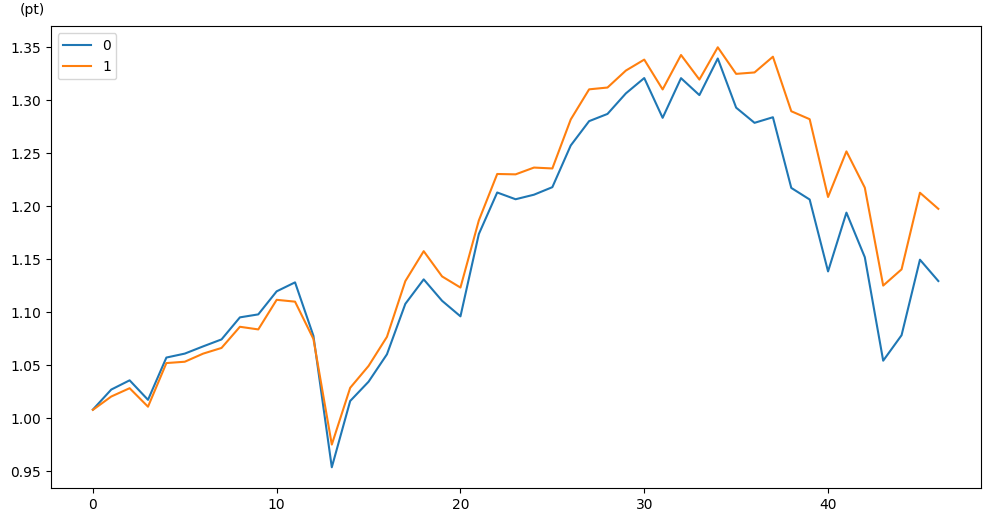

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

####Principal component regression (PCR)

In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('pca', PCA()),
    ('regressor', LinearRegression()),
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()],
    'pca__n_components': [i for i in range(1,11)]
}

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test=3, test_window=3),
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=<generator object ts_cv at 0x000001EA55D5B140>,
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('pca', PCA()),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'scaler': ['passthrough']},
             refit='OOSR2', scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results[results["rank_test_OOSR2"]<=5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_scaler,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
3,0.006671,0.000475,0.000668,0.000472,4,passthrough,"{'pca__n_components': 4, 'scaler': 'passthrough'}",0.006347,0.031207,0.034515,0.024023,0.012572,5
5,0.005090,0.000918,0.000131,0.000185,6,passthrough,"{'pca__n_components': 6, 'scaler': 'passthrough'}",0.007065,0.032335,0.034730,0.024710,0.012515,2
6,0.005671,0.000942,0.000664,0.000469,7,passthrough,"{'pca__n_components': 7, 'scaler': 'passthrough'}",0.006988,0.032396,0.034019,0.024467,0.012378,3
7,0.004337,0.000476,0.000000,0.000000,8,passthrough,"{'pca__n_components': 8, 'scaler': 'passthrough'}",0.006993,0.032227,0.034048,0.024423,0.012347,4
8,0.002547,0.000735,0.000000,0.000000,9,passthrough,"{'pca__n_components': 9, 'scaler': 'passthrough'}",0.024557,0.028928,0.040489,0.031325,0.006721,1


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', 'passthrough'), ('pca', PCA(n_components=9)),
                ('regressor', LinearRegression())])

In [ ]:
OOSR2(y_train.values, grid_search.predict(X_train.values))

0.02529633954640187

In [ ]:
OOSR2(y_test.values, grid_search.predict(X_test.values))

-0.004207454877418915

In [ ]:
best = grid_search.best_estimator_
best.named_steps["regressor"].intercept_

0.003883438155136268

In [ ]:
best.named_steps["regressor"].coef_

array([-4.95360853e-04, -2.30210852e-04, -1.92418833e-04,  1.65301116e-04,
        2.17743369e-05, -1.90577053e-05, -2.20553723e-05,  1.16067099e-05,
        9.44563970e-04])

In [ ]:
best.named_steps["pca"].explained_variance_ratio_

array([0.12358567, 0.11751096, 0.11639385, 0.116203  , 0.11615536,
       0.11614883, 0.11613265, 0.11613012, 0.0154196 ])

In [ ]:
np.round(grid_search.predict(X_last.values)*100,4)

array([ 1.368 ,  0.4666,  0.6618,  0.3181,  0.5567,  0.3291,  0.154 ,
       -0.7768,  1.4034])

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = grid_search.predict(X_test.values).reshape(-1,n_assets) # T+1
dfpass = panel.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T

pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
pfweight[pfweight.sum(axis=1)==0] = 1/n_assets
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
CER(pfret, bmret, riskaversion)

-0.021183216246115587

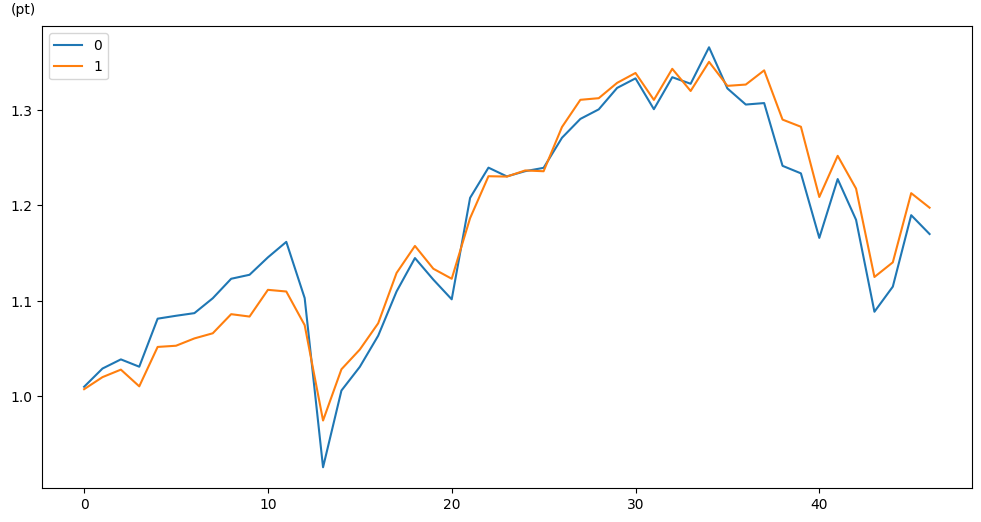

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

####Partial least squares (PLS)

In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('regressor', PLSRegression(scale=False)),
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()],
    'regressor__n_components': [i for i in range(1,11)],
}

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test=3, test_window=3),
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=<generator object ts_cv at 0x000001EA5AF8C190>,
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('regressor',
                                        PLSRegression(scale=False))]),
             n_jobs=-1,
             param_grid={'regressor__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10],
                         'scaler': ['passthrough']},
             refit='OOSR2', scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results[results["rank_test_OOSR2"]<=5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_components,param_scaler,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
0,0.002016,0.000017,0.000665,0.000470,1,passthrough,"{'regressor__n_components': 1, 'scaler': 'pass...",0.016857,0.032903,0.031378,0.027046,0.007232,1
1,0.002102,0.000145,0.000000,0.000000,2,passthrough,"{'regressor__n_components': 2, 'scaler': 'pass...",0.032913,-0.019407,-0.018452,-0.001649,0.024442,2
2,0.002667,0.000472,0.000333,0.000471,3,passthrough,"{'regressor__n_components': 3, 'scaler': 'pass...",0.017946,-0.024823,-0.024730,-0.010536,0.020140,3
3,0.002666,0.000943,0.000334,0.000472,4,passthrough,"{'regressor__n_components': 4, 'scaler': 'pass...",-0.069959,-0.084083,-0.056310,-0.070118,0.011339,4
4,0.001998,0.000002,0.000333,0.000471,5,passthrough,"{'regressor__n_components': 5, 'scaler': 'pass...",-0.070624,-0.091785,-0.052302,-0.071570,0.016133,5


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', 'passthrough'),
                ('regressor', PLSRegression(n_components=1, scale=False))])

In [ ]:
OOSR2(y_train.values, grid_search.predict(X_train.values))

0.027340533947097345

In [ ]:
OOSR2(y_test.values, grid_search.predict(X_test.values))

0.002506702112930026

In [ ]:
best = grid_search.best_estimator_
best.named_steps["regressor"].intercept_

array([0.00388344])

In [ ]:
np.round(grid_search.predict(X_last.values)*100,4)

array([[ 1.3282],
       [ 0.6074],
       [ 0.5146],
       [ 0.0674],
       [ 0.3273],
       [ 0.1574],
       [ 0.2979],
       [-0.4751],
       [ 1.1311]])

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = grid_search.predict(X_test.values).reshape(-1,n_assets) # T+1
dfpass = panel.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T

pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
pfweight[pfweight.sum(axis=1)==0] = 1/n_assets
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
CER(pfret, bmret, riskaversion)

-0.021796139466144716

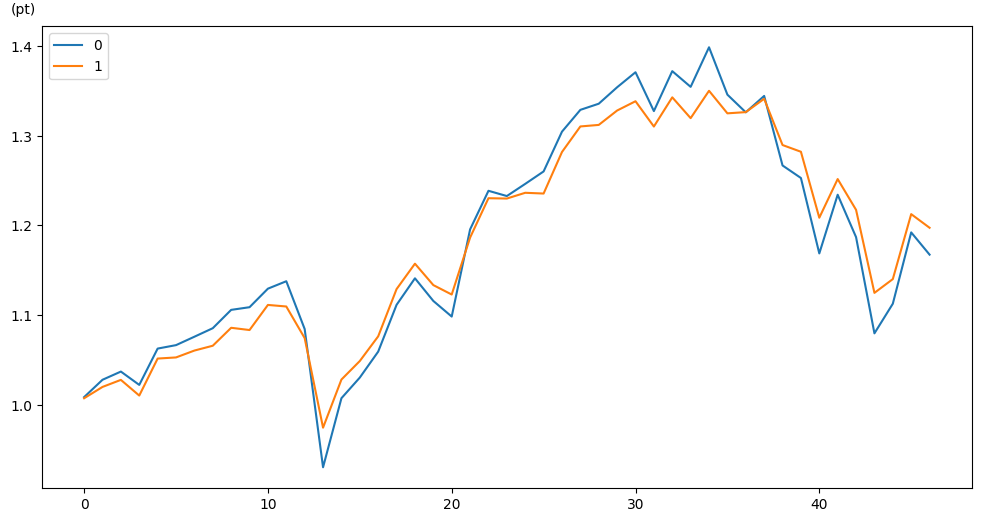

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

####Reduced-rank regression (RRR)

In [ ]:
class ReducedRankRegression():

    def __init__(self, rank=rank, n_assets=n_assets, n_features=n_features):
        self.rank = rank
        self.n_assets = n_assets
        self.n_features = n_features
        self.B = None

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, Y):
        rank = self.rank
        self._fit_svd(X, Y, rank)
        return self

    def _fit_svd(self, X, Y, rank):
        X = X.reshape(-1,n_assets*n_features)
        Y = Y.reshape(-1,n_assets)
        assert self.rank <= np.min([X.shape[1], Y.shape[1]])
        p, q = X.shape[1], Y.shape[1]
        B_ols = np.linalg.inv(X.T @ X) @ X.T @ Y
        Y_hat = X @ B_ols
        _, Sigma, V_t = np.linalg.svd(Y_hat)

        reduced_V_t = V_t[:rank,:]
        B_rrr = B_ols @ reduced_V_t.T @ reduced_V_t
        self.B = B_rrr

    def predict(self, X):
        return X @ self.B

NameError: name 'rank' is not defined

In [ ]:
X_train.values.reshape(-1,35*7).shape

(108, 245)

In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('regressor', ReducedRankRegression()),
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()],
    'regressor__rank': [i for i in range(1,5)],
}

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test = 3),
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=<generator object ts_cv at 0x000001F718424660>,
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('regressor',
                                        <__main__.ReducedRankRegression object at 0x000001F718416170>)]),
             n_jobs=-1,
             param_grid={'regressor__rank': [1, 2, 3, 4],
                         'scaler': ['passthrough']},
             refit='OOSR2', scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results[results["rank_test_OOSR2"]<=5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__rank,param_scaler,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
0,0.004338,0.000938,0.000000,0.000000,1,passthrough,"{'regressor__rank': 1, 'scaler': 'passthrough'}",-27.879735,-4.549848,-0.854287,-11.094623,11.964371,1
1,0.006672,0.004718,0.001667,0.002358,2,passthrough,"{'regressor__rank': 2, 'scaler': 'passthrough'}",-27.879735,-4.549848,-0.854287,-11.094623,11.964371,1
2,0.004995,0.004081,0.001669,0.002360,3,passthrough,"{'regressor__rank': 3, 'scaler': 'passthrough'}",-27.879735,-4.549848,-0.854287,-11.094623,11.964371,1
3,0.005001,0.000002,0.000000,0.000000,4,passthrough,"{'regressor__rank': 4, 'scaler': 'passthrough'}",-27.879735,-4.549848,-0.854287,-11.094623,11.964371,1


####Random forest (RF)

In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('regressor', RandomForestRegressor()),
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()],
    'regressor__n_estimators': [i for i in np.arange(10,100)],
    'regressor__max_depth': [i for i in np.arange(1,6)],
    'regressor__max_features': [2,4,6,8,10,12,15],
}

grid_search = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test=3, test_window=3),
    n_iter=200,
    n_jobs=-1,
    error_score='raise',
    #random_state=1111,
)

grid_search.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=<generator object ts_cv at 0x000001EA5AF8CF20>,
                   error_score='raise',
                   estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'regressor__max_depth': [1, 2, 3, 4, 5],
                                        'regressor__max_features': [2, 4, 6, 8,
                                                                    10, 12,
                                                                    15],
                                        'regressor__n_estimators': [10, 11, 12,
                                                                    13, 14, 15,
                                                                    16, 17, 18,
                                                                    19, 20, 21,
                                                                    22, 23, 24,
                                                                    25, 26, 27,
                                                                    28, 29, 30,
                                                                    31, 32, 33,
                                                                    34, 35, 36,
                                                                    37, 38, 39, ...],
                                        'scaler': ['passthrough']},
                   refit='OOSR2', scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results[results["rank_test_OOSR2"]<=5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_regressor__n_estimators,param_regressor__max_features,param_regressor__max_depth,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
14,0.090026,0.006822,0.000972,0.000830,passthrough,33,6,4,"{'scaler': 'passthrough', 'regressor__n_estima...",0.007892,0.045080,0.047227,0.033399,0.018058,2
49,0.225981,0.012173,0.007341,0.002049,passthrough,85,6,5,"{'scaler': 'passthrough', 'regressor__n_estima...",-0.024922,0.050132,0.046498,0.023903,0.034556,4
87,0.091724,0.000988,0.004998,0.000002,passthrough,54,2,4,"{'scaler': 'passthrough', 'regressor__n_estima...",0.014802,0.047750,0.040204,0.034252,0.014094,1
103,0.050518,0.003322,0.003022,0.001400,passthrough,20,8,4,"{'scaler': 'passthrough', 'regressor__n_estima...",-0.000693,0.037708,0.035081,0.024032,0.017516,3
170,0.064050,0.003662,0.000665,0.000941,passthrough,18,12,4,"{'scaler': 'passthrough', 'regressor__n_estima...",-0.017872,0.038275,0.051254,0.023886,0.029999,5


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', 'passthrough'),
                ('regressor',
                 RandomForestRegressor(max_depth=4, max_features=2,
                                       n_estimators=54))])

In [ ]:
OOSR2(y_train.values, grid_search.predict(X_train.values))

0.11889130408366733

In [ ]:
OOSR2(y_test.values, grid_search.predict(X_test.values))

0.02188972365360542

In [ ]:
best = grid_search.best_estimator_
best.named_steps["regressor"].feature_importances_

array([3.24912140e-02, 1.21668500e-02, 2.53845856e-02, 3.46267576e-02,
       6.15068745e-02, 3.54240379e-03, 1.05749303e-02, 5.12402569e-03,
       2.82894693e-03, 4.60872849e-03, 6.89353058e-02, 4.47387280e-02,
       3.53370273e-02, 5.11494842e-02, 3.46698377e-02, 1.42928031e-02,
       7.21092505e-03, 1.62841734e-03, 6.54761195e-03, 4.05495086e-03,
       3.30616824e-02, 5.44062529e-02, 1.08527195e-02, 2.74982776e-02,
       9.85400558e-03, 3.16898138e-02, 1.66807574e-02, 4.97683295e-03,
       2.34348825e-02, 5.17387924e-02, 5.18054437e-02, 1.53041480e-03,
       2.55136113e-04, 1.05638587e-04, 6.41556796e-05, 1.51168682e-03,
       1.53068578e-04, 3.85786028e-04, 1.31980421e-03, 3.39563456e-04,
       2.04143547e-02, 3.48277147e-02, 1.67048896e-02, 2.25239728e-02,
       1.86636055e-02, 2.15949539e-02, 1.14850833e-02, 5.85207757e-02,
       1.21795266e-02])

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = grid_search.predict(X_test.values).reshape(-1,n_assets) # T+1
dfpass = panel.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T

pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
#pfweight = (oosexpret).clip(minwgt,maxwgt)
pfweight[pfweight.sum(axis=1)==0] = 1/n_assets
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
CER(pfret, bmret, riskaversion)

-0.003793726330244891

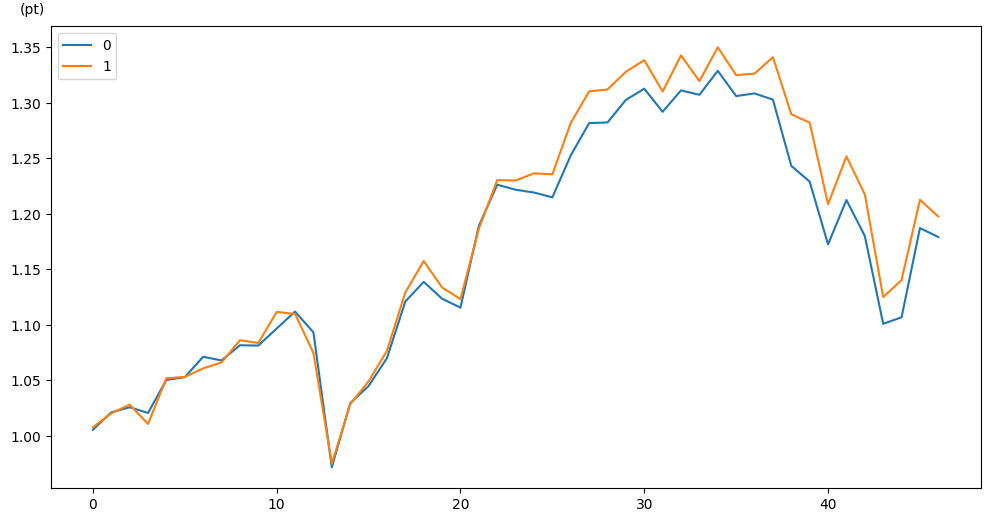

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

In [ ]:
np.round(grid_search.predict(X_last.values)*100,4)

array([ 0.2707,  0.5364,  1.2553,  0.2507,  0.2804,  0.2269,  0.4172,
       -0.3122,  0.2939])

####Gradient boosted regression tree (GBRT)

In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('regressor', GradientBoostingRegressor()),
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()],
    'regressor__n_estimators': [i for i in np.arange(10,100)],
    'regressor__max_depth': [i for i in np.arange(1,6)],
    'regressor__max_features': [2,4,6,8,10,12,15],
    'regressor__subsample': [0.8,0.9,1.0],
    'regressor__learning_rate': np.logspace(-3,0,100),
    #'regressor__learning_rate': loguniform(0.0001,10),
}

grid_search = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test=3, test_window=3),
    n_iter=200,
    n_jobs=-1,
    error_score='raise',
    #random_state=1111,
)

grid_search.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=<generator object ts_cv at 0x000001EA5AF8EF10>,
                   error_score='raise',
                   estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                             ('regressor',
                                              GradientBoostingRegressor())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'regressor__learning_rate': array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753,...
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
                                        'regressor__max_depth': [1, 2, 3, 4, 5],
                                        'regressor__max_features': [2, 4, 6, 8,
                                                                    10, 12,
                                                                    15],
                                        'regressor__n_estimators': [10, 11, 12,
                                                                    13, 14, 15,
                                                                    16, 17, 18,
                                                                    19, 20, 21,
                                                                    22, 23, 24,
                                                                    25, 26, 27,
                                                                    28, 29, 30,
                                                                    31, 32, 33,
                                                                    34, 35, 36,
                                                                    37, 38, 39, ...],
                                        'regressor__subsample': [0.8, 0.9, 1.0],
                                        'scaler': ['passthrough']},
                   refit='OOSR2', scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results[results["rank_test_OOSR2"]<=5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_regressor__subsample,param_regressor__n_estimators,param_regressor__max_features,param_regressor__max_depth,param_regressor__learning_rate,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
2,0.030960,0.005496,0.000999,0.000003,passthrough,0.9,21,2,5,0.012328,"{'scaler': 'passthrough', 'regressor__subsampl...",-0.010303,0.023686,0.036053,0.016479,0.019599,5
51,0.053472,0.004869,0.001667,0.002357,passthrough,0.9,40,4,3,0.012328,"{'scaler': 'passthrough', 'regressor__subsampl...",-0.005923,0.030067,0.030414,0.018186,0.017048,4
64,0.055382,0.014760,0.000000,0.000000,passthrough,1.0,12,10,5,0.046416,"{'scaler': 'passthrough', 'regressor__subsampl...",-0.017068,0.033349,0.042142,0.019474,0.026087,1
67,0.182790,0.009170,0.001333,0.000943,passthrough,0.9,89,4,5,0.015199,"{'scaler': 'passthrough', 'regressor__subsampl...",-0.011502,0.043975,0.023981,0.018818,0.022940,3
94,0.154380,0.021185,0.001011,0.000831,passthrough,0.8,54,10,4,0.024771,"{'scaler': 'passthrough', 'regressor__subsampl...",-0.025568,0.040363,0.042466,0.019087,0.031588,2


In [ ]:
grid_search.best_params_

{'scaler': 'passthrough',
 'regressor__subsample': 1.0,
 'regressor__n_estimators': 12,
 'regressor__max_features': 10,
 'regressor__max_depth': 5,
 'regressor__learning_rate': 0.046415888336127795}

In [ ]:
OOSR2(y_train.values, grid_search.predict(X_train.values))

0.14150631179371975

In [ ]:
OOSR2(y_test.values, grid_search.predict(X_test.values))

0.006972899299671154

In [ ]:
best = grid_search.best_estimator_
best.named_steps["regressor"].feature_importances_

array([0.07959056, 0.02738936, 0.02578602, 0.02440145, 0.04280327,
       0.00151605, 0.00803668, 0.00070349, 0.00102546, 0.00127086,
       0.07501207, 0.01544306, 0.03006133, 0.01376149, 0.04480184,
       0.        , 0.0006703 , 0.        , 0.        , 0.        ,
       0.1262636 , 0.13495224, 0.00044101, 0.02802893, 0.00711814,
       0.00534941, 0.04096077, 0.        , 0.        , 0.10866013,
       0.01315332, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00851633, 0.00967567, 0.        , 0.        , 0.0126887 ,
       0.00324772, 0.0025786 , 0.09509631, 0.01099581])

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = grid_search.predict(X_test.values).reshape(-1,n_assets) # T+1
dfpass = panel.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T

pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
#pfweight = (oosexpret).clip(minwgt,maxwgt)
pfweight[pfweight.sum(axis=1)==0] = 1/n_assets
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
CER(pfret, bmret, riskaversion)

-0.007576118048402188

In [ ]:
abs(pfweight[1:] - np.roll(pfweight,shift=1,axis=0)[1:]).sum(axis=1).mean()

0.31580472580454266

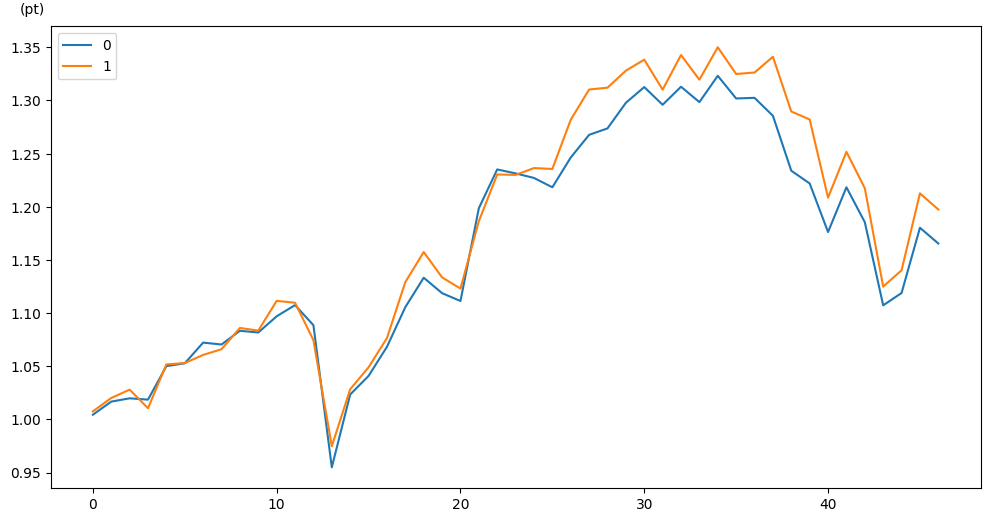

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

In [ ]:
bmret.std()

0.031199068405079404

In [ ]:
np.round(grid_search.predict(X_last.values)*100,4)

array([0.4285, 0.4509, 0.9766, 0.3287, 0.3891, 0.3891, 0.4015, 0.2469,
       0.2974])

####Conditional autoencoder (CAE)

In [ ]:
def build_model(hidden_units=16, n_factors=3, lr=0.01):
    # input layer
    input_feature = Input(shape=(n_tickers,n_features))
    input_target = Input((n_tickers,))

    # factor network
    h = Dense(hidden_units, kernel_regularizer=L1(0.01))(input_feature)
    h = BatchNormalization()(h)
    h = ReLU()(h)
    #h = Dense(hidden_units, kernel_regularizer=L1(0.01))(h)
    #h = BatchNormalization()(h)
    #h = ReLU()(h)
    output_feature = Dense(n_factors)(h)

    # target network
    output_target = Dense(n_factors)(input_target)

    # output layer
    output = Dot(axes=(2,1))([output_feature, output_target])

    # define model
    autoencoder = Model(inputs=[input_feature, input_target], outputs=output)
    feature_encoder = Model(inputs=input_feature, outputs=output_feature)
    target_encoder = Model(inputs=input_target, outputs=output_target)

    # optimizer
    optimizer = Adam(learning_rate=lr)
    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder, feature_encoder, target_encoder

In [ ]:
def OLS(X_train, n_test, test_window):
    pipeline = Pipeline([
        ('scaler', 'passthrough'),
        ('regressor', LinearRegression())
    ])
    param_grid = {
        'scaler': ['passthrough']
    } #StandardScaler()]}
    model = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid,
        scoring={'OOSR2': make_scorer(OOSR2)}, refit='OOSR2',
        cv=ts_cv(X_train, n_test, test_window),
        n_jobs=-1, error_score='raise')
    return model

In [ ]:
variables = X_train.columns.to_list()
n_tickers = len(assets)
n_features = len(variables)

factor_opts = [2,3,4,5]
unit_opts = [8,16,32]
lr_opts = [0.001,0.01]

param_grid = list(product(unit_opts, factor_opts, lr_opts))
cb = EarlyStopping(patience=50, restore_best_weights=True)

scores = []
for units, n_factors, lr in param_grid:

    autoencoder, feature_encoder, target_encoder = build_model(hidden_units=units, n_factors=n_factors, lr=lr)

    for fold, (train_idx, test_idx) in enumerate(ts_cv(X_train, n_test=3, test_window=3)):
        X1_train = X_train.iloc[train_idx].values.reshape(-1,n_tickers,n_features)
        X2_train = y_train.iloc[train_idx].values.reshape(-1,n_tickers)
        X1_test = X_train.iloc[test_idx].values.reshape(-1,n_tickers,n_features)
        X2_test = y_train.iloc[test_idx].values.reshape(-1,n_tickers)

        autoencoder.fit([X1_train, X2_train], X2_train, epochs=250, batch_size=128, verbose=2,
                        validation_data=([X1_test,X2_test],X2_test), callbacks=[cb])

    train_encoded = feature_encoder.predict(X_train.values.reshape(-1,n_tickers,n_features))
    train0, train1 = train_encoded.shape[0], train_encoded.shape[1]
    X_train_ae = train_encoded.reshape(train0*train1,-1)

    test_encoded = feature_encoder.predict(X_test.values.reshape(-1,n_tickers,n_features))
    test0, test1 = test_encoded.shape[0], test_encoded.shape[1]
    X_test_ae = test_encoded.reshape(test0*test1,-1)

    model = OLS(X_train, n_test=3, test_window=3)
    model.fit(X_train_ae, y_train.values)
    oosr2 = OOSR2(y_test.values, model.predict(X_test_ae))

    scores.append([units, n_factors, lr, oosr2])

scores = pd.DataFrame(scores, columns=['units','n_factors','lr','oosR2'])

Epoch 1/250
1/1 - 1s - loss: 0.6233 - val_loss: 0.6665 - 681ms/epoch - 681ms/step
Epoch 2/250
1/1 - 0s - loss: 0.6189 - val_loss: 0.6536 - 27ms/epoch - 27ms/step
Epoch 3/250
1/1 - 0s - loss: 0.6146 - val_loss: 0.6427 - 26ms/epoch - 26ms/step
Epoch 4/250
1/1 - 0s - loss: 0.6103 - val_loss: 0.6333 - 28ms/epoch - 28ms/step
Epoch 5/250
1/1 - 0s - loss: 0.6060 - val_loss: 0.6248 - 27ms/epoch - 27ms/step
Epoch 6/250
1/1 - 0s - loss: 0.6018 - val_loss: 0.6171 - 26ms/epoch - 26ms/step
Epoch 7/250
1/1 - 0s - loss: 0.5976 - val_loss: 0.6100 - 27ms/epoch - 27ms/step
Epoch 8/250
1/1 - 0s - loss: 0.5934 - val_loss: 0.6034 - 27ms/epoch - 27ms/step
Epoch 9/250
1/1 - 0s - loss: 0.5892 - val_loss: 0.5972 - 30ms/epoch - 30ms/step
Epoch 10/250
1/1 - 0s - loss: 0.5851 - val_loss: 0.5913 - 27ms/epoch - 27ms/step
Epoch 11/250
1/1 - 0s - loss: 0.5810 - val_loss: 0.5857 - 30ms/epoch - 30ms/step
Epoch 12/250
1/1 - 0s - loss: 0.5769 - val_loss: 0.5803 - 33ms/epoch - 33ms/step
Epoch 13/250
1/1 - 0s - loss: 0.572

Epoch 103/250
1/1 - 0s - loss: 0.2811 - val_loss: 0.2742 - 25ms/epoch - 25ms/step
Epoch 104/250
1/1 - 0s - loss: 0.2784 - val_loss: 0.2716 - 25ms/epoch - 25ms/step
Epoch 105/250
1/1 - 0s - loss: 0.2758 - val_loss: 0.2690 - 24ms/epoch - 24ms/step
Epoch 106/250
1/1 - 0s - loss: 0.2732 - val_loss: 0.2664 - 25ms/epoch - 25ms/step
Epoch 107/250
1/1 - 0s - loss: 0.2706 - val_loss: 0.2639 - 25ms/epoch - 25ms/step
Epoch 108/250
1/1 - 0s - loss: 0.2680 - val_loss: 0.2613 - 26ms/epoch - 26ms/step
Epoch 109/250
1/1 - 0s - loss: 0.2654 - val_loss: 0.2589 - 25ms/epoch - 25ms/step
Epoch 110/250
1/1 - 0s - loss: 0.2630 - val_loss: 0.2564 - 25ms/epoch - 25ms/step
Epoch 111/250
1/1 - 0s - loss: 0.2605 - val_loss: 0.2539 - 24ms/epoch - 24ms/step
Epoch 112/250
1/1 - 0s - loss: 0.2579 - val_loss: 0.2514 - 25ms/epoch - 25ms/step
Epoch 113/250
1/1 - 0s - loss: 0.2554 - val_loss: 0.2488 - 26ms/epoch - 26ms/step
Epoch 114/250
1/1 - 0s - loss: 0.2528 - val_loss: 0.2464 - 26ms/epoch - 26ms/step
Epoch 115/250
1/

Epoch 203/250
1/1 - 0s - loss: 0.0813 - val_loss: 0.0779 - 25ms/epoch - 25ms/step
Epoch 204/250
1/1 - 0s - loss: 0.0799 - val_loss: 0.0765 - 24ms/epoch - 24ms/step
Epoch 205/250
1/1 - 0s - loss: 0.0786 - val_loss: 0.0752 - 26ms/epoch - 26ms/step
Epoch 206/250
1/1 - 0s - loss: 0.0772 - val_loss: 0.0740 - 25ms/epoch - 25ms/step
Epoch 207/250
1/1 - 0s - loss: 0.0760 - val_loss: 0.0727 - 25ms/epoch - 25ms/step
Epoch 208/250
1/1 - 0s - loss: 0.0747 - val_loss: 0.0715 - 26ms/epoch - 26ms/step
Epoch 209/250
1/1 - 0s - loss: 0.0734 - val_loss: 0.0702 - 24ms/epoch - 24ms/step
Epoch 210/250
1/1 - 0s - loss: 0.0721 - val_loss: 0.0690 - 24ms/epoch - 24ms/step
Epoch 211/250
1/1 - 0s - loss: 0.0709 - val_loss: 0.0679 - 27ms/epoch - 27ms/step
Epoch 212/250
1/1 - 0s - loss: 0.0698 - val_loss: 0.0667 - 27ms/epoch - 27ms/step
Epoch 213/250
1/1 - 0s - loss: 0.0686 - val_loss: 0.0655 - 28ms/epoch - 28ms/step
Epoch 214/250
1/1 - 0s - loss: 0.0674 - val_loss: 0.0643 - 27ms/epoch - 27ms/step
Epoch 215/250
1/

Epoch 54/250
1/1 - 0s - loss: 0.0046 - val_loss: 0.0040 - 25ms/epoch - 25ms/step
Epoch 55/250
1/1 - 0s - loss: 0.0044 - val_loss: 0.0039 - 25ms/epoch - 25ms/step
Epoch 56/250
1/1 - 0s - loss: 0.0043 - val_loss: 0.0037 - 25ms/epoch - 25ms/step
Epoch 57/250
1/1 - 0s - loss: 0.0041 - val_loss: 0.0035 - 26ms/epoch - 26ms/step
Epoch 58/250
1/1 - 0s - loss: 0.0039 - val_loss: 0.0033 - 26ms/epoch - 26ms/step
Epoch 59/250
1/1 - 0s - loss: 0.0036 - val_loss: 0.0031 - 30ms/epoch - 30ms/step
Epoch 60/250
1/1 - 0s - loss: 0.0035 - val_loss: 0.0030 - 26ms/epoch - 26ms/step
Epoch 61/250
1/1 - 0s - loss: 0.0033 - val_loss: 0.0029 - 26ms/epoch - 26ms/step
Epoch 62/250
1/1 - 0s - loss: 0.0032 - val_loss: 0.0027 - 26ms/epoch - 26ms/step
Epoch 63/250
1/1 - 0s - loss: 0.0031 - val_loss: 0.0026 - 25ms/epoch - 25ms/step
Epoch 64/250
1/1 - 0s - loss: 0.0029 - val_loss: 0.0025 - 26ms/epoch - 26ms/step
Epoch 65/250
1/1 - 0s - loss: 0.0028 - val_loss: 0.0024 - 26ms/epoch - 26ms/step
Epoch 66/250
1/1 - 0s - loss

Epoch 155/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 33ms/epoch - 33ms/step
Epoch 156/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0014 - 26ms/epoch - 26ms/step
Epoch 157/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0013 - 25ms/epoch - 25ms/step
Epoch 158/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 25ms/epoch - 25ms/step
Epoch 159/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 25ms/epoch - 25ms/step
Epoch 160/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 26ms/epoch - 26ms/step
Epoch 161/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 25ms/epoch - 25ms/step
Epoch 162/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 26ms/epoch - 26ms/step
Epoch 163/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 164/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 25ms/epoch - 25ms/step
Epoch 165/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 24ms/epoch - 24ms/step
Epoch 166/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0013 - 24ms/epoch - 24ms/step
Epoch 167/250
1/

Epoch 79/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 24ms/epoch - 24ms/step
Epoch 80/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 26ms/epoch - 26ms/step
Epoch 81/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 25ms/epoch - 25ms/step
Epoch 82/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0012 - 26ms/epoch - 26ms/step
Epoch 83/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0012 - 26ms/epoch - 26ms/step
Epoch 84/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 24ms/epoch - 24ms/step
Epoch 85/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 25ms/epoch - 25ms/step
Epoch 86/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 23ms/epoch - 23ms/step
Epoch 87/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 25ms/epoch - 25ms/step
Epoch 88/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0012 - 25ms/epoch - 25ms/step
Epoch 89/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 24ms/epoch - 24ms/step
Epoch 90/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0012 - 24ms/epoch - 24ms/step
Epoch 91/250
1/1 - 0s - loss

Epoch 19/250
1/1 - 0s - loss: 0.1576 - val_loss: 0.1401 - 27ms/epoch - 27ms/step
Epoch 20/250
1/1 - 0s - loss: 0.1408 - val_loss: 0.1251 - 24ms/epoch - 24ms/step
Epoch 21/250
1/1 - 0s - loss: 0.1257 - val_loss: 0.1118 - 25ms/epoch - 25ms/step
Epoch 22/250
1/1 - 0s - loss: 0.1124 - val_loss: 0.0984 - 25ms/epoch - 25ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0990 - val_loss: 0.0866 - 25ms/epoch - 25ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0872 - val_loss: 0.0770 - 27ms/epoch - 27ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0777 - val_loss: 0.0684 - 25ms/epoch - 25ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0692 - val_loss: 0.0603 - 26ms/epoch - 26ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0613 - val_loss: 0.0540 - 26ms/epoch - 26ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0550 - val_loss: 0.0496 - 25ms/epoch - 25ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0506 - val_loss: 0.0461 - 26ms/epoch - 26ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0469 - val_loss: 0.0442 - 25ms/epoch - 25ms/step
Epoch 31/250
1/1 - 0s - loss

Epoch 120/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0059 - 27ms/epoch - 27ms/step
Epoch 121/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0057 - 24ms/epoch - 24ms/step
Epoch 122/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0056 - 26ms/epoch - 26ms/step
Epoch 123/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0057 - 24ms/epoch - 24ms/step
Epoch 124/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0057 - 24ms/epoch - 24ms/step
Epoch 125/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0056 - 24ms/epoch - 24ms/step
Epoch 126/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0054 - 26ms/epoch - 26ms/step
Epoch 127/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0056 - 24ms/epoch - 24ms/step
Epoch 128/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0059 - 23ms/epoch - 23ms/step
Epoch 129/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0059 - 25ms/epoch - 25ms/step
Epoch 130/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0058 - 23ms/epoch - 23ms/step
Epoch 131/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0055 - 25ms/epoch - 25ms/step
Epoch 132/250
1/

Epoch 45/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0058 - 26ms/epoch - 26ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0058 - 24ms/epoch - 24ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0057 - 25ms/epoch - 25ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0056 - 24ms/epoch - 24ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0056 - 24ms/epoch - 24ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0055 - 25ms/epoch - 25ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0055 - 26ms/epoch - 26ms/step
Epoch 1/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0049 - 50ms/epoch - 50ms/step
Epoch 2/250
1/1 - 0s - loss: 0.0049 - val_loss: 0.0061 - 23ms/epoch - 23ms/step
Epoch 3/250
1/1 - 0s - loss: 0.0061 - val_loss: 0.0066 - 26ms/epoch - 26ms/step
Epoch 4/250
1/1 - 0s - loss: 0.0066 - val_loss: 0.0065 - 25ms/epoch - 25ms/step
Epoch 5/250
1/1 - 0s - loss: 0.0063 - val_loss: 0.0057 - 25ms/epoch - 25ms/step
Epoch 6/250
1/1 - 0s - loss: 0.00

1/1 - 0s - loss: 0.5117 - val_loss: 0.5068 - 23ms/epoch - 23ms/step
Epoch 44/250
1/1 - 0s - loss: 0.5082 - val_loss: 0.5033 - 22ms/epoch - 22ms/step
Epoch 45/250
1/1 - 0s - loss: 0.5047 - val_loss: 0.4997 - 22ms/epoch - 22ms/step
Epoch 46/250
1/1 - 0s - loss: 0.5012 - val_loss: 0.4962 - 23ms/epoch - 23ms/step
Epoch 47/250
1/1 - 0s - loss: 0.4976 - val_loss: 0.4927 - 23ms/epoch - 23ms/step
Epoch 48/250
1/1 - 0s - loss: 0.4941 - val_loss: 0.4891 - 24ms/epoch - 24ms/step
Epoch 49/250
1/1 - 0s - loss: 0.4905 - val_loss: 0.4857 - 23ms/epoch - 23ms/step
Epoch 50/250
1/1 - 0s - loss: 0.4871 - val_loss: 0.4822 - 23ms/epoch - 23ms/step
Epoch 51/250
1/1 - 0s - loss: 0.4836 - val_loss: 0.4788 - 23ms/epoch - 23ms/step
Epoch 52/250
1/1 - 0s - loss: 0.4802 - val_loss: 0.4753 - 24ms/epoch - 24ms/step
Epoch 53/250
1/1 - 0s - loss: 0.4767 - val_loss: 0.4719 - 23ms/epoch - 23ms/step
Epoch 54/250
1/1 - 0s - loss: 0.4733 - val_loss: 0.4685 - 23ms/epoch - 23ms/step
Epoch 55/250
1/1 - 0s - loss: 0.4699 - va

Epoch 144/250
1/1 - 0s - loss: 0.2157 - val_loss: 0.2124 - 24ms/epoch - 24ms/step
Epoch 145/250
1/1 - 0s - loss: 0.2133 - val_loss: 0.2100 - 23ms/epoch - 23ms/step
Epoch 146/250
1/1 - 0s - loss: 0.2110 - val_loss: 0.2077 - 23ms/epoch - 23ms/step
Epoch 147/250
1/1 - 0s - loss: 0.2087 - val_loss: 0.2054 - 23ms/epoch - 23ms/step
Epoch 148/250
1/1 - 0s - loss: 0.2064 - val_loss: 0.2031 - 24ms/epoch - 24ms/step
Epoch 149/250
1/1 - 0s - loss: 0.2041 - val_loss: 0.2009 - 23ms/epoch - 23ms/step
Epoch 150/250
1/1 - 0s - loss: 0.2018 - val_loss: 0.1986 - 23ms/epoch - 23ms/step
Epoch 151/250
1/1 - 0s - loss: 0.1996 - val_loss: 0.1965 - 23ms/epoch - 23ms/step
Epoch 152/250
1/1 - 0s - loss: 0.1974 - val_loss: 0.1943 - 23ms/epoch - 23ms/step
Epoch 153/250
1/1 - 0s - loss: 0.1953 - val_loss: 0.1922 - 23ms/epoch - 23ms/step
Epoch 154/250
1/1 - 0s - loss: 0.1932 - val_loss: 0.1901 - 23ms/epoch - 23ms/step
Epoch 155/250
1/1 - 0s - loss: 0.1911 - val_loss: 0.1880 - 23ms/epoch - 23ms/step
Epoch 156/250
1/

Epoch 244/250
1/1 - 0s - loss: 0.0460 - val_loss: 0.0443 - 23ms/epoch - 23ms/step
Epoch 245/250
1/1 - 0s - loss: 0.0448 - val_loss: 0.0433 - 23ms/epoch - 23ms/step
Epoch 246/250
1/1 - 0s - loss: 0.0437 - val_loss: 0.0422 - 22ms/epoch - 22ms/step
Epoch 247/250
1/1 - 0s - loss: 0.0427 - val_loss: 0.0412 - 23ms/epoch - 23ms/step
Epoch 248/250
1/1 - 0s - loss: 0.0416 - val_loss: 0.0402 - 22ms/epoch - 22ms/step
Epoch 249/250
1/1 - 0s - loss: 0.0406 - val_loss: 0.0392 - 23ms/epoch - 23ms/step
Epoch 250/250
1/1 - 0s - loss: 0.0396 - val_loss: 0.0381 - 23ms/epoch - 23ms/step
Epoch 1/250
1/1 - 0s - loss: 0.0384 - val_loss: 0.0370 - 47ms/epoch - 47ms/step
Epoch 2/250
1/1 - 0s - loss: 0.0374 - val_loss: 0.0360 - 23ms/epoch - 23ms/step
Epoch 3/250
1/1 - 0s - loss: 0.0364 - val_loss: 0.0351 - 24ms/epoch - 24ms/step
Epoch 4/250
1/1 - 0s - loss: 0.0354 - val_loss: 0.0341 - 23ms/epoch - 23ms/step
Epoch 5/250
1/1 - 0s - loss: 0.0344 - val_loss: 0.0331 - 23ms/epoch - 23ms/step
Epoch 6/250
1/1 - 0s - los

Epoch 96/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0016 - 24ms/epoch - 24ms/step
Epoch 97/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 98/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 99/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 100/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0015 - 24ms/epoch - 24ms/step
Epoch 101/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 102/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 103/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 104/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 105/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 106/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0015 - 24ms/epoch - 24ms/step
Epoch 107/250
1/1 - 0s - loss: 0.0012 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 108/250
1/1 - 

Epoch 196/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 197/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0014 - 23ms/epoch - 23ms/step
Epoch 198/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 24ms/epoch - 24ms/step
Epoch 199/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 200/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 201/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 202/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 203/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 25ms/epoch - 25ms/step
Epoch 204/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 24ms/epoch - 24ms/step
Epoch 205/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 25ms/epoch - 25ms/step
Epoch 206/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 24ms/epoch - 24ms/step
Epoch 207/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 208/250
1/

Epoch 47/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 52/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 53/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 54/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 55/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 56/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 57/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0014 - 22ms/epoch - 22ms/step
Epoch 58/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0014 - 22ms/epoch - 22ms/step
Epoch 59/250
1/1 - 0s - loss

Epoch 147/250
1/1 - 0s - loss: 9.8947e-04 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 148/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 24ms/epoch - 24ms/step
Epoch 149/250
1/1 - 0s - loss: 9.9439e-04 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 150/250
1/1 - 0s - loss: 9.9311e-04 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 151/250
1/1 - 0s - loss: 9.9981e-04 - val_loss: 0.0012 - 21ms/epoch - 21ms/step
Epoch 152/250
1/1 - 0s - loss: 9.8903e-04 - val_loss: 0.0012 - 21ms/epoch - 21ms/step
Epoch 153/250
1/1 - 0s - loss: 9.9317e-04 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 154/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 155/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 156/250
1/1 - 0s - loss: 9.8290e-04 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 157/250
1/1 - 0s - loss: 9.7992e-04 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 158/250
1/1 - 0s - loss: 9.9153e-04 - val_loss: 0.0012 - 22m

Epoch 244/250
1/1 - 0s - loss: 9.6262e-04 - val_loss: 0.0011 - 22ms/epoch - 22ms/step
Epoch 245/250
1/1 - 0s - loss: 9.6854e-04 - val_loss: 0.0011 - 21ms/epoch - 21ms/step
Epoch 246/250
1/1 - 0s - loss: 9.5570e-04 - val_loss: 0.0011 - 23ms/epoch - 23ms/step
Epoch 247/250
1/1 - 0s - loss: 9.4964e-04 - val_loss: 0.0011 - 23ms/epoch - 23ms/step
Epoch 248/250
1/1 - 0s - loss: 9.5130e-04 - val_loss: 0.0011 - 22ms/epoch - 22ms/step
Epoch 249/250
1/1 - 0s - loss: 9.6867e-04 - val_loss: 0.0011 - 22ms/epoch - 22ms/step
Epoch 250/250
1/1 - 0s - loss: 9.6846e-04 - val_loss: 0.0011 - 22ms/epoch - 22ms/step
2/2 [==============================] - 0s 2ms/step
Epoch 1/250
1/1 - 1s - loss: 0.6236 - val_loss: 0.6020 - 654ms/epoch - 654ms/step
Epoch 2/250
1/1 - 0s - loss: 0.5847 - val_loss: 0.5654 - 24ms/epoch - 24ms/step
Epoch 3/250
1/1 - 0s - loss: 0.5476 - val_loss: 0.5217 - 22ms/epoch - 22ms/step
Epoch 4/250
1/1 - 0s - loss: 0.5114 - val_loss: 0.4812 - 24ms/epoch - 24ms/step
Epoch 5/250
1/1 - 0s - lo

Epoch 94/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0065 - 29ms/epoch - 29ms/step
Epoch 95/250
1/1 - 0s - loss: 0.0062 - val_loss: 0.0063 - 26ms/epoch - 26ms/step
Epoch 96/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0063 - 25ms/epoch - 25ms/step
Epoch 97/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0063 - 22ms/epoch - 22ms/step
Epoch 98/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0062 - 21ms/epoch - 21ms/step
Epoch 99/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0061 - 21ms/epoch - 21ms/step
Epoch 100/250
1/1 - 0s - loss: 0.0058 - val_loss: 0.0062 - 23ms/epoch - 23ms/step
Epoch 101/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0061 - 22ms/epoch - 22ms/step
Epoch 102/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0063 - 23ms/epoch - 23ms/step
Epoch 103/250
1/1 - 0s - loss: 0.0061 - val_loss: 0.0063 - 22ms/epoch - 22ms/step
Epoch 104/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0064 - 21ms/epoch - 21ms/step
Epoch 105/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0064 - 22ms/epoch - 22ms/step
Epoch 106/250
1/1 - 0s

Epoch 194/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0057 - 23ms/epoch - 23ms/step
Epoch 195/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 196/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0058 - 23ms/epoch - 23ms/step
Epoch 197/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0057 - 22ms/epoch - 22ms/step
Epoch 198/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0059 - 22ms/epoch - 22ms/step
Epoch 199/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0059 - 22ms/epoch - 22ms/step
Epoch 200/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0061 - 22ms/epoch - 22ms/step
Epoch 201/250
1/1 - 0s - loss: 0.0058 - val_loss: 0.0060 - 23ms/epoch - 23ms/step
Epoch 202/250
1/1 - 0s - loss: 0.0058 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 203/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0057 - 22ms/epoch - 22ms/step
Epoch 204/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0057 - 22ms/epoch - 22ms/step
Epoch 205/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 206/250
1/

Epoch 45/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0053 - 23ms/epoch - 23ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0052 - 22ms/epoch - 22ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0050 - val_loss: 0.0052 - 23ms/epoch - 23ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0050 - val_loss: 0.0057 - 22ms/epoch - 22ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0054 - 22ms/epoch - 22ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0054 - 24ms/epoch - 24ms/step
Epoch 52/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0054 - 23ms/epoch - 23ms/step
Epoch 53/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0055 - 23ms/epoch - 23ms/step
Epoch 54/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0056 - 23ms/epoch - 23ms/step
Epoch 55/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0054 - 25ms/epoch - 25ms/step
Epoch 56/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0052 - 23ms/epoch - 23ms/step
Epoch 57/250
1/1 - 0s - loss

1/1 - 0s - loss: 0.5388 - val_loss: 0.5335 - 23ms/epoch - 23ms/step
Epoch 23/250
1/1 - 0s - loss: 0.5350 - val_loss: 0.5297 - 23ms/epoch - 23ms/step
Epoch 24/250
1/1 - 0s - loss: 0.5313 - val_loss: 0.5260 - 25ms/epoch - 25ms/step
Epoch 25/250
1/1 - 0s - loss: 0.5276 - val_loss: 0.5223 - 26ms/epoch - 26ms/step
Epoch 26/250
1/1 - 0s - loss: 0.5240 - val_loss: 0.5187 - 23ms/epoch - 23ms/step
Epoch 27/250
1/1 - 0s - loss: 0.5203 - val_loss: 0.5150 - 26ms/epoch - 26ms/step
Epoch 28/250
1/1 - 0s - loss: 0.5167 - val_loss: 0.5113 - 24ms/epoch - 24ms/step
Epoch 29/250
1/1 - 0s - loss: 0.5131 - val_loss: 0.5077 - 25ms/epoch - 25ms/step
Epoch 30/250
1/1 - 0s - loss: 0.5095 - val_loss: 0.5041 - 25ms/epoch - 25ms/step
Epoch 31/250
1/1 - 0s - loss: 0.5059 - val_loss: 0.5005 - 24ms/epoch - 24ms/step
Epoch 32/250
1/1 - 0s - loss: 0.5023 - val_loss: 0.4969 - 27ms/epoch - 27ms/step
Epoch 33/250
1/1 - 0s - loss: 0.4987 - val_loss: 0.4934 - 23ms/epoch - 23ms/step
Epoch 34/250
1/1 - 0s - loss: 0.4951 - va

1/1 - 0s - loss: 0.2335 - val_loss: 0.2305 - 24ms/epoch - 24ms/step
Epoch 124/250
1/1 - 0s - loss: 0.2311 - val_loss: 0.2282 - 23ms/epoch - 23ms/step
Epoch 125/250
1/1 - 0s - loss: 0.2288 - val_loss: 0.2258 - 23ms/epoch - 23ms/step
Epoch 126/250
1/1 - 0s - loss: 0.2264 - val_loss: 0.2235 - 24ms/epoch - 24ms/step
Epoch 127/250
1/1 - 0s - loss: 0.2241 - val_loss: 0.2211 - 22ms/epoch - 22ms/step
Epoch 128/250
1/1 - 0s - loss: 0.2217 - val_loss: 0.2187 - 23ms/epoch - 23ms/step
Epoch 129/250
1/1 - 0s - loss: 0.2193 - val_loss: 0.2163 - 23ms/epoch - 23ms/step
Epoch 130/250
1/1 - 0s - loss: 0.2169 - val_loss: 0.2140 - 25ms/epoch - 25ms/step
Epoch 131/250
1/1 - 0s - loss: 0.2145 - val_loss: 0.2116 - 24ms/epoch - 24ms/step
Epoch 132/250
1/1 - 0s - loss: 0.2122 - val_loss: 0.2093 - 24ms/epoch - 24ms/step
Epoch 133/250
1/1 - 0s - loss: 0.2098 - val_loss: 0.2070 - 25ms/epoch - 25ms/step
Epoch 134/250
1/1 - 0s - loss: 0.2075 - val_loss: 0.2047 - 25ms/epoch - 25ms/step
Epoch 135/250
1/1 - 0s - loss:

1/1 - 0s - loss: 0.0556 - val_loss: 0.0540 - 22ms/epoch - 22ms/step
Epoch 224/250
1/1 - 0s - loss: 0.0545 - val_loss: 0.0529 - 22ms/epoch - 22ms/step
Epoch 225/250
1/1 - 0s - loss: 0.0534 - val_loss: 0.0518 - 22ms/epoch - 22ms/step
Epoch 226/250
1/1 - 0s - loss: 0.0523 - val_loss: 0.0507 - 23ms/epoch - 23ms/step
Epoch 227/250
1/1 - 0s - loss: 0.0512 - val_loss: 0.0497 - 23ms/epoch - 23ms/step
Epoch 228/250
1/1 - 0s - loss: 0.0501 - val_loss: 0.0487 - 23ms/epoch - 23ms/step
Epoch 229/250
1/1 - 0s - loss: 0.0491 - val_loss: 0.0476 - 23ms/epoch - 23ms/step
Epoch 230/250
1/1 - 0s - loss: 0.0481 - val_loss: 0.0466 - 23ms/epoch - 23ms/step
Epoch 231/250
1/1 - 0s - loss: 0.0470 - val_loss: 0.0456 - 22ms/epoch - 22ms/step
Epoch 232/250
1/1 - 0s - loss: 0.0460 - val_loss: 0.0446 - 23ms/epoch - 23ms/step
Epoch 233/250
1/1 - 0s - loss: 0.0450 - val_loss: 0.0436 - 22ms/epoch - 22ms/step
Epoch 234/250
1/1 - 0s - loss: 0.0440 - val_loss: 0.0426 - 24ms/epoch - 24ms/step
Epoch 235/250
1/1 - 0s - loss:

1/1 - 0s - loss: 0.0016 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 75/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0016 - 32ms/epoch - 32ms/step
Epoch 76/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 77/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 78/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 79/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 80/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 81/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 82/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0014 - 23ms/epoch - 23ms/step
Epoch 83/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0014 - 23ms/epoch - 23ms/step
Epoch 84/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0014 - 23ms/epoch - 23ms/step
Epoch 85/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0014 - 24ms/epoch - 24ms/step
Epoch 86/250
1/1 - 0s - loss: 0.0013 - va

Epoch 175/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 21ms/epoch - 21ms/step
Epoch 176/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 177/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 178/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 23ms/epoch - 23ms/step
Epoch 179/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 180/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 181/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 182/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 21ms/epoch - 21ms/step
Epoch 183/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 21ms/epoch - 21ms/step
Epoch 184/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 185/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0013 - 21ms/epoch - 21ms/step
Epoch 186/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 187/250
1/

Epoch 12/250
1/1 - 0s - loss: 0.2909 - val_loss: 0.2679 - 28ms/epoch - 28ms/step
Epoch 13/250
1/1 - 0s - loss: 0.2678 - val_loss: 0.2452 - 27ms/epoch - 27ms/step
Epoch 14/250
1/1 - 0s - loss: 0.2452 - val_loss: 0.2228 - 27ms/epoch - 27ms/step
Epoch 15/250
1/1 - 0s - loss: 0.2228 - val_loss: 0.2018 - 27ms/epoch - 27ms/step
Epoch 16/250
1/1 - 0s - loss: 0.2019 - val_loss: 0.1820 - 27ms/epoch - 27ms/step
Epoch 17/250
1/1 - 0s - loss: 0.1822 - val_loss: 0.1643 - 27ms/epoch - 27ms/step
Epoch 18/250
1/1 - 0s - loss: 0.1644 - val_loss: 0.1480 - 27ms/epoch - 27ms/step
Epoch 19/250
1/1 - 0s - loss: 0.1481 - val_loss: 0.1325 - 27ms/epoch - 27ms/step
Epoch 20/250
1/1 - 0s - loss: 0.1326 - val_loss: 0.1181 - 27ms/epoch - 27ms/step
Epoch 21/250
1/1 - 0s - loss: 0.1183 - val_loss: 0.1047 - 27ms/epoch - 27ms/step
Epoch 22/250
1/1 - 0s - loss: 0.1051 - val_loss: 0.0924 - 27ms/epoch - 27ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0930 - val_loss: 0.0823 - 27ms/epoch - 27ms/step
Epoch 24/250
1/1 - 0s - loss

Epoch 113/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0061 - 22ms/epoch - 22ms/step
Epoch 114/250
1/1 - 0s - loss: 0.0058 - val_loss: 0.0060 - 23ms/epoch - 23ms/step
Epoch 115/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 116/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0056 - 25ms/epoch - 25ms/step
Epoch 117/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0058 - 23ms/epoch - 23ms/step
Epoch 118/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0062 - 22ms/epoch - 22ms/step
Epoch 119/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0062 - 23ms/epoch - 23ms/step
Epoch 120/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0062 - 22ms/epoch - 22ms/step
Epoch 121/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0064 - 22ms/epoch - 22ms/step
Epoch 122/250
1/1 - 0s - loss: 0.0061 - val_loss: 0.0063 - 22ms/epoch - 22ms/step
Epoch 123/250
1/1 - 0s - loss: 0.0061 - val_loss: 0.0062 - 22ms/epoch - 22ms/step
Epoch 124/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0064 - 22ms/epoch - 22ms/step
Epoch 125/250
1/

Epoch 33/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0059 - 22ms/epoch - 22ms/step
Epoch 34/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0060 - 22ms/epoch - 22ms/step
Epoch 35/250
1/1 - 0s - loss: 0.0058 - val_loss: 0.0059 - 22ms/epoch - 22ms/step
Epoch 36/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0056 - 21ms/epoch - 21ms/step
Epoch 37/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0057 - 21ms/epoch - 21ms/step
Epoch 38/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 39/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 40/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0053 - 25ms/epoch - 25ms/step
Epoch 41/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0051 - 23ms/epoch - 23ms/step
Epoch 42/250
1/1 - 0s - loss: 0.0049 - val_loss: 0.0053 - 22ms/epoch - 22ms/step
Epoch 43/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 45/250
1/1 - 0s - loss

1/1 - 0s - loss: 0.0054 - val_loss: 0.0055 - 22ms/epoch - 22ms/step
Epoch 21/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0052 - 21ms/epoch - 21ms/step
Epoch 22/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0054 - 21ms/epoch - 21ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0056 - 21ms/epoch - 21ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0055 - 21ms/epoch - 21ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0055 - 23ms/epoch - 23ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0054 - 23ms/epoch - 23ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0052 - 23ms/epoch - 23ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0054 - 21ms/epoch - 21ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0054 - 22ms/epoch - 22ms/step
Epoch 32/250
1/1 - 0s - loss: 0.0053 - va

1/1 - 0s - loss: 0.4296 - val_loss: 0.4255 - 24ms/epoch - 24ms/step
Epoch 70/250
1/1 - 0s - loss: 0.4264 - val_loss: 0.4224 - 24ms/epoch - 24ms/step
Epoch 71/250
1/1 - 0s - loss: 0.4232 - val_loss: 0.4192 - 22ms/epoch - 22ms/step
Epoch 72/250
1/1 - 0s - loss: 0.4201 - val_loss: 0.4161 - 23ms/epoch - 23ms/step
Epoch 73/250
1/1 - 0s - loss: 0.4169 - val_loss: 0.4130 - 24ms/epoch - 24ms/step
Epoch 74/250
1/1 - 0s - loss: 0.4138 - val_loss: 0.4098 - 23ms/epoch - 23ms/step
Epoch 75/250
1/1 - 0s - loss: 0.4106 - val_loss: 0.4067 - 24ms/epoch - 24ms/step
Epoch 76/250
1/1 - 0s - loss: 0.4075 - val_loss: 0.4036 - 23ms/epoch - 23ms/step
Epoch 77/250
1/1 - 0s - loss: 0.4043 - val_loss: 0.4005 - 23ms/epoch - 23ms/step
Epoch 78/250
1/1 - 0s - loss: 0.4013 - val_loss: 0.3974 - 25ms/epoch - 25ms/step
Epoch 79/250
1/1 - 0s - loss: 0.3982 - val_loss: 0.3944 - 23ms/epoch - 23ms/step
Epoch 80/250
1/1 - 0s - loss: 0.3951 - val_loss: 0.3913 - 25ms/epoch - 25ms/step
Epoch 81/250
1/1 - 0s - loss: 0.3921 - va

Epoch 170/250
1/1 - 0s - loss: 0.1610 - val_loss: 0.1585 - 23ms/epoch - 23ms/step
Epoch 171/250
1/1 - 0s - loss: 0.1589 - val_loss: 0.1564 - 22ms/epoch - 22ms/step
Epoch 172/250
1/1 - 0s - loss: 0.1568 - val_loss: 0.1544 - 23ms/epoch - 23ms/step
Epoch 173/250
1/1 - 0s - loss: 0.1548 - val_loss: 0.1523 - 23ms/epoch - 23ms/step
Epoch 174/250
1/1 - 0s - loss: 0.1528 - val_loss: 0.1503 - 23ms/epoch - 23ms/step
Epoch 175/250
1/1 - 0s - loss: 0.1507 - val_loss: 0.1483 - 22ms/epoch - 22ms/step
Epoch 176/250
1/1 - 0s - loss: 0.1488 - val_loss: 0.1464 - 23ms/epoch - 23ms/step
Epoch 177/250
1/1 - 0s - loss: 0.1468 - val_loss: 0.1444 - 22ms/epoch - 22ms/step
Epoch 178/250
1/1 - 0s - loss: 0.1448 - val_loss: 0.1424 - 24ms/epoch - 24ms/step
Epoch 179/250
1/1 - 0s - loss: 0.1428 - val_loss: 0.1404 - 22ms/epoch - 22ms/step
Epoch 180/250
1/1 - 0s - loss: 0.1408 - val_loss: 0.1384 - 23ms/epoch - 23ms/step
Epoch 181/250
1/1 - 0s - loss: 0.1388 - val_loss: 0.1365 - 22ms/epoch - 22ms/step
Epoch 182/250
1/

Epoch 21/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0194 - 24ms/epoch - 24ms/step
Epoch 22/250
1/1 - 0s - loss: 0.0196 - val_loss: 0.0187 - 23ms/epoch - 23ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0189 - val_loss: 0.0181 - 23ms/epoch - 23ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0182 - val_loss: 0.0175 - 25ms/epoch - 25ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0177 - val_loss: 0.0169 - 26ms/epoch - 26ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0170 - val_loss: 0.0162 - 26ms/epoch - 26ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0164 - val_loss: 0.0157 - 23ms/epoch - 23ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0159 - val_loss: 0.0152 - 24ms/epoch - 24ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0154 - val_loss: 0.0147 - 23ms/epoch - 23ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0148 - val_loss: 0.0141 - 25ms/epoch - 25ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0142 - val_loss: 0.0135 - 24ms/epoch - 24ms/step
Epoch 32/250
1/1 - 0s - loss: 0.0136 - val_loss: 0.0130 - 23ms/epoch - 23ms/step
Epoch 33/250
1/1 - 0s - loss

Epoch 122/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 24ms/epoch - 24ms/step
Epoch 123/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 124/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 125/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 126/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 127/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 128/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 129/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 130/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 131/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 22ms/epoch - 22ms/step
Epoch 132/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 21ms/epoch - 21ms/step
Epoch 133/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0013 - 23ms/epoch - 23ms/step
Epoch 134/250
1/

Epoch 10/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 11/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 12/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 13/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 21ms/epoch - 21ms/step
Epoch 14/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 21ms/epoch - 21ms/step
Epoch 15/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 16/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 23ms/epoch - 23ms/step
Epoch 17/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 18/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0012 - 21ms/epoch - 21ms/step
Epoch 19/250
1/1 - 0s - loss: 0.0011 - val_loss: 0.0012 - 21ms/epoch - 21ms/step
Epoch 20/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 21/250
1/1 - 0s - loss: 0.0010 - val_loss: 0.0012 - 22ms/epoch - 22ms/step
Epoch 22/250
1/1 - 0s - loss

Epoch 59/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0106 - 22ms/epoch - 22ms/step
Epoch 60/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0104 - 23ms/epoch - 23ms/step
Epoch 61/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0100 - 22ms/epoch - 22ms/step
Epoch 62/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0095 - 22ms/epoch - 22ms/step
Epoch 63/250
1/1 - 0s - loss: 0.0093 - val_loss: 0.0090 - 23ms/epoch - 23ms/step
Epoch 64/250
1/1 - 0s - loss: 0.0089 - val_loss: 0.0085 - 23ms/epoch - 23ms/step
Epoch 65/250
1/1 - 0s - loss: 0.0084 - val_loss: 0.0080 - 23ms/epoch - 23ms/step
Epoch 66/250
1/1 - 0s - loss: 0.0079 - val_loss: 0.0080 - 22ms/epoch - 22ms/step
Epoch 67/250
1/1 - 0s - loss: 0.0079 - val_loss: 0.0078 - 23ms/epoch - 23ms/step
Epoch 68/250
1/1 - 0s - loss: 0.0075 - val_loss: 0.0078 - 23ms/epoch - 23ms/step
Epoch 69/250
1/1 - 0s - loss: 0.0076 - val_loss: 0.0078 - 22ms/epoch - 22ms/step
Epoch 70/250
1/1 - 0s - loss: 0.0077 - val_loss: 0.0075 - 23ms/epoch - 23ms/step
Epoch 71/250
1/1 - 0s - loss

Epoch 160/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0057 - 21ms/epoch - 21ms/step
Epoch 161/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 162/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 163/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0053 - 22ms/epoch - 22ms/step
Epoch 164/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0055 - 22ms/epoch - 22ms/step
Epoch 165/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0059 - 21ms/epoch - 21ms/step
Epoch 166/250
1/1 - 0s - loss: 0.0056 - val_loss: 0.0058 - 22ms/epoch - 22ms/step
Epoch 167/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0057 - 21ms/epoch - 21ms/step
Epoch 168/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0057 - 21ms/epoch - 21ms/step
Epoch 169/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 170/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0058 - 23ms/epoch - 23ms/step
Epoch 171/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0057 - 22ms/epoch - 22ms/step
Epoch 172/250
1/

1/1 - 0s - loss: 0.0054 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0057 - 23ms/epoch - 23ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0055 - val_loss: 0.0051 - 22ms/epoch - 22ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0050 - val_loss: 0.0051 - 22ms/epoch - 22ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0050 - val_loss: 0.0052 - 22ms/epoch - 22ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0054 - 23ms/epoch - 23ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0054 - 24ms/epoch - 24ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0052 - 23ms/epoch - 23ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0051 - 23ms/epoch - 23ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0049 - val_loss: 0.0052 - 23ms/epoch - 23ms/step
Epoch 32/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0054 - 22ms/epoch - 22ms/step
Epoch 33/250
1/1 - 0s - loss: 0.0053 - val_loss: 0.0055 - 21ms/epoch - 21ms/step
Epoch 34/250
1/1 - 0s - loss: 0.0053 - va

1/1 - 0s - loss: 0.6970 - val_loss: 0.6902 - 24ms/epoch - 24ms/step
Epoch 72/250
1/1 - 0s - loss: 0.6909 - val_loss: 0.6841 - 25ms/epoch - 25ms/step
Epoch 73/250
1/1 - 0s - loss: 0.6848 - val_loss: 0.6780 - 22ms/epoch - 22ms/step
Epoch 74/250
1/1 - 0s - loss: 0.6787 - val_loss: 0.6721 - 23ms/epoch - 23ms/step
Epoch 75/250
1/1 - 0s - loss: 0.6727 - val_loss: 0.6661 - 23ms/epoch - 23ms/step
Epoch 76/250
1/1 - 0s - loss: 0.6668 - val_loss: 0.6602 - 24ms/epoch - 24ms/step
Epoch 77/250
1/1 - 0s - loss: 0.6609 - val_loss: 0.6544 - 23ms/epoch - 23ms/step
Epoch 78/250
1/1 - 0s - loss: 0.6550 - val_loss: 0.6486 - 25ms/epoch - 25ms/step
Epoch 79/250
1/1 - 0s - loss: 0.6492 - val_loss: 0.6428 - 23ms/epoch - 23ms/step
Epoch 80/250
1/1 - 0s - loss: 0.6435 - val_loss: 0.6370 - 24ms/epoch - 24ms/step
Epoch 81/250
1/1 - 0s - loss: 0.6377 - val_loss: 0.6312 - 23ms/epoch - 23ms/step
Epoch 82/250
1/1 - 0s - loss: 0.6319 - val_loss: 0.6254 - 24ms/epoch - 24ms/step
Epoch 83/250
1/1 - 0s - loss: 0.6261 - va

Epoch 172/250
1/1 - 0s - loss: 0.2223 - val_loss: 0.2185 - 23ms/epoch - 23ms/step
Epoch 173/250
1/1 - 0s - loss: 0.2190 - val_loss: 0.2153 - 23ms/epoch - 23ms/step
Epoch 174/250
1/1 - 0s - loss: 0.2158 - val_loss: 0.2121 - 23ms/epoch - 23ms/step
Epoch 175/250
1/1 - 0s - loss: 0.2126 - val_loss: 0.2089 - 24ms/epoch - 24ms/step
Epoch 176/250
1/1 - 0s - loss: 0.2095 - val_loss: 0.2058 - 26ms/epoch - 26ms/step
Epoch 177/250
1/1 - 0s - loss: 0.2063 - val_loss: 0.2027 - 28ms/epoch - 28ms/step
Epoch 178/250
1/1 - 0s - loss: 0.2032 - val_loss: 0.1996 - 27ms/epoch - 27ms/step
Epoch 179/250
1/1 - 0s - loss: 0.2002 - val_loss: 0.1965 - 29ms/epoch - 29ms/step
Epoch 180/250
1/1 - 0s - loss: 0.1971 - val_loss: 0.1934 - 27ms/epoch - 27ms/step
Epoch 181/250
1/1 - 0s - loss: 0.1940 - val_loss: 0.1904 - 25ms/epoch - 25ms/step
Epoch 182/250
1/1 - 0s - loss: 0.1910 - val_loss: 0.1874 - 23ms/epoch - 23ms/step
Epoch 183/250
1/1 - 0s - loss: 0.1880 - val_loss: 0.1844 - 23ms/epoch - 23ms/step
Epoch 184/250
1/

Epoch 23/250
1/1 - 0s - loss: 0.0147 - val_loss: 0.0140 - 24ms/epoch - 24ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0140 - val_loss: 0.0133 - 25ms/epoch - 25ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0132 - val_loss: 0.0126 - 23ms/epoch - 23ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0125 - val_loss: 0.0119 - 22ms/epoch - 22ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0118 - val_loss: 0.0112 - 23ms/epoch - 23ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0112 - val_loss: 0.0107 - 23ms/epoch - 23ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0101 - 26ms/epoch - 26ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0095 - 24ms/epoch - 24ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0094 - val_loss: 0.0090 - 26ms/epoch - 26ms/step
Epoch 32/250
1/1 - 0s - loss: 0.0088 - val_loss: 0.0084 - 24ms/epoch - 24ms/step
Epoch 33/250
1/1 - 0s - loss: 0.0083 - val_loss: 0.0079 - 23ms/epoch - 23ms/step
Epoch 34/250
1/1 - 0s - loss: 0.0078 - val_loss: 0.0075 - 23ms/epoch - 23ms/step
Epoch 35/250
1/1 - 0s - loss

Epoch 124/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 125/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 126/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 127/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 128/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 129/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 130/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 131/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 132/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 133/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 134/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 135/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 136/250
1/

Epoch 224/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 225/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 226/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 227/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 228/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 229/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 230/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 231/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 232/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 233/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 234/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 235/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 236/250
1/

Epoch 75/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 76/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 77/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 78/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 79/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 80/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 81/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 82/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 83/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 84/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 85/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 86/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0015 - 22ms/epoch - 22ms/step
Epoch 87/250
1/1 - 0s - loss

Epoch 33/250
1/1 - 0s - loss: 0.0925 - val_loss: 0.0895 - 22ms/epoch - 22ms/step
Epoch 34/250
1/1 - 0s - loss: 0.0900 - val_loss: 0.0851 - 22ms/epoch - 22ms/step
Epoch 35/250
1/1 - 0s - loss: 0.0855 - val_loss: 0.0789 - 24ms/epoch - 24ms/step
Epoch 36/250
1/1 - 0s - loss: 0.0792 - val_loss: 0.0731 - 22ms/epoch - 22ms/step
Epoch 37/250
1/1 - 0s - loss: 0.0734 - val_loss: 0.0660 - 23ms/epoch - 23ms/step
Epoch 38/250
1/1 - 0s - loss: 0.0664 - val_loss: 0.0590 - 24ms/epoch - 24ms/step
Epoch 39/250
1/1 - 0s - loss: 0.0594 - val_loss: 0.0526 - 22ms/epoch - 22ms/step
Epoch 40/250
1/1 - 0s - loss: 0.0529 - val_loss: 0.0470 - 22ms/epoch - 22ms/step
Epoch 41/250
1/1 - 0s - loss: 0.0474 - val_loss: 0.0429 - 23ms/epoch - 23ms/step
Epoch 42/250
1/1 - 0s - loss: 0.0434 - val_loss: 0.0396 - 23ms/epoch - 23ms/step
Epoch 43/250
1/1 - 0s - loss: 0.0400 - val_loss: 0.0390 - 23ms/epoch - 23ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0393 - val_loss: 0.0383 - 22ms/epoch - 22ms/step
Epoch 45/250
1/1 - 0s - loss

Epoch 134/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0108 - 26ms/epoch - 26ms/step
Epoch 135/250
1/1 - 0s - loss: 0.0105 - val_loss: 0.0111 - 26ms/epoch - 26ms/step
Epoch 136/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0114 - 26ms/epoch - 26ms/step
Epoch 137/250
1/1 - 0s - loss: 0.0111 - val_loss: 0.0111 - 26ms/epoch - 26ms/step
Epoch 138/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0106 - 26ms/epoch - 26ms/step
Epoch 139/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0107 - 24ms/epoch - 24ms/step
Epoch 140/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0109 - 23ms/epoch - 23ms/step
Epoch 141/250
1/1 - 0s - loss: 0.0109 - val_loss: 0.0109 - 22ms/epoch - 22ms/step
Epoch 142/250
1/1 - 0s - loss: 0.0107 - val_loss: 0.0107 - 22ms/epoch - 22ms/step
Epoch 143/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0108 - 22ms/epoch - 22ms/step
Epoch 144/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0105 - 23ms/epoch - 23ms/step
Epoch 145/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0101 - 24ms/epoch - 24ms/step
Epoch 146/250
1/

Epoch 40/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0106 - 23ms/epoch - 23ms/step
Epoch 41/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0107 - 23ms/epoch - 23ms/step
Epoch 42/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 43/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0105 - 25ms/epoch - 25ms/step
Epoch 45/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0107 - 24ms/epoch - 24ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0106 - 24ms/epoch - 24ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0106 - 24ms/epoch - 24ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0105 - val_loss: 0.0105 - 22ms/epoch - 22ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0109 - 22ms/epoch - 22ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0106 - 22ms/epoch - 22ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0105 - val_loss: 0.0102 - 24ms/epoch - 24ms/step
Epoch 1/250
1/1 - 0s - loss:

1/1 - 0s - loss: 0.9555 - val_loss: 0.9459 - 23ms/epoch - 23ms/step
Epoch 39/250
1/1 - 0s - loss: 0.9485 - val_loss: 0.9389 - 23ms/epoch - 23ms/step
Epoch 40/250
1/1 - 0s - loss: 0.9416 - val_loss: 0.9320 - 23ms/epoch - 23ms/step
Epoch 41/250
1/1 - 0s - loss: 0.9346 - val_loss: 0.9251 - 23ms/epoch - 23ms/step
Epoch 42/250
1/1 - 0s - loss: 0.9277 - val_loss: 0.9182 - 23ms/epoch - 23ms/step
Epoch 43/250
1/1 - 0s - loss: 0.9208 - val_loss: 0.9113 - 24ms/epoch - 24ms/step
Epoch 44/250
1/1 - 0s - loss: 0.9139 - val_loss: 0.9045 - 23ms/epoch - 23ms/step
Epoch 45/250
1/1 - 0s - loss: 0.9071 - val_loss: 0.8977 - 24ms/epoch - 24ms/step
Epoch 46/250
1/1 - 0s - loss: 0.9003 - val_loss: 0.8910 - 23ms/epoch - 23ms/step
Epoch 47/250
1/1 - 0s - loss: 0.8935 - val_loss: 0.8843 - 24ms/epoch - 24ms/step
Epoch 48/250
1/1 - 0s - loss: 0.8868 - val_loss: 0.8776 - 24ms/epoch - 24ms/step
Epoch 49/250
1/1 - 0s - loss: 0.8801 - val_loss: 0.8709 - 24ms/epoch - 24ms/step
Epoch 50/250
1/1 - 0s - loss: 0.8734 - va

Epoch 139/250
1/1 - 0s - loss: 0.3760 - val_loss: 0.3703 - 22ms/epoch - 22ms/step
Epoch 140/250
1/1 - 0s - loss: 0.3716 - val_loss: 0.3658 - 24ms/epoch - 24ms/step
Epoch 141/250
1/1 - 0s - loss: 0.3671 - val_loss: 0.3614 - 23ms/epoch - 23ms/step
Epoch 142/250
1/1 - 0s - loss: 0.3627 - val_loss: 0.3571 - 22ms/epoch - 22ms/step
Epoch 143/250
1/1 - 0s - loss: 0.3583 - val_loss: 0.3528 - 24ms/epoch - 24ms/step
Epoch 144/250
1/1 - 0s - loss: 0.3540 - val_loss: 0.3485 - 23ms/epoch - 23ms/step
Epoch 145/250
1/1 - 0s - loss: 0.3497 - val_loss: 0.3442 - 22ms/epoch - 22ms/step
Epoch 146/250
1/1 - 0s - loss: 0.3454 - val_loss: 0.3399 - 22ms/epoch - 22ms/step
Epoch 147/250
1/1 - 0s - loss: 0.3411 - val_loss: 0.3356 - 23ms/epoch - 23ms/step
Epoch 148/250
1/1 - 0s - loss: 0.3368 - val_loss: 0.3314 - 24ms/epoch - 24ms/step
Epoch 149/250
1/1 - 0s - loss: 0.3325 - val_loss: 0.3272 - 24ms/epoch - 24ms/step
Epoch 150/250
1/1 - 0s - loss: 0.3283 - val_loss: 0.3230 - 23ms/epoch - 23ms/step
Epoch 151/250
1/

Epoch 239/250
1/1 - 0s - loss: 0.0617 - val_loss: 0.0600 - 24ms/epoch - 24ms/step
Epoch 240/250
1/1 - 0s - loss: 0.0599 - val_loss: 0.0582 - 23ms/epoch - 23ms/step
Epoch 241/250
1/1 - 0s - loss: 0.0582 - val_loss: 0.0565 - 23ms/epoch - 23ms/step
Epoch 242/250
1/1 - 0s - loss: 0.0564 - val_loss: 0.0548 - 25ms/epoch - 25ms/step
Epoch 243/250
1/1 - 0s - loss: 0.0547 - val_loss: 0.0532 - 23ms/epoch - 23ms/step
Epoch 244/250
1/1 - 0s - loss: 0.0531 - val_loss: 0.0516 - 23ms/epoch - 23ms/step
Epoch 245/250
1/1 - 0s - loss: 0.0515 - val_loss: 0.0500 - 23ms/epoch - 23ms/step
Epoch 246/250
1/1 - 0s - loss: 0.0500 - val_loss: 0.0485 - 24ms/epoch - 24ms/step
Epoch 247/250
1/1 - 0s - loss: 0.0484 - val_loss: 0.0469 - 24ms/epoch - 24ms/step
Epoch 248/250
1/1 - 0s - loss: 0.0469 - val_loss: 0.0454 - 23ms/epoch - 23ms/step
Epoch 249/250
1/1 - 0s - loss: 0.0454 - val_loss: 0.0439 - 23ms/epoch - 23ms/step
Epoch 250/250
1/1 - 0s - loss: 0.0438 - val_loss: 0.0425 - 23ms/epoch - 23ms/step
Epoch 1/250
1/1 

1/1 - 0s - loss: 0.0017 - val_loss: 0.0021 - 23ms/epoch - 23ms/step
Epoch 91/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0021 - 22ms/epoch - 22ms/step
Epoch 92/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0021 - 22ms/epoch - 22ms/step
Epoch 93/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0021 - 23ms/epoch - 23ms/step
Epoch 94/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 95/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 96/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0021 - 23ms/epoch - 23ms/step
Epoch 97/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0021 - 23ms/epoch - 23ms/step
Epoch 98/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0021 - 23ms/epoch - 23ms/step
Epoch 99/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 22ms/epoch - 22ms/step
Epoch 100/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 101/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 102/250
1/1 - 0s - loss: 0.0016 -

Epoch 191/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 22ms/epoch - 22ms/step
Epoch 192/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 24ms/epoch - 24ms/step
Epoch 193/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 24ms/epoch - 24ms/step
Epoch 194/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 23ms/epoch - 23ms/step
Epoch 195/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 23ms/epoch - 23ms/step
Epoch 196/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 23ms/epoch - 23ms/step
Epoch 197/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 24ms/epoch - 24ms/step
Epoch 198/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 23ms/epoch - 23ms/step
Epoch 199/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 22ms/epoch - 22ms/step
Epoch 200/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 22ms/epoch - 22ms/step
Epoch 201/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0019 - 23ms/epoch - 23ms/step
Epoch 202/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0018 - 23ms/epoch - 23ms/step
Epoch 203/250
1/

Epoch 42/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 43/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 21ms/epoch - 21ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 45/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0018 - 21ms/epoch - 21ms/step
Epoch 52/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 53/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 54/250
1/1 - 0s - loss

Epoch 52/250
1/1 - 0s - loss: 0.0260 - val_loss: 0.0246 - 23ms/epoch - 23ms/step
Epoch 53/250
1/1 - 0s - loss: 0.0243 - val_loss: 0.0231 - 23ms/epoch - 23ms/step
Epoch 54/250
1/1 - 0s - loss: 0.0227 - val_loss: 0.0222 - 23ms/epoch - 23ms/step
Epoch 55/250
1/1 - 0s - loss: 0.0219 - val_loss: 0.0215 - 25ms/epoch - 25ms/step
Epoch 56/250
1/1 - 0s - loss: 0.0213 - val_loss: 0.0205 - 24ms/epoch - 24ms/step
Epoch 57/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0198 - 24ms/epoch - 24ms/step
Epoch 58/250
1/1 - 0s - loss: 0.0195 - val_loss: 0.0189 - 24ms/epoch - 24ms/step
Epoch 59/250
1/1 - 0s - loss: 0.0186 - val_loss: 0.0182 - 23ms/epoch - 23ms/step
Epoch 60/250
1/1 - 0s - loss: 0.0179 - val_loss: 0.0178 - 23ms/epoch - 23ms/step
Epoch 61/250
1/1 - 0s - loss: 0.0173 - val_loss: 0.0173 - 24ms/epoch - 24ms/step
Epoch 62/250
1/1 - 0s - loss: 0.0170 - val_loss: 0.0167 - 24ms/epoch - 24ms/step
Epoch 63/250
1/1 - 0s - loss: 0.0163 - val_loss: 0.0160 - 24ms/epoch - 24ms/step
Epoch 64/250
1/1 - 0s - loss

Epoch 153/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0107 - 22ms/epoch - 22ms/step
Epoch 154/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0107 - 24ms/epoch - 24ms/step
Epoch 155/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0109 - 23ms/epoch - 23ms/step
Epoch 156/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0105 - 24ms/epoch - 24ms/step
Epoch 157/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0104 - 24ms/epoch - 24ms/step
Epoch 158/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0108 - 22ms/epoch - 22ms/step
Epoch 159/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0108 - 23ms/epoch - 23ms/step
Epoch 160/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0107 - 23ms/epoch - 23ms/step
Epoch 161/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 162/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 163/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0108 - 25ms/epoch - 25ms/step
Epoch 164/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0109 - 22ms/epoch - 22ms/step
Epoch 165/250
1/

Epoch 42/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0108 - 23ms/epoch - 23ms/step
Epoch 43/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0110 - 22ms/epoch - 22ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0107 - val_loss: 0.0111 - 22ms/epoch - 22ms/step
Epoch 45/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0106 - 23ms/epoch - 23ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0102 - 22ms/epoch - 22ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0107 - 23ms/epoch - 23ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0110 - 22ms/epoch - 22ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0107 - val_loss: 0.0107 - 22ms/epoch - 22ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0108 - 23ms/epoch - 23ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0105 - 25ms/epoch - 25ms/step
Epoch 1/250
1/1 - 0s - loss: 0.0097 - val_loss: 0.0092 - 48ms/epoch - 48ms/step
Epoch 2/250
1/1 - 0s - loss: 0.0090 - val_loss: 0.0114 - 22ms/epoch - 22ms/step
Epoch 3/250
1/1 - 0s - loss: 0

1/1 - 0s - loss: 0.9447 - val_loss: 0.9371 - 23ms/epoch - 23ms/step
Epoch 41/250
1/1 - 0s - loss: 0.9379 - val_loss: 0.9303 - 24ms/epoch - 24ms/step
Epoch 42/250
1/1 - 0s - loss: 0.9312 - val_loss: 0.9235 - 23ms/epoch - 23ms/step
Epoch 43/250
1/1 - 0s - loss: 0.9244 - val_loss: 0.9167 - 23ms/epoch - 23ms/step
Epoch 44/250
1/1 - 0s - loss: 0.9177 - val_loss: 0.9100 - 23ms/epoch - 23ms/step
Epoch 45/250
1/1 - 0s - loss: 0.9110 - val_loss: 0.9032 - 24ms/epoch - 24ms/step
Epoch 46/250
1/1 - 0s - loss: 0.9043 - val_loss: 0.8965 - 25ms/epoch - 25ms/step
Epoch 47/250
1/1 - 0s - loss: 0.8976 - val_loss: 0.8899 - 23ms/epoch - 23ms/step
Epoch 48/250
1/1 - 0s - loss: 0.8910 - val_loss: 0.8833 - 23ms/epoch - 23ms/step
Epoch 49/250
1/1 - 0s - loss: 0.8844 - val_loss: 0.8767 - 23ms/epoch - 23ms/step
Epoch 50/250
1/1 - 0s - loss: 0.8779 - val_loss: 0.8702 - 24ms/epoch - 24ms/step
Epoch 51/250
1/1 - 0s - loss: 0.8714 - val_loss: 0.8636 - 23ms/epoch - 23ms/step
Epoch 52/250
1/1 - 0s - loss: 0.8648 - va

Epoch 141/250
1/1 - 0s - loss: 0.3765 - val_loss: 0.3712 - 23ms/epoch - 23ms/step
Epoch 142/250
1/1 - 0s - loss: 0.3722 - val_loss: 0.3669 - 22ms/epoch - 22ms/step
Epoch 143/250
1/1 - 0s - loss: 0.3679 - val_loss: 0.3627 - 24ms/epoch - 24ms/step
Epoch 144/250
1/1 - 0s - loss: 0.3637 - val_loss: 0.3584 - 22ms/epoch - 22ms/step
Epoch 145/250
1/1 - 0s - loss: 0.3594 - val_loss: 0.3542 - 23ms/epoch - 23ms/step
Epoch 146/250
1/1 - 0s - loss: 0.3552 - val_loss: 0.3500 - 23ms/epoch - 23ms/step
Epoch 147/250
1/1 - 0s - loss: 0.3509 - val_loss: 0.3458 - 22ms/epoch - 22ms/step
Epoch 148/250
1/1 - 0s - loss: 0.3467 - val_loss: 0.3416 - 23ms/epoch - 23ms/step
Epoch 149/250
1/1 - 0s - loss: 0.3425 - val_loss: 0.3374 - 22ms/epoch - 22ms/step
Epoch 150/250
1/1 - 0s - loss: 0.3383 - val_loss: 0.3333 - 22ms/epoch - 22ms/step
Epoch 151/250
1/1 - 0s - loss: 0.3342 - val_loss: 0.3292 - 23ms/epoch - 23ms/step
Epoch 152/250
1/1 - 0s - loss: 0.3302 - val_loss: 0.3251 - 23ms/epoch - 23ms/step
Epoch 153/250
1/

Epoch 241/250
1/1 - 0s - loss: 0.0661 - val_loss: 0.0639 - 23ms/epoch - 23ms/step
Epoch 242/250
1/1 - 0s - loss: 0.0642 - val_loss: 0.0621 - 22ms/epoch - 22ms/step
Epoch 243/250
1/1 - 0s - loss: 0.0624 - val_loss: 0.0604 - 23ms/epoch - 23ms/step
Epoch 244/250
1/1 - 0s - loss: 0.0607 - val_loss: 0.0588 - 23ms/epoch - 23ms/step
Epoch 245/250
1/1 - 0s - loss: 0.0590 - val_loss: 0.0572 - 23ms/epoch - 23ms/step
Epoch 246/250
1/1 - 0s - loss: 0.0574 - val_loss: 0.0556 - 23ms/epoch - 23ms/step
Epoch 247/250
1/1 - 0s - loss: 0.0558 - val_loss: 0.0540 - 23ms/epoch - 23ms/step
Epoch 248/250
1/1 - 0s - loss: 0.0542 - val_loss: 0.0524 - 23ms/epoch - 23ms/step
Epoch 249/250
1/1 - 0s - loss: 0.0527 - val_loss: 0.0508 - 24ms/epoch - 24ms/step
Epoch 250/250
1/1 - 0s - loss: 0.0511 - val_loss: 0.0492 - 23ms/epoch - 23ms/step
Epoch 1/250
1/1 - 0s - loss: 0.0494 - val_loss: 0.0475 - 48ms/epoch - 48ms/step
Epoch 2/250
1/1 - 0s - loss: 0.0478 - val_loss: 0.0460 - 24ms/epoch - 24ms/step
Epoch 3/250
1/1 - 0s

1/1 - 0s - loss: 0.0018 - val_loss: 0.0020 - 24ms/epoch - 24ms/step
Epoch 93/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 22ms/epoch - 22ms/step
Epoch 94/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 25ms/epoch - 25ms/step
Epoch 95/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 96/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 24ms/epoch - 24ms/step
Epoch 97/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 98/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 22ms/epoch - 22ms/step
Epoch 99/250
1/1 - 0s - loss: 0.0017 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 100/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0020 - 23ms/epoch - 23ms/step
Epoch 101/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0019 - 24ms/epoch - 24ms/step
Epoch 102/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0020 - 21ms/epoch - 21ms/step
Epoch 103/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0019 - 23ms/epoch - 23ms/step
Epoch 104/250
1/1 - 0s - loss: 0.0016

1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 193/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 194/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 195/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0018 - 21ms/epoch - 21ms/step
Epoch 196/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 197/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0018 - 23ms/epoch - 23ms/step
Epoch 198/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0018 - 21ms/epoch - 21ms/step
Epoch 199/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0018 - 21ms/epoch - 21ms/step
Epoch 200/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 201/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 202/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 203/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 204/250
1/1 - 0s - loss:

Epoch 43/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 45/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 24ms/epoch - 24ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0015 - 23ms/epoch - 23ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0013 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 21ms/epoch - 21ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0015 - 24ms/epoch - 24ms/step
2/2 [==============================] - 0s 2ms/step
Epoch 1/250
1/1 - 1s - loss: 1.2117 - val_loss: 1.1678 - 661ms/epoch - 661ms/step
Epoch 2/250
1/1 - 0s - loss: 1.1350 - val_loss: 1.0799 - 24ms/epoch - 24ms/step
Epoch 3/250
1/1 - 0s - loss: 1.0604 - val_loss: 1.0007 - 2

Epoch 92/250
1/1 - 0s - loss: 0.0110 - val_loss: 0.0113 - 23ms/epoch - 23ms/step
Epoch 93/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0114 - 22ms/epoch - 22ms/step
Epoch 94/250
1/1 - 0s - loss: 0.0111 - val_loss: 0.0109 - 23ms/epoch - 23ms/step
Epoch 95/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0112 - 22ms/epoch - 22ms/step
Epoch 96/250
1/1 - 0s - loss: 0.0110 - val_loss: 0.0113 - 21ms/epoch - 21ms/step
Epoch 97/250
1/1 - 0s - loss: 0.0112 - val_loss: 0.0116 - 23ms/epoch - 23ms/step
Epoch 98/250
1/1 - 0s - loss: 0.0116 - val_loss: 0.0119 - 23ms/epoch - 23ms/step
Epoch 99/250
1/1 - 0s - loss: 0.0116 - val_loss: 0.0118 - 22ms/epoch - 22ms/step
Epoch 100/250
1/1 - 0s - loss: 0.0115 - val_loss: 0.0119 - 22ms/epoch - 22ms/step
Epoch 101/250
1/1 - 0s - loss: 0.0115 - val_loss: 0.0117 - 23ms/epoch - 23ms/step
Epoch 102/250
1/1 - 0s - loss: 0.0113 - val_loss: 0.0115 - 22ms/epoch - 22ms/step
Epoch 103/250
1/1 - 0s - loss: 0.0111 - val_loss: 0.0114 - 21ms/epoch - 21ms/step
Epoch 104/250
1/1 - 0s -

1/1 - 0s - loss: 0.0105 - val_loss: 0.0107 - 22ms/epoch - 22ms/step
Epoch 193/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0109 - 22ms/epoch - 22ms/step
Epoch 194/250
1/1 - 0s - loss: 0.0107 - val_loss: 0.0109 - 22ms/epoch - 22ms/step
Epoch 195/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0114 - 22ms/epoch - 22ms/step
Epoch 196/250
1/1 - 0s - loss: 0.0110 - val_loss: 0.0109 - 23ms/epoch - 23ms/step
Epoch 197/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0106 - 21ms/epoch - 21ms/step
Epoch 198/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0103 - 23ms/epoch - 23ms/step
Epoch 199/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 200/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0102 - 24ms/epoch - 24ms/step
Epoch 201/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0102 - 22ms/epoch - 22ms/step
Epoch 202/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0103 - 22ms/epoch - 22ms/step
Epoch 203/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0101 - 23ms/epoch - 23ms/step
Epoch 204/250
1/1 - 0s - loss:

Epoch 43/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0105 - 22ms/epoch - 22ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0101 - 23ms/epoch - 23ms/step
Epoch 45/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0102 - 24ms/epoch - 24ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0101 - 22ms/epoch - 22ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0101 - 22ms/epoch - 22ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0102 - 23ms/epoch - 23ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0103 - 22ms/epoch - 22ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0100 - 22ms/epoch - 22ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0099 - 22ms/epoch - 22ms/step
Epoch 52/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0101 - 22ms/epoch - 22ms/step
Epoch 53/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0104 - 23ms/epoch - 23ms/step
Epoch 54/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0104 - 23ms/epoch - 23ms/step
Epoch 55/250
1/1 - 0s - loss

Epoch 14/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0109 - 21ms/epoch - 21ms/step
Epoch 15/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0110 - 21ms/epoch - 21ms/step
Epoch 16/250
1/1 - 0s - loss: 0.0108 - val_loss: 0.0106 - 21ms/epoch - 21ms/step
Epoch 17/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0106 - 22ms/epoch - 22ms/step
Epoch 18/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0100 - 23ms/epoch - 23ms/step
Epoch 19/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0098 - 23ms/epoch - 23ms/step
Epoch 20/250
1/1 - 0s - loss: 0.0097 - val_loss: 0.0100 - 22ms/epoch - 22ms/step
Epoch 21/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0101 - 23ms/epoch - 23ms/step
Epoch 22/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0103 - 23ms/epoch - 23ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0104 - 23ms/epoch - 23ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0101 - 23ms/epoch - 23ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0097 - 22ms/epoch - 22ms/step
Epoch 26/250
1/1 - 0s - loss

Epoch 63/250
1/1 - 0s - loss: 0.7262 - val_loss: 0.7158 - 25ms/epoch - 25ms/step
Epoch 64/250
1/1 - 0s - loss: 0.7200 - val_loss: 0.7097 - 24ms/epoch - 24ms/step
Epoch 65/250
1/1 - 0s - loss: 0.7138 - val_loss: 0.7035 - 23ms/epoch - 23ms/step
Epoch 66/250
1/1 - 0s - loss: 0.7075 - val_loss: 0.6973 - 24ms/epoch - 24ms/step
Epoch 67/250
1/1 - 0s - loss: 0.7013 - val_loss: 0.6912 - 24ms/epoch - 24ms/step
Epoch 68/250
1/1 - 0s - loss: 0.6951 - val_loss: 0.6851 - 24ms/epoch - 24ms/step
Epoch 69/250
1/1 - 0s - loss: 0.6890 - val_loss: 0.6789 - 24ms/epoch - 24ms/step
Epoch 70/250
1/1 - 0s - loss: 0.6827 - val_loss: 0.6728 - 24ms/epoch - 24ms/step
Epoch 71/250
1/1 - 0s - loss: 0.6765 - val_loss: 0.6666 - 22ms/epoch - 22ms/step
Epoch 72/250
1/1 - 0s - loss: 0.6703 - val_loss: 0.6605 - 23ms/epoch - 23ms/step
Epoch 73/250
1/1 - 0s - loss: 0.6642 - val_loss: 0.6545 - 23ms/epoch - 23ms/step
Epoch 74/250
1/1 - 0s - loss: 0.6581 - val_loss: 0.6485 - 22ms/epoch - 22ms/step
Epoch 75/250
1/1 - 0s - loss

Epoch 164/250
1/1 - 0s - loss: 0.2402 - val_loss: 0.2356 - 23ms/epoch - 23ms/step
Epoch 165/250
1/1 - 0s - loss: 0.2368 - val_loss: 0.2321 - 23ms/epoch - 23ms/step
Epoch 166/250
1/1 - 0s - loss: 0.2334 - val_loss: 0.2288 - 24ms/epoch - 24ms/step
Epoch 167/250
1/1 - 0s - loss: 0.2300 - val_loss: 0.2254 - 23ms/epoch - 23ms/step
Epoch 168/250
1/1 - 0s - loss: 0.2266 - val_loss: 0.2221 - 22ms/epoch - 22ms/step
Epoch 169/250
1/1 - 0s - loss: 0.2233 - val_loss: 0.2188 - 23ms/epoch - 23ms/step
Epoch 170/250
1/1 - 0s - loss: 0.2200 - val_loss: 0.2156 - 24ms/epoch - 24ms/step
Epoch 171/250
1/1 - 0s - loss: 0.2167 - val_loss: 0.2124 - 22ms/epoch - 22ms/step
Epoch 172/250
1/1 - 0s - loss: 0.2135 - val_loss: 0.2092 - 24ms/epoch - 24ms/step
Epoch 173/250
1/1 - 0s - loss: 0.2103 - val_loss: 0.2060 - 25ms/epoch - 25ms/step
Epoch 174/250
1/1 - 0s - loss: 0.2071 - val_loss: 0.2028 - 24ms/epoch - 24ms/step
Epoch 175/250
1/1 - 0s - loss: 0.2039 - val_loss: 0.1997 - 23ms/epoch - 23ms/step
Epoch 176/250
1/

Epoch 15/250
1/1 - 0s - loss: 0.0227 - val_loss: 0.0215 - 23ms/epoch - 23ms/step
Epoch 16/250
1/1 - 0s - loss: 0.0218 - val_loss: 0.0207 - 23ms/epoch - 23ms/step
Epoch 17/250
1/1 - 0s - loss: 0.0209 - val_loss: 0.0197 - 24ms/epoch - 24ms/step
Epoch 18/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0189 - 23ms/epoch - 23ms/step
Epoch 19/250
1/1 - 0s - loss: 0.0191 - val_loss: 0.0180 - 24ms/epoch - 24ms/step
Epoch 20/250
1/1 - 0s - loss: 0.0182 - val_loss: 0.0172 - 23ms/epoch - 23ms/step
Epoch 21/250
1/1 - 0s - loss: 0.0174 - val_loss: 0.0164 - 23ms/epoch - 23ms/step
Epoch 22/250
1/1 - 0s - loss: 0.0166 - val_loss: 0.0157 - 23ms/epoch - 23ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0159 - val_loss: 0.0150 - 24ms/epoch - 24ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0152 - val_loss: 0.0143 - 23ms/epoch - 23ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0145 - val_loss: 0.0136 - 24ms/epoch - 24ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0138 - val_loss: 0.0130 - 23ms/epoch - 23ms/step
Epoch 27/250
1/1 - 0s - loss

Epoch 116/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 117/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 118/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 23ms/epoch - 23ms/step
Epoch 119/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 24ms/epoch - 24ms/step
Epoch 120/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 121/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 23ms/epoch - 23ms/step
Epoch 122/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 24ms/epoch - 24ms/step
Epoch 123/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 124/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 125/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 21ms/epoch - 21ms/step
Epoch 126/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 23ms/epoch - 23ms/step
Epoch 127/250
1/1 - 0s - loss: 0.0016 - val_loss: 0.0018 - 22ms/epoch - 22ms/step
Epoch 128/250
1/

Epoch 216/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 21ms/epoch - 21ms/step
Epoch 217/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 218/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 219/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 220/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 221/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 222/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 22ms/epoch - 22ms/step
Epoch 223/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 25ms/epoch - 25ms/step
Epoch 224/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0017 - 24ms/epoch - 24ms/step
Epoch 225/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0017 - 23ms/epoch - 23ms/step
Epoch 226/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 24ms/epoch - 24ms/step
Epoch 227/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 228/250
1/

Epoch 67/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 68/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 69/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0016 - 22ms/epoch - 22ms/step
Epoch 70/250
1/1 - 0s - loss: 0.0015 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 71/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 23ms/epoch - 23ms/step
Epoch 72/250
1/1 - 0s - loss: 0.0014 - val_loss: 0.0016 - 24ms/epoch - 24ms/step
2/2 [==============================] - 0s 1ms/step
Epoch 1/250
1/1 - 1s - loss: 1.1612 - val_loss: 1.1009 - 1s/epoch - 1s/step
Epoch 2/250
1/1 - 0s - loss: 1.0834 - val_loss: 1.0218 - 24ms/epoch - 24ms/step
Epoch 3/250
1/1 - 0s - loss: 1.0099 - val_loss: 0.9460 - 24ms/epoch - 24ms/step
Epoch 4/250
1/1 - 0s - loss: 0.9388 - val_loss: 0.8756 - 25ms/epoch - 25ms/step
Epoch 5/250
1/1 - 0s - loss: 0.8717 - val_loss: 0.8102 - 24ms/epoch - 24ms/step
Epoch 6/250
1/1 - 0s - loss: 0.8080 - val_loss: 0.7484 - 23ms/epoch

1/1 - 0s - loss: 0.0105 - val_loss: 0.0108 - 25ms/epoch - 25ms/step
Epoch 96/250
1/1 - 0s - loss: 0.0107 - val_loss: 0.0112 - 24ms/epoch - 24ms/step
Epoch 97/250
1/1 - 0s - loss: 0.0110 - val_loss: 0.0110 - 23ms/epoch - 23ms/step
Epoch 98/250
1/1 - 0s - loss: 0.0107 - val_loss: 0.0108 - 22ms/epoch - 22ms/step
Epoch 99/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0110 - 22ms/epoch - 22ms/step
Epoch 100/250
1/1 - 0s - loss: 0.0107 - val_loss: 0.0112 - 23ms/epoch - 23ms/step
Epoch 101/250
1/1 - 0s - loss: 0.0110 - val_loss: 0.0110 - 23ms/epoch - 23ms/step
Epoch 102/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0107 - 25ms/epoch - 25ms/step
Epoch 103/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0104 - 24ms/epoch - 24ms/step
Epoch 104/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0108 - 23ms/epoch - 23ms/step
Epoch 105/250
1/1 - 0s - loss: 0.0105 - val_loss: 0.0106 - 22ms/epoch - 22ms/step
Epoch 106/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0105 - 22ms/epoch - 22ms/step
Epoch 107/250
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0107 - val_loss: 0.0104 - 21ms/epoch - 21ms/step
Epoch 196/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0102 - 22ms/epoch - 22ms/step
Epoch 197/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0107 - 22ms/epoch - 22ms/step
Epoch 198/250
1/1 - 0s - loss: 0.0104 - val_loss: 0.0108 - 21ms/epoch - 21ms/step
Epoch 199/250
1/1 - 0s - loss: 0.0105 - val_loss: 0.0106 - 21ms/epoch - 21ms/step
Epoch 200/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0101 - 23ms/epoch - 23ms/step
Epoch 201/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0101 - 22ms/epoch - 22ms/step
Epoch 202/250
1/1 - 0s - loss: 0.0098 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 203/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0101 - 22ms/epoch - 22ms/step
Epoch 204/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0102 - 21ms/epoch - 21ms/step
Epoch 205/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 206/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 207/250
1/1 - 0s - loss:

Epoch 22/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0102 - 23ms/epoch - 23ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0102 - 24ms/epoch - 24ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0103 - 22ms/epoch - 22ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0103 - 22ms/epoch - 22ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0101 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0103 - val_loss: 0.0100 - 23ms/epoch - 23ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0099 - val_loss: 0.0101 - 22ms/epoch - 22ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0100 - val_loss: 0.0104 - 23ms/epoch - 23ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0104 - 22ms/epoch - 22ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0101 - 22ms/epoch - 22ms/step
Epoch 32/250
1/1 - 0s - loss: 0.0102 - val_loss: 0.0104 - 23ms/epoch - 23ms/step
Epoch 33/250
1/1 - 0s - loss: 0.0106 - val_loss: 0.0102 - 22ms/epoch - 22ms/step
Epoch 34/250
1/1 - 0s - loss

Epoch 71/250
1/1 - 0s - loss: 1.1620 - val_loss: 1.1498 - 23ms/epoch - 23ms/step
Epoch 72/250
1/1 - 0s - loss: 1.1506 - val_loss: 1.1385 - 24ms/epoch - 24ms/step
Epoch 73/250
1/1 - 0s - loss: 1.1393 - val_loss: 1.1273 - 24ms/epoch - 24ms/step
Epoch 74/250
1/1 - 0s - loss: 1.1281 - val_loss: 1.1162 - 23ms/epoch - 23ms/step
Epoch 75/250
1/1 - 0s - loss: 1.1170 - val_loss: 1.1051 - 24ms/epoch - 24ms/step
Epoch 76/250
1/1 - 0s - loss: 1.1059 - val_loss: 1.0941 - 24ms/epoch - 24ms/step
Epoch 77/250
1/1 - 0s - loss: 1.0948 - val_loss: 1.0830 - 24ms/epoch - 24ms/step
Epoch 78/250
1/1 - 0s - loss: 1.0838 - val_loss: 1.0720 - 23ms/epoch - 23ms/step
Epoch 79/250
1/1 - 0s - loss: 1.0728 - val_loss: 1.0611 - 24ms/epoch - 24ms/step
Epoch 80/250
1/1 - 0s - loss: 1.0619 - val_loss: 1.0502 - 23ms/epoch - 23ms/step
Epoch 81/250
1/1 - 0s - loss: 1.0510 - val_loss: 1.0394 - 24ms/epoch - 24ms/step
Epoch 82/250
1/1 - 0s - loss: 1.0401 - val_loss: 1.0286 - 24ms/epoch - 24ms/step
Epoch 83/250
1/1 - 0s - loss

Epoch 172/250
1/1 - 0s - loss: 0.2957 - val_loss: 0.2896 - 24ms/epoch - 24ms/step
Epoch 173/250
1/1 - 0s - loss: 0.2900 - val_loss: 0.2840 - 23ms/epoch - 23ms/step
Epoch 174/250
1/1 - 0s - loss: 0.2844 - val_loss: 0.2785 - 24ms/epoch - 24ms/step
Epoch 175/250
1/1 - 0s - loss: 0.2789 - val_loss: 0.2730 - 23ms/epoch - 23ms/step
Epoch 176/250
1/1 - 0s - loss: 0.2734 - val_loss: 0.2676 - 24ms/epoch - 24ms/step
Epoch 177/250
1/1 - 0s - loss: 0.2680 - val_loss: 0.2622 - 23ms/epoch - 23ms/step
Epoch 178/250
1/1 - 0s - loss: 0.2626 - val_loss: 0.2568 - 23ms/epoch - 23ms/step
Epoch 179/250
1/1 - 0s - loss: 0.2572 - val_loss: 0.2515 - 24ms/epoch - 24ms/step
Epoch 180/250
1/1 - 0s - loss: 0.2519 - val_loss: 0.2463 - 23ms/epoch - 23ms/step
Epoch 181/250
1/1 - 0s - loss: 0.2467 - val_loss: 0.2411 - 23ms/epoch - 23ms/step
Epoch 182/250
1/1 - 0s - loss: 0.2415 - val_loss: 0.2359 - 24ms/epoch - 24ms/step
Epoch 183/250
1/1 - 0s - loss: 0.2363 - val_loss: 0.2308 - 24ms/epoch - 24ms/step
Epoch 184/250
1/

Epoch 23/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0052 - 23ms/epoch - 23ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0051 - val_loss: 0.0051 - 24ms/epoch - 24ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0050 - val_loss: 0.0049 - 24ms/epoch - 24ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0049 - val_loss: 0.0048 - 23ms/epoch - 23ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0047 - val_loss: 0.0046 - 24ms/epoch - 24ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0045 - val_loss: 0.0045 - 23ms/epoch - 23ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0044 - val_loss: 0.0044 - 23ms/epoch - 23ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0043 - val_loss: 0.0041 - 23ms/epoch - 23ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0040 - val_loss: 0.0039 - 24ms/epoch - 24ms/step
Epoch 32/250
1/1 - 0s - loss: 0.0038 - val_loss: 0.0038 - 24ms/epoch - 24ms/step
Epoch 33/250
1/1 - 0s - loss: 0.0037 - val_loss: 0.0038 - 23ms/epoch - 23ms/step
Epoch 34/250
1/1 - 0s - loss: 0.0037 - val_loss: 0.0037 - 23ms/epoch - 23ms/step
Epoch 35/250
1/1 - 0s - loss

Epoch 124/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 125/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 126/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 127/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 128/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 129/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 130/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 24ms/epoch - 24ms/step
Epoch 131/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 24ms/epoch - 24ms/step
Epoch 132/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 24ms/epoch - 24ms/step
Epoch 133/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 24ms/epoch - 24ms/step
Epoch 134/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 26ms/epoch - 26ms/step
Epoch 135/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 26ms/epoch - 26ms/step
Epoch 136/250
1/

Epoch 4/250
1/1 - 0s - loss: 1.6780 - val_loss: 1.5468 - 26ms/epoch - 26ms/step
Epoch 5/250
1/1 - 0s - loss: 1.5448 - val_loss: 1.4200 - 25ms/epoch - 25ms/step
Epoch 6/250
1/1 - 0s - loss: 1.4183 - val_loss: 1.3016 - 24ms/epoch - 24ms/step
Epoch 7/250
1/1 - 0s - loss: 1.2999 - val_loss: 1.1888 - 26ms/epoch - 26ms/step
Epoch 8/250
1/1 - 0s - loss: 1.1871 - val_loss: 1.0812 - 24ms/epoch - 24ms/step
Epoch 9/250
1/1 - 0s - loss: 1.0798 - val_loss: 0.9801 - 24ms/epoch - 24ms/step
Epoch 10/250
1/1 - 0s - loss: 0.9791 - val_loss: 0.8862 - 25ms/epoch - 25ms/step
Epoch 11/250
1/1 - 0s - loss: 0.8856 - val_loss: 0.7993 - 24ms/epoch - 24ms/step
Epoch 12/250
1/1 - 0s - loss: 0.7989 - val_loss: 0.7171 - 24ms/epoch - 24ms/step
Epoch 13/250
1/1 - 0s - loss: 0.7169 - val_loss: 0.6408 - 24ms/epoch - 24ms/step
Epoch 14/250
1/1 - 0s - loss: 0.6408 - val_loss: 0.5709 - 23ms/epoch - 23ms/step
Epoch 15/250
1/1 - 0s - loss: 0.5710 - val_loss: 0.5071 - 24ms/epoch - 24ms/step
Epoch 16/250
1/1 - 0s - loss: 0.50

1/1 - 0s - loss: 0.0201 - val_loss: 0.0208 - 22ms/epoch - 22ms/step
Epoch 106/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0207 - 24ms/epoch - 24ms/step
Epoch 107/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0204 - 26ms/epoch - 26ms/step
Epoch 108/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0206 - 24ms/epoch - 24ms/step
Epoch 109/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0206 - 25ms/epoch - 25ms/step
Epoch 110/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0206 - 23ms/epoch - 23ms/step
Epoch 111/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0205 - 24ms/epoch - 24ms/step
Epoch 112/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0206 - 22ms/epoch - 22ms/step
Epoch 113/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0207 - 23ms/epoch - 23ms/step
Epoch 114/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0209 - 23ms/epoch - 23ms/step
Epoch 115/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0211 - 22ms/epoch - 22ms/step
Epoch 116/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0210 - 22ms/epoch - 22ms/step
Epoch 117/250
1/1 - 0s - loss:

Epoch 10/250
1/1 - 0s - loss: 0.0213 - val_loss: 0.0210 - 23ms/epoch - 23ms/step
Epoch 11/250
1/1 - 0s - loss: 0.0209 - val_loss: 0.0209 - 22ms/epoch - 22ms/step
Epoch 12/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0206 - 23ms/epoch - 23ms/step
Epoch 13/250
1/1 - 0s - loss: 0.0204 - val_loss: 0.0207 - 23ms/epoch - 23ms/step
Epoch 14/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0214 - 23ms/epoch - 23ms/step
Epoch 15/250
1/1 - 0s - loss: 0.0213 - val_loss: 0.0208 - 24ms/epoch - 24ms/step
Epoch 16/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0199 - 23ms/epoch - 23ms/step
Epoch 17/250
1/1 - 0s - loss: 0.0198 - val_loss: 0.0205 - 23ms/epoch - 23ms/step
Epoch 18/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0209 - 23ms/epoch - 23ms/step
Epoch 19/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0202 - 23ms/epoch - 23ms/step
Epoch 20/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0201 - 23ms/epoch - 23ms/step
Epoch 21/250
1/1 - 0s - loss: 0.0199 - val_loss: 0.0203 - 23ms/epoch - 23ms/step
Epoch 22/250
1/1 - 0s - loss

1/1 - 0s - loss: 2.0143 - val_loss: 2.0018 - 24ms/epoch - 24ms/step
Epoch 9/250
1/1 - 0s - loss: 1.9987 - val_loss: 1.9859 - 23ms/epoch - 23ms/step
Epoch 10/250
1/1 - 0s - loss: 1.9834 - val_loss: 1.9700 - 24ms/epoch - 24ms/step
Epoch 11/250
1/1 - 0s - loss: 1.9681 - val_loss: 1.9543 - 24ms/epoch - 24ms/step
Epoch 12/250
1/1 - 0s - loss: 1.9528 - val_loss: 1.9387 - 24ms/epoch - 24ms/step
Epoch 13/250
1/1 - 0s - loss: 1.9376 - val_loss: 1.9232 - 24ms/epoch - 24ms/step
Epoch 14/250
1/1 - 0s - loss: 1.9224 - val_loss: 1.9077 - 24ms/epoch - 24ms/step
Epoch 15/250
1/1 - 0s - loss: 1.9072 - val_loss: 1.8924 - 24ms/epoch - 24ms/step
Epoch 16/250
1/1 - 0s - loss: 1.8921 - val_loss: 1.8771 - 24ms/epoch - 24ms/step
Epoch 17/250
1/1 - 0s - loss: 1.8771 - val_loss: 1.8619 - 24ms/epoch - 24ms/step
Epoch 18/250
1/1 - 0s - loss: 1.8621 - val_loss: 1.8468 - 24ms/epoch - 24ms/step
Epoch 19/250
1/1 - 0s - loss: 1.8472 - val_loss: 1.8318 - 24ms/epoch - 24ms/step
Epoch 20/250
1/1 - 0s - loss: 1.8324 - val

Epoch 110/250
1/1 - 0s - loss: 0.7618 - val_loss: 0.7524 - 23ms/epoch - 23ms/step
Epoch 111/250
1/1 - 0s - loss: 0.7527 - val_loss: 0.7434 - 23ms/epoch - 23ms/step
Epoch 112/250
1/1 - 0s - loss: 0.7437 - val_loss: 0.7344 - 25ms/epoch - 25ms/step
Epoch 113/250
1/1 - 0s - loss: 0.7347 - val_loss: 0.7254 - 23ms/epoch - 23ms/step
Epoch 114/250
1/1 - 0s - loss: 0.7257 - val_loss: 0.7166 - 24ms/epoch - 24ms/step
Epoch 115/250
1/1 - 0s - loss: 0.7169 - val_loss: 0.7078 - 31ms/epoch - 31ms/step
Epoch 116/250
1/1 - 0s - loss: 0.7081 - val_loss: 0.6992 - 23ms/epoch - 23ms/step
Epoch 117/250
1/1 - 0s - loss: 0.6995 - val_loss: 0.6904 - 23ms/epoch - 23ms/step
Epoch 118/250
1/1 - 0s - loss: 0.6907 - val_loss: 0.6817 - 24ms/epoch - 24ms/step
Epoch 119/250
1/1 - 0s - loss: 0.6820 - val_loss: 0.6731 - 23ms/epoch - 23ms/step
Epoch 120/250
1/1 - 0s - loss: 0.6733 - val_loss: 0.6645 - 23ms/epoch - 23ms/step
Epoch 121/250
1/1 - 0s - loss: 0.6648 - val_loss: 0.6562 - 24ms/epoch - 24ms/step
Epoch 122/250
1/

Epoch 210/250
1/1 - 0s - loss: 0.1183 - val_loss: 0.1146 - 23ms/epoch - 23ms/step
Epoch 211/250
1/1 - 0s - loss: 0.1146 - val_loss: 0.1110 - 27ms/epoch - 27ms/step
Epoch 212/250
1/1 - 0s - loss: 0.1110 - val_loss: 0.1073 - 26ms/epoch - 26ms/step
Epoch 213/250
1/1 - 0s - loss: 0.1073 - val_loss: 0.1039 - 25ms/epoch - 25ms/step
Epoch 214/250
1/1 - 0s - loss: 0.1038 - val_loss: 0.1005 - 24ms/epoch - 24ms/step
Epoch 215/250
1/1 - 0s - loss: 0.1004 - val_loss: 0.0971 - 24ms/epoch - 24ms/step
Epoch 216/250
1/1 - 0s - loss: 0.0971 - val_loss: 0.0939 - 25ms/epoch - 25ms/step
Epoch 217/250
1/1 - 0s - loss: 0.0939 - val_loss: 0.0907 - 24ms/epoch - 24ms/step
Epoch 218/250
1/1 - 0s - loss: 0.0907 - val_loss: 0.0877 - 23ms/epoch - 23ms/step
Epoch 219/250
1/1 - 0s - loss: 0.0876 - val_loss: 0.0847 - 26ms/epoch - 26ms/step
Epoch 220/250
1/1 - 0s - loss: 0.0846 - val_loss: 0.0817 - 24ms/epoch - 24ms/step
Epoch 221/250
1/1 - 0s - loss: 0.0817 - val_loss: 0.0787 - 24ms/epoch - 24ms/step
Epoch 222/250
1/

Epoch 61/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0029 - 26ms/epoch - 26ms/step
Epoch 62/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0029 - 24ms/epoch - 24ms/step
Epoch 63/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 64/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0029 - 24ms/epoch - 24ms/step
Epoch 65/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0029 - 24ms/epoch - 24ms/step
Epoch 66/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0029 - 24ms/epoch - 24ms/step
Epoch 67/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 68/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 69/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 22ms/epoch - 22ms/step
Epoch 70/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 71/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 72/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 73/250
1/1 - 0s - loss

Epoch 9/250
1/1 - 0s - loss: 0.0027 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 10/250
1/1 - 0s - loss: 0.0027 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 11/250
1/1 - 0s - loss: 0.0027 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 12/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 13/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 14/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 15/250
1/1 - 0s - loss: 0.0027 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 16/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 17/250
1/1 - 0s - loss: 0.0026 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 18/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 19/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 20/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 21/250
1/1 - 0s - loss:

Epoch 58/250
1/1 - 0s - loss: 0.0350 - val_loss: 0.0338 - 24ms/epoch - 24ms/step
Epoch 59/250
1/1 - 0s - loss: 0.0338 - val_loss: 0.0321 - 24ms/epoch - 24ms/step
Epoch 60/250
1/1 - 0s - loss: 0.0320 - val_loss: 0.0313 - 24ms/epoch - 24ms/step
Epoch 61/250
1/1 - 0s - loss: 0.0313 - val_loss: 0.0303 - 24ms/epoch - 24ms/step
Epoch 62/250
1/1 - 0s - loss: 0.0302 - val_loss: 0.0298 - 23ms/epoch - 23ms/step
Epoch 63/250
1/1 - 0s - loss: 0.0298 - val_loss: 0.0293 - 24ms/epoch - 24ms/step
Epoch 64/250
1/1 - 0s - loss: 0.0293 - val_loss: 0.0285 - 24ms/epoch - 24ms/step
Epoch 65/250
1/1 - 0s - loss: 0.0287 - val_loss: 0.0275 - 24ms/epoch - 24ms/step
Epoch 66/250
1/1 - 0s - loss: 0.0274 - val_loss: 0.0269 - 24ms/epoch - 24ms/step
Epoch 67/250
1/1 - 0s - loss: 0.0268 - val_loss: 0.0266 - 24ms/epoch - 24ms/step
Epoch 68/250
1/1 - 0s - loss: 0.0264 - val_loss: 0.0262 - 23ms/epoch - 23ms/step
Epoch 69/250
1/1 - 0s - loss: 0.0262 - val_loss: 0.0256 - 25ms/epoch - 25ms/step
Epoch 70/250
1/1 - 0s - loss

Epoch 159/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0196 - 23ms/epoch - 23ms/step
Epoch 160/250
1/1 - 0s - loss: 0.0195 - val_loss: 0.0197 - 22ms/epoch - 22ms/step
Epoch 161/250
1/1 - 0s - loss: 0.0196 - val_loss: 0.0202 - 22ms/epoch - 22ms/step
Epoch 162/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0206 - 22ms/epoch - 22ms/step
Epoch 163/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0205 - 23ms/epoch - 23ms/step
Epoch 164/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0205 - 22ms/epoch - 22ms/step
Epoch 165/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0200 - 23ms/epoch - 23ms/step
Epoch 166/250
1/1 - 0s - loss: 0.0199 - val_loss: 0.0203 - 24ms/epoch - 24ms/step
Epoch 167/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0206 - 23ms/epoch - 23ms/step
Epoch 168/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0202 - 22ms/epoch - 22ms/step
Epoch 169/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0199 - 23ms/epoch - 23ms/step
Epoch 170/250
1/1 - 0s - loss: 0.0198 - val_loss: 0.0201 - 22ms/epoch - 22ms/step
Epoch 171/250
1/

Epoch 20/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0205 - 23ms/epoch - 23ms/step
Epoch 21/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0203 - 24ms/epoch - 24ms/step
Epoch 22/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0204 - 24ms/epoch - 24ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0204 - val_loss: 0.0204 - 24ms/epoch - 24ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0204 - val_loss: 0.0197 - 23ms/epoch - 23ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0198 - val_loss: 0.0196 - 23ms/epoch - 23ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0196 - val_loss: 0.0203 - 23ms/epoch - 23ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0199 - 23ms/epoch - 23ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0199 - val_loss: 0.0194 - 24ms/epoch - 24ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0199 - 22ms/epoch - 22ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0194 - 26ms/epoch - 26ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0200 - 25ms/epoch - 25ms/step
Epoch 32/250
1/1 - 0s - loss

Epoch 69/250
1/1 - 0s - loss: 1.2444 - val_loss: 1.2314 - 25ms/epoch - 25ms/step
Epoch 70/250
1/1 - 0s - loss: 1.2325 - val_loss: 1.2196 - 24ms/epoch - 24ms/step
Epoch 71/250
1/1 - 0s - loss: 1.2207 - val_loss: 1.2078 - 26ms/epoch - 26ms/step
Epoch 72/250
1/1 - 0s - loss: 1.2089 - val_loss: 1.1961 - 29ms/epoch - 29ms/step
Epoch 73/250
1/1 - 0s - loss: 1.1972 - val_loss: 1.1845 - 24ms/epoch - 24ms/step
Epoch 74/250
1/1 - 0s - loss: 1.1856 - val_loss: 1.1730 - 25ms/epoch - 25ms/step
Epoch 75/250
1/1 - 0s - loss: 1.1741 - val_loss: 1.1616 - 25ms/epoch - 25ms/step
Epoch 76/250
1/1 - 0s - loss: 1.1627 - val_loss: 1.1502 - 22ms/epoch - 22ms/step
Epoch 77/250
1/1 - 0s - loss: 1.1513 - val_loss: 1.1389 - 23ms/epoch - 23ms/step
Epoch 78/250
1/1 - 0s - loss: 1.1399 - val_loss: 1.1274 - 23ms/epoch - 23ms/step
Epoch 79/250
1/1 - 0s - loss: 1.1285 - val_loss: 1.1160 - 23ms/epoch - 23ms/step
Epoch 80/250
1/1 - 0s - loss: 1.1170 - val_loss: 1.1047 - 24ms/epoch - 24ms/step
Epoch 81/250
1/1 - 0s - loss

Epoch 170/250
1/1 - 0s - loss: 0.3332 - val_loss: 0.3269 - 24ms/epoch - 24ms/step
Epoch 171/250
1/1 - 0s - loss: 0.3270 - val_loss: 0.3207 - 23ms/epoch - 23ms/step
Epoch 172/250
1/1 - 0s - loss: 0.3209 - val_loss: 0.3145 - 22ms/epoch - 22ms/step
Epoch 173/250
1/1 - 0s - loss: 0.3147 - val_loss: 0.3084 - 22ms/epoch - 22ms/step
Epoch 174/250
1/1 - 0s - loss: 0.3086 - val_loss: 0.3024 - 23ms/epoch - 23ms/step
Epoch 175/250
1/1 - 0s - loss: 0.3025 - val_loss: 0.2963 - 23ms/epoch - 23ms/step
Epoch 176/250
1/1 - 0s - loss: 0.2965 - val_loss: 0.2904 - 23ms/epoch - 23ms/step
Epoch 177/250
1/1 - 0s - loss: 0.2905 - val_loss: 0.2844 - 23ms/epoch - 23ms/step
Epoch 178/250
1/1 - 0s - loss: 0.2845 - val_loss: 0.2785 - 23ms/epoch - 23ms/step
Epoch 179/250
1/1 - 0s - loss: 0.2786 - val_loss: 0.2727 - 24ms/epoch - 24ms/step
Epoch 180/250
1/1 - 0s - loss: 0.2728 - val_loss: 0.2669 - 23ms/epoch - 23ms/step
Epoch 181/250
1/1 - 0s - loss: 0.2671 - val_loss: 0.2614 - 22ms/epoch - 22ms/step
Epoch 182/250
1/

Epoch 21/250
1/1 - 0s - loss: 0.0062 - val_loss: 0.0064 - 24ms/epoch - 24ms/step
Epoch 22/250
1/1 - 0s - loss: 0.0060 - val_loss: 0.0062 - 23ms/epoch - 23ms/step
Epoch 23/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0062 - 24ms/epoch - 24ms/step
Epoch 24/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.0061 - 23ms/epoch - 23ms/step
Epoch 25/250
1/1 - 0s - loss: 0.0058 - val_loss: 0.0060 - 25ms/epoch - 25ms/step
Epoch 26/250
1/1 - 0s - loss: 0.0057 - val_loss: 0.0058 - 24ms/epoch - 24ms/step
Epoch 27/250
1/1 - 0s - loss: 0.0054 - val_loss: 0.0056 - 22ms/epoch - 22ms/step
Epoch 28/250
1/1 - 0s - loss: 0.0052 - val_loss: 0.0054 - 23ms/epoch - 23ms/step
Epoch 29/250
1/1 - 0s - loss: 0.0050 - val_loss: 0.0052 - 24ms/epoch - 24ms/step
Epoch 30/250
1/1 - 0s - loss: 0.0048 - val_loss: 0.0049 - 24ms/epoch - 24ms/step
Epoch 31/250
1/1 - 0s - loss: 0.0045 - val_loss: 0.0047 - 24ms/epoch - 24ms/step
Epoch 32/250
1/1 - 0s - loss: 0.0043 - val_loss: 0.0046 - 24ms/epoch - 24ms/step
Epoch 33/250
1/1 - 0s - loss

Epoch 122/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 123/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 124/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 125/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0029 - 22ms/epoch - 22ms/step
Epoch 126/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 22ms/epoch - 22ms/step
Epoch 127/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 128/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 129/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 130/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 131/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0029 - 22ms/epoch - 22ms/step
Epoch 132/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 22ms/epoch - 22ms/step
Epoch 133/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 134/250
1/

Epoch 222/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 223/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0027 - 24ms/epoch - 24ms/step
Epoch 224/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 225/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 226/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 227/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 228/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 229/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 230/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 231/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 232/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0026 - 24ms/epoch - 24ms/step
Epoch 233/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 24ms/epoch - 24ms/step
Epoch 234/250
1/

Epoch 73/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 74/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 75/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 23ms/epoch - 23ms/step
Epoch 76/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 77/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 78/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 79/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 23ms/epoch - 23ms/step
Epoch 80/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 24ms/epoch - 24ms/step
Epoch 81/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 23ms/epoch - 23ms/step
Epoch 82/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 23ms/epoch - 23ms/step
Epoch 83/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 21ms/epoch - 21ms/step
Epoch 84/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0025 - 24ms/epoch - 24ms/step
Epoch 85/250
1/1 - 0s - loss

Epoch 174/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 23ms/epoch - 23ms/step
Epoch 175/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 176/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 23ms/epoch - 23ms/step
Epoch 177/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 23ms/epoch - 23ms/step
Epoch 178/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 23ms/epoch - 23ms/step
Epoch 179/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 180/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 23ms/epoch - 23ms/step
Epoch 181/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 25ms/epoch - 25ms/step
Epoch 182/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0024 - 22ms/epoch - 22ms/step
Epoch 183/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 23ms/epoch - 23ms/step
Epoch 184/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 22ms/epoch - 22ms/step
Epoch 185/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0024 - 23ms/epoch - 23ms/step
Epoch 186/250
1/

1/1 - 0s - loss: 0.2233 - val_loss: 0.2035 - 23ms/epoch - 23ms/step
Epoch 24/250
1/1 - 0s - loss: 0.2040 - val_loss: 0.1884 - 25ms/epoch - 25ms/step
Epoch 25/250
1/1 - 0s - loss: 0.1889 - val_loss: 0.1778 - 23ms/epoch - 23ms/step
Epoch 26/250
1/1 - 0s - loss: 0.1784 - val_loss: 0.1724 - 24ms/epoch - 24ms/step
Epoch 27/250
1/1 - 0s - loss: 0.1726 - val_loss: 0.1728 - 22ms/epoch - 22ms/step
Epoch 28/250
1/1 - 0s - loss: 0.1729 - val_loss: 0.1765 - 23ms/epoch - 23ms/step
Epoch 29/250
1/1 - 0s - loss: 0.1767 - val_loss: 0.1745 - 23ms/epoch - 23ms/step
Epoch 30/250
1/1 - 0s - loss: 0.1749 - val_loss: 0.1680 - 25ms/epoch - 25ms/step
Epoch 31/250
1/1 - 0s - loss: 0.1684 - val_loss: 0.1584 - 26ms/epoch - 26ms/step
Epoch 32/250
1/1 - 0s - loss: 0.1586 - val_loss: 0.1485 - 26ms/epoch - 26ms/step
Epoch 33/250
1/1 - 0s - loss: 0.1486 - val_loss: 0.1372 - 23ms/epoch - 23ms/step
Epoch 34/250
1/1 - 0s - loss: 0.1373 - val_loss: 0.1257 - 23ms/epoch - 23ms/step
Epoch 35/250
1/1 - 0s - loss: 0.1259 - va

1/1 - 0s - loss: 0.0210 - val_loss: 0.0208 - 23ms/epoch - 23ms/step
Epoch 125/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0206 - 22ms/epoch - 22ms/step
Epoch 126/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0210 - 22ms/epoch - 22ms/step
Epoch 127/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0214 - 24ms/epoch - 24ms/step
Epoch 128/250
1/1 - 0s - loss: 0.0210 - val_loss: 0.0208 - 22ms/epoch - 22ms/step
Epoch 129/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0209 - 23ms/epoch - 23ms/step
Epoch 130/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0209 - 23ms/epoch - 23ms/step
Epoch 131/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0207 - 23ms/epoch - 23ms/step
Epoch 132/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0213 - 23ms/epoch - 23ms/step
Epoch 133/250
1/1 - 0s - loss: 0.0208 - val_loss: 0.0210 - 23ms/epoch - 23ms/step
Epoch 134/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0206 - 23ms/epoch - 23ms/step
Epoch 135/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0211 - 22ms/epoch - 22ms/step
Epoch 136/250
1/1 - 0s - loss:

1/1 - 0s - loss: 0.0194 - val_loss: 0.0201 - 22ms/epoch - 22ms/step
Epoch 225/250
1/1 - 0s - loss: 0.0198 - val_loss: 0.0203 - 23ms/epoch - 23ms/step
Epoch 226/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0207 - 22ms/epoch - 22ms/step
Epoch 227/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0203 - 22ms/epoch - 22ms/step
Epoch 228/250
1/1 - 0s - loss: 0.0199 - val_loss: 0.0197 - 24ms/epoch - 24ms/step
Epoch 229/250
1/1 - 0s - loss: 0.0196 - val_loss: 0.0197 - 23ms/epoch - 23ms/step
Epoch 230/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0202 - 21ms/epoch - 21ms/step
Epoch 231/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0204 - 23ms/epoch - 23ms/step
Epoch 232/250
1/1 - 0s - loss: 0.0200 - val_loss: 0.0201 - 22ms/epoch - 22ms/step
Epoch 233/250
1/1 - 0s - loss: 0.0197 - val_loss: 0.0199 - 22ms/epoch - 22ms/step
Epoch 234/250
1/1 - 0s - loss: 0.0195 - val_loss: 0.0203 - 22ms/epoch - 22ms/step
Epoch 235/250
1/1 - 0s - loss: 0.0199 - val_loss: 0.0204 - 23ms/epoch - 23ms/step
Epoch 236/250
1/1 - 0s - loss:

1/1 - 0s - loss: 0.0205 - val_loss: 0.0199 - 22ms/epoch - 22ms/step
Epoch 76/250
1/1 - 0s - loss: 0.0197 - val_loss: 0.0193 - 23ms/epoch - 23ms/step
Epoch 77/250
1/1 - 0s - loss: 0.0191 - val_loss: 0.0198 - 22ms/epoch - 22ms/step
Epoch 78/250
1/1 - 0s - loss: 0.0196 - val_loss: 0.0199 - 23ms/epoch - 23ms/step
Epoch 79/250
1/1 - 0s - loss: 0.0197 - val_loss: 0.0205 - 23ms/epoch - 23ms/step
Epoch 80/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0203 - 23ms/epoch - 23ms/step
Epoch 81/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0196 - 23ms/epoch - 23ms/step
Epoch 82/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0200 - 22ms/epoch - 22ms/step
Epoch 83/250
1/1 - 0s - loss: 0.0198 - val_loss: 0.0204 - 24ms/epoch - 24ms/step
Epoch 84/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0204 - 23ms/epoch - 23ms/step
Epoch 85/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0199 - 25ms/epoch - 25ms/step
Epoch 86/250
1/1 - 0s - loss: 0.0197 - val_loss: 0.0195 - 22ms/epoch - 22ms/step
Epoch 87/250
1/1 - 0s - loss: 0.0194 - va

1/1 - 0s - loss: 1.9719 - val_loss: 1.9610 - 24ms/epoch - 24ms/step
Epoch 11/250
1/1 - 0s - loss: 1.9566 - val_loss: 1.9454 - 24ms/epoch - 24ms/step
Epoch 12/250
1/1 - 0s - loss: 1.9415 - val_loss: 1.9299 - 23ms/epoch - 23ms/step
Epoch 13/250
1/1 - 0s - loss: 1.9264 - val_loss: 1.9145 - 23ms/epoch - 23ms/step
Epoch 14/250
1/1 - 0s - loss: 1.9114 - val_loss: 1.8993 - 24ms/epoch - 24ms/step
Epoch 15/250
1/1 - 0s - loss: 1.8966 - val_loss: 1.8842 - 25ms/epoch - 25ms/step
Epoch 16/250
1/1 - 0s - loss: 1.8817 - val_loss: 1.8691 - 23ms/epoch - 23ms/step
Epoch 17/250
1/1 - 0s - loss: 1.8669 - val_loss: 1.8540 - 23ms/epoch - 23ms/step
Epoch 18/250
1/1 - 0s - loss: 1.8522 - val_loss: 1.8390 - 23ms/epoch - 23ms/step
Epoch 19/250
1/1 - 0s - loss: 1.8374 - val_loss: 1.8241 - 23ms/epoch - 23ms/step
Epoch 20/250
1/1 - 0s - loss: 1.8227 - val_loss: 1.8092 - 25ms/epoch - 25ms/step
Epoch 21/250
1/1 - 0s - loss: 1.8080 - val_loss: 1.7944 - 24ms/epoch - 24ms/step
Epoch 22/250
1/1 - 0s - loss: 1.7934 - va

1/1 - 0s - loss: 0.7495 - val_loss: 0.7402 - 24ms/epoch - 24ms/step
Epoch 112/250
1/1 - 0s - loss: 0.7405 - val_loss: 0.7312 - 24ms/epoch - 24ms/step
Epoch 113/250
1/1 - 0s - loss: 0.7315 - val_loss: 0.7222 - 23ms/epoch - 23ms/step
Epoch 114/250
1/1 - 0s - loss: 0.7225 - val_loss: 0.7133 - 23ms/epoch - 23ms/step
Epoch 115/250
1/1 - 0s - loss: 0.7136 - val_loss: 0.7045 - 23ms/epoch - 23ms/step
Epoch 116/250
1/1 - 0s - loss: 0.7047 - val_loss: 0.6958 - 24ms/epoch - 24ms/step
Epoch 117/250
1/1 - 0s - loss: 0.6960 - val_loss: 0.6871 - 23ms/epoch - 23ms/step
Epoch 118/250
1/1 - 0s - loss: 0.6874 - val_loss: 0.6786 - 23ms/epoch - 23ms/step
Epoch 119/250
1/1 - 0s - loss: 0.6788 - val_loss: 0.6701 - 23ms/epoch - 23ms/step
Epoch 120/250
1/1 - 0s - loss: 0.6703 - val_loss: 0.6617 - 25ms/epoch - 25ms/step
Epoch 121/250
1/1 - 0s - loss: 0.6619 - val_loss: 0.6533 - 25ms/epoch - 25ms/step
Epoch 122/250
1/1 - 0s - loss: 0.6535 - val_loss: 0.6448 - 23ms/epoch - 23ms/step
Epoch 123/250
1/1 - 0s - loss:

1/1 - 0s - loss: 0.1149 - val_loss: 0.1111 - 24ms/epoch - 24ms/step
Epoch 212/250
1/1 - 0s - loss: 0.1113 - val_loss: 0.1076 - 24ms/epoch - 24ms/step
Epoch 213/250
1/1 - 0s - loss: 0.1077 - val_loss: 0.1041 - 24ms/epoch - 24ms/step
Epoch 214/250
1/1 - 0s - loss: 0.1043 - val_loss: 0.1006 - 26ms/epoch - 26ms/step
Epoch 215/250
1/1 - 0s - loss: 0.1008 - val_loss: 0.0972 - 24ms/epoch - 24ms/step
Epoch 216/250
1/1 - 0s - loss: 0.0974 - val_loss: 0.0939 - 23ms/epoch - 23ms/step
Epoch 217/250
1/1 - 0s - loss: 0.0941 - val_loss: 0.0906 - 23ms/epoch - 23ms/step
Epoch 218/250
1/1 - 0s - loss: 0.0908 - val_loss: 0.0874 - 25ms/epoch - 25ms/step
Epoch 219/250
1/1 - 0s - loss: 0.0876 - val_loss: 0.0844 - 24ms/epoch - 24ms/step
Epoch 220/250
1/1 - 0s - loss: 0.0845 - val_loss: 0.0814 - 23ms/epoch - 23ms/step
Epoch 221/250
1/1 - 0s - loss: 0.0815 - val_loss: 0.0784 - 23ms/epoch - 23ms/step
Epoch 222/250
1/1 - 0s - loss: 0.0785 - val_loss: 0.0754 - 24ms/epoch - 24ms/step
Epoch 223/250
1/1 - 0s - loss:

Epoch 62/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 63/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 64/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 65/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0029 - 23ms/epoch - 23ms/step
Epoch 66/250
1/1 - 0s - loss: 0.0025 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 67/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 68/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 69/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 70/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 24ms/epoch - 24ms/step
Epoch 71/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 25ms/epoch - 25ms/step
Epoch 72/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0028 - 23ms/epoch - 23ms/step
Epoch 73/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0027 - 25ms/epoch - 25ms/step
Epoch 74/250
1/1 - 0s - loss

Epoch 163/250
1/1 - 0s - loss: 0.0022 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 164/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 165/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 166/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 167/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 168/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 22ms/epoch - 22ms/step
Epoch 169/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 170/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 171/250
1/1 - 0s - loss: 0.0022 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 172/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 31ms/epoch - 31ms/step
Epoch 173/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0027 - 23ms/epoch - 23ms/step
Epoch 174/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 25ms/epoch - 25ms/step
Epoch 175/250
1/

Epoch 39/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 40/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0025 - 22ms/epoch - 22ms/step
Epoch 41/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0025 - 23ms/epoch - 23ms/step
Epoch 42/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 22ms/epoch - 22ms/step
Epoch 43/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 22ms/epoch - 22ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 45/250
1/1 - 0s - loss: 0.0024 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0025 - 24ms/epoch - 24ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 22ms/epoch - 22ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0023 - val_loss: 0.0026 - 23ms/epoch - 23ms/step
Epoch 51/250
1/1 - 0s - loss

Epoch 88/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0210 - 23ms/epoch - 23ms/step
Epoch 89/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0215 - 22ms/epoch - 22ms/step
Epoch 90/250
1/1 - 0s - loss: 0.0213 - val_loss: 0.0214 - 23ms/epoch - 23ms/step
Epoch 91/250
1/1 - 0s - loss: 0.0211 - val_loss: 0.0212 - 23ms/epoch - 23ms/step
Epoch 92/250
1/1 - 0s - loss: 0.0208 - val_loss: 0.0214 - 23ms/epoch - 23ms/step
Epoch 93/250
1/1 - 0s - loss: 0.0211 - val_loss: 0.0213 - 22ms/epoch - 22ms/step
Epoch 94/250
1/1 - 0s - loss: 0.0210 - val_loss: 0.0211 - 22ms/epoch - 22ms/step
Epoch 95/250
1/1 - 0s - loss: 0.0209 - val_loss: 0.0209 - 22ms/epoch - 22ms/step
Epoch 96/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0211 - 22ms/epoch - 22ms/step
Epoch 97/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0209 - 23ms/epoch - 23ms/step
Epoch 98/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0207 - 24ms/epoch - 24ms/step
Epoch 99/250
1/1 - 0s - loss: 0.0204 - val_loss: 0.0206 - 25ms/epoch - 25ms/step
Epoch 100/250
1/1 - 0s - los

Epoch 11/250
1/1 - 0s - loss: 0.0210 - val_loss: 0.0209 - 22ms/epoch - 22ms/step
Epoch 12/250
1/1 - 0s - loss: 0.0208 - val_loss: 0.0209 - 22ms/epoch - 22ms/step
Epoch 13/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0216 - 24ms/epoch - 24ms/step
Epoch 14/250
1/1 - 0s - loss: 0.0214 - val_loss: 0.0218 - 22ms/epoch - 22ms/step
Epoch 15/250
1/1 - 0s - loss: 0.0216 - val_loss: 0.0207 - 22ms/epoch - 22ms/step
Epoch 16/250
1/1 - 0s - loss: 0.0205 - val_loss: 0.0205 - 23ms/epoch - 23ms/step
Epoch 17/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0212 - 21ms/epoch - 21ms/step
Epoch 18/250
1/1 - 0s - loss: 0.0211 - val_loss: 0.0206 - 22ms/epoch - 22ms/step
Epoch 19/250
1/1 - 0s - loss: 0.0204 - val_loss: 0.0205 - 22ms/epoch - 22ms/step
Epoch 20/250
1/1 - 0s - loss: 0.0204 - val_loss: 0.0205 - 22ms/epoch - 22ms/step
Epoch 21/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0203 - 23ms/epoch - 23ms/step
Epoch 22/250
1/1 - 0s - loss: 0.0199 - val_loss: 0.0200 - 23ms/epoch - 23ms/step
Epoch 23/250
1/1 - 0s - loss

In [ ]:
#scores.groupby('lr').mean()
scores

,units,n_factors,lr,oosR2
0,8,2,0.001,0.010893
1,8,2,0.010,0.003001
2,8,3,0.001,0.003200
3,8,3,0.010,0.008719
4,8,4,0.001,-0.338530
5,8,4,0.010,0.016471
6,8,5,0.001,0.008202
7,8,5,0.010,0.014357
8,16,2,0.001,0.011546
9,16,2,0.010,0.008501


In [ ]:
# Final model
autoencoder, feature_encoder, target_encoder = build_model(hidden_units=32, n_factors=3, lr=0.01)

for fold, (train_idx, test_idx) in enumerate(ts_cv(X_train, n_test=3, test_window=3)):
    X1_train = X_train.iloc[train_idx].values.reshape(-1,n_tickers,n_features)
    X2_train = y_train.iloc[train_idx].values.reshape(-1,n_tickers)
    X1_test = X_train.iloc[test_idx].values.reshape(-1,n_tickers,n_features)
    X2_test = y_train.iloc[test_idx].values.reshape(-1,n_tickers)

    autoencoder.fit([X1_train, X2_train], X2_train, epochs=250, batch_size=128, verbose=2,
                    validation_data=([X1_test,X2_test],X2_test), callbacks=[cb])

train_encoded = feature_encoder.predict(X_train.values.reshape(-1,n_tickers,n_features))
train0, train1 = train_encoded.shape[0], train_encoded.shape[1]
X_train_ae = train_encoded.reshape(train0*train1,-1)

test_encoded = feature_encoder.predict(X_test.values.reshape(-1,n_tickers,n_features))
test0, test1 = test_encoded.shape[0], test_encoded.shape[1]
X_test_ae = test_encoded.reshape(test0*test1,-1)

last_encoded = feature_encoder.predict(X_last.values.reshape(-1,n_tickers,n_features))
last0, last1 = last_encoded.shape[0], last_encoded.shape[1]
X_last_ae = last_encoded.reshape(last0*last1,-1)

model = OLS(X_train, n_test=3, test_window=3)
model.fit(X_train_ae, y_train.values)
oosr2 = OOSR2(y_test.values, model.predict(X_test_ae))

Epoch 1/250
1/1 - 1s - loss: 2.1341 - val_loss: 1.9844 - 667ms/epoch - 667ms/step
Epoch 2/250
1/1 - 0s - loss: 1.9803 - val_loss: 1.8344 - 29ms/epoch - 29ms/step
Epoch 3/250
1/1 - 0s - loss: 1.8320 - val_loss: 1.6905 - 26ms/epoch - 26ms/step
Epoch 4/250
1/1 - 0s - loss: 1.6892 - val_loss: 1.5545 - 28ms/epoch - 28ms/step
Epoch 5/250
1/1 - 0s - loss: 1.5539 - val_loss: 1.4281 - 28ms/epoch - 28ms/step
Epoch 6/250
1/1 - 0s - loss: 1.4279 - val_loss: 1.3100 - 30ms/epoch - 30ms/step
Epoch 7/250
1/1 - 0s - loss: 1.3099 - val_loss: 1.1992 - 28ms/epoch - 28ms/step
Epoch 8/250
1/1 - 0s - loss: 1.1992 - val_loss: 1.0952 - 25ms/epoch - 25ms/step
Epoch 9/250
1/1 - 0s - loss: 1.0952 - val_loss: 0.9959 - 26ms/epoch - 26ms/step
Epoch 10/250
1/1 - 0s - loss: 0.9959 - val_loss: 0.9013 - 26ms/epoch - 26ms/step
Epoch 11/250
1/1 - 0s - loss: 0.9013 - val_loss: 0.8117 - 27ms/epoch - 27ms/step
Epoch 12/250
1/1 - 0s - loss: 0.8118 - val_loss: 0.7288 - 29ms/epoch - 29ms/step
Epoch 13/250
1/1 - 0s - loss: 0.729

Epoch 103/250
1/1 - 0s - loss: 0.0210 - val_loss: 0.0208 - 28ms/epoch - 28ms/step
Epoch 104/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.0203 - 25ms/epoch - 25ms/step
Epoch 105/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0204 - 25ms/epoch - 25ms/step
Epoch 106/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0204 - 25ms/epoch - 25ms/step
Epoch 107/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0205 - 24ms/epoch - 24ms/step
Epoch 108/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0204 - 24ms/epoch - 24ms/step
Epoch 109/250
1/1 - 0s - loss: 0.0202 - val_loss: 0.0205 - 23ms/epoch - 23ms/step
Epoch 110/250
1/1 - 0s - loss: 0.0203 - val_loss: 0.0204 - 25ms/epoch - 25ms/step
Epoch 111/250
1/1 - 0s - loss: 0.0201 - val_loss: 0.0206 - 24ms/epoch - 24ms/step
Epoch 112/250
1/1 - 0s - loss: 0.0204 - val_loss: 0.0208 - 24ms/epoch - 24ms/step
Epoch 113/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0209 - 24ms/epoch - 24ms/step
Epoch 114/250
1/1 - 0s - loss: 0.0207 - val_loss: 0.0206 - 24ms/epoch - 24ms/step
Epoch 115/250
1/

Epoch 203/250
1/1 - 0s - loss: 0.0187 - val_loss: 0.0193 - 25ms/epoch - 25ms/step
Epoch 204/250
1/1 - 0s - loss: 0.0190 - val_loss: 0.0193 - 26ms/epoch - 26ms/step
Epoch 205/250
1/1 - 0s - loss: 0.0191 - val_loss: 0.0190 - 27ms/epoch - 27ms/step
Epoch 206/250
1/1 - 0s - loss: 0.0187 - val_loss: 0.0187 - 28ms/epoch - 28ms/step
Epoch 207/250
1/1 - 0s - loss: 0.0186 - val_loss: 0.0190 - 25ms/epoch - 25ms/step
Epoch 208/250
1/1 - 0s - loss: 0.0189 - val_loss: 0.0192 - 25ms/epoch - 25ms/step
Epoch 209/250
1/1 - 0s - loss: 0.0189 - val_loss: 0.0194 - 26ms/epoch - 26ms/step
Epoch 210/250
1/1 - 0s - loss: 0.0192 - val_loss: 0.0191 - 24ms/epoch - 24ms/step
Epoch 211/250
1/1 - 0s - loss: 0.0188 - val_loss: 0.0189 - 24ms/epoch - 24ms/step
Epoch 212/250
1/1 - 0s - loss: 0.0186 - val_loss: 0.0188 - 23ms/epoch - 23ms/step
Epoch 213/250
1/1 - 0s - loss: 0.0186 - val_loss: 0.0191 - 24ms/epoch - 24ms/step
Epoch 214/250
1/1 - 0s - loss: 0.0188 - val_loss: 0.0190 - 23ms/epoch - 23ms/step
Epoch 215/250
1/

Epoch 54/250
1/1 - 0s - loss: 0.0196 - val_loss: 0.0195 - 23ms/epoch - 23ms/step
Epoch 55/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0193 - 24ms/epoch - 24ms/step
Epoch 56/250
1/1 - 0s - loss: 0.0192 - val_loss: 0.0190 - 23ms/epoch - 23ms/step
Epoch 57/250
1/1 - 0s - loss: 0.0189 - val_loss: 0.0189 - 25ms/epoch - 25ms/step
Epoch 58/250
1/1 - 0s - loss: 0.0187 - val_loss: 0.0189 - 23ms/epoch - 23ms/step
Epoch 59/250
1/1 - 0s - loss: 0.0187 - val_loss: 0.0188 - 24ms/epoch - 24ms/step
Epoch 60/250
1/1 - 0s - loss: 0.0187 - val_loss: 0.0187 - 24ms/epoch - 24ms/step
Epoch 61/250
1/1 - 0s - loss: 0.0186 - val_loss: 0.0184 - 26ms/epoch - 26ms/step
Epoch 62/250
1/1 - 0s - loss: 0.0183 - val_loss: 0.0184 - 24ms/epoch - 24ms/step
Epoch 63/250
1/1 - 0s - loss: 0.0183 - val_loss: 0.0186 - 25ms/epoch - 25ms/step
Epoch 64/250
1/1 - 0s - loss: 0.0185 - val_loss: 0.0188 - 23ms/epoch - 23ms/step
Epoch 65/250
1/1 - 0s - loss: 0.0188 - val_loss: 0.0186 - 24ms/epoch - 24ms/step
Epoch 66/250
1/1 - 0s - loss

1/1 - 0s - loss: 0.0194 - val_loss: 0.0195 - 24ms/epoch - 24ms/step
Epoch 44/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0193 - 25ms/epoch - 25ms/step
Epoch 45/250
1/1 - 0s - loss: 0.0192 - val_loss: 0.0187 - 25ms/epoch - 25ms/step
Epoch 46/250
1/1 - 0s - loss: 0.0187 - val_loss: 0.0188 - 23ms/epoch - 23ms/step
Epoch 47/250
1/1 - 0s - loss: 0.0187 - val_loss: 0.0192 - 24ms/epoch - 24ms/step
Epoch 48/250
1/1 - 0s - loss: 0.0191 - val_loss: 0.0195 - 24ms/epoch - 24ms/step
Epoch 49/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0194 - 25ms/epoch - 25ms/step
Epoch 50/250
1/1 - 0s - loss: 0.0194 - val_loss: 0.0191 - 23ms/epoch - 23ms/step
Epoch 51/250
1/1 - 0s - loss: 0.0190 - val_loss: 0.0192 - 26ms/epoch - 26ms/step
1/1 [==============================] - 0s 15ms/step


In [ ]:
oosr2

0.011924369435274862

In [ ]:
np.round(model.predict(X_last_ae)*100,4)

array([ 1.0568,  0.5081,  0.5402, -0.1238,  1.3563,  0.1684,  0.6464,
        0.2301,  0.2917], dtype=float32)

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = model.predict(X_test_ae).reshape(-1,n_assets) # T+1
dfpass = panel.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T

#pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
pfweight = (oosexpret).clip(minwgt,maxwgt)
pfweight[pfweight.sum(axis=1)==0] = 1/n_assets
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
pfweight.sum(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

In [ ]:
CER(pfret, bmret, riskaversion)

0.009928713506435493

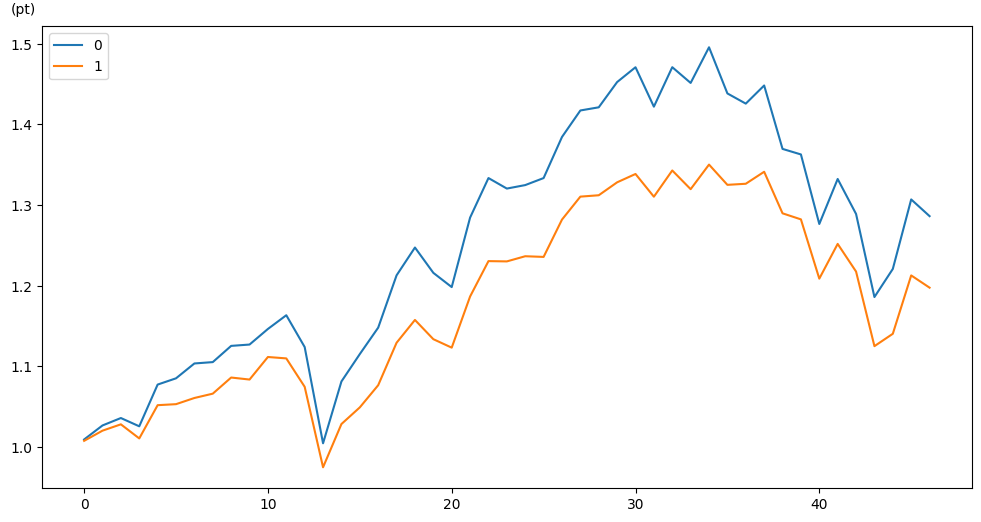

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

In [ ]:
abs(pfweight[1:] - np.roll(pfweight,shift=1,axis=0)[1:]).sum(axis=1).mean()

0.18328004

In [ ]:
np.round(grid_search.predict(X_last_ae)*100,4)

In [ ]:
seed = 1234
tf.random.set_seed(seed)

variables = X_train.columns.to_list()
n_tickers = len(symbols)
n_features = len(variables)
n_factors = 4

# input layer
input_feature = Input(shape=(n_tickers,n_features))
input_target = Input((n_tickers,))

# factor network
h = Dense(16, kernel_regularizer=L1(0.01))(input_feature)
h = BatchNormalization()(h)
h = ReLU()(h)
#h = Dense(16, kernel_regularizer=L1(0.01))(h)
#h = BatchNormalization()(h)
#h = ReLU()(h)
output_feature = Dense(n_factors)(h)
# target network
output_target = Dense(n_factors)(input_target)
# output layer
output = Dot(axes=(2,1))([output_feature, output_target])
# define model
autoencoder = Model(inputs=[input_feature, input_target], outputs=output)
feature_encoder = Model(inputs=input_feature, outputs=output_feature)
target_encoder = Model(inputs=input_target, outputs=output_target)
# optimizer
optimizer = Adam(learning_rate=0.01)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7, 31)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 7, 16)                512       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 7, 16)                64        ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 7, 16)                0         ['batch_normalization[0][0

In [ ]:
cb = EarlyStopping(patience=50, restore_best_weights=True)

X1_train = X_train.values.reshape(-1,n_tickers,n_features)
X2_train = y_train.values.reshape(-1,n_tickers)

X1_test = X_test.values.reshape(-1,n_tickers,n_features)
X2_test = y_test.values.reshape(-1,n_tickers)

autoencoder.compile(optimizer=optimizer, loss='mse')
history = autoencoder.fit([X1_train, X2_train], X2_train, epochs=500, batch_size=10000, verbose=2,
                          validation_data=([X1_test,X2_test],X2_test), callbacks=[cb])

In [ ]:
train_encoded = feature_encoder.predict(X1_train)
test_encoded = feature_encoder.predict(X1_test)
last_encoded = feature_encoder.predict(X_last.values.reshape(-1,n_tickers,n_features))

train0, train1 = train_encoded.shape[0], train_encoded.shape[1]
test0, test1 = test_encoded.shape[0], test_encoded.shape[1]
last0, last1 = last_encoded.shape[0], last_encoded.shape[1]

X_train_ae = train_encoded.reshape(train0*train1,-1)
X_test_ae = test_encoded.reshape(test0*test1,-1)
X_last_ae = last_encoded.reshape(last0*last1,-1)

#target_encoded = target_encoder.predict(X2_train)
#F = feature_encoded[-1]
#T = target_encoded.mean(axis=0)
#np.dot(F,T)

1/1 [==============================] - 0s 19ms/step


In [ ]:
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('regressor', LinearRegression())
])

param_grid = {
    'scaler': ['passthrough'], #StandardScaler()]
}

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring={'OOSR2': make_scorer(OOSR2)},
    refit='OOSR2',
    cv=ts_cv(X_train, n_test = 3),
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train_ae, y_train.values)

GridSearchCV(cv=<generator object ts_cv at 0x7c102e030f20>, error_score='raise',
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={'scaler': ['passthrough']}, refit='OOSR2',
             scoring={'OOSR2': make_scorer(OOSR2)})

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,params,split0_test_OOSR2,split1_test_OOSR2,split2_test_OOSR2,mean_test_OOSR2,std_test_OOSR2,rank_test_OOSR2
0,0.001954,0.00024,0.00022,0.000024,passthrough,{'scaler': 'passthrough'},0.049354,0.05442,-0.047827,0.018649,0.047051,1


In [ ]:
OOSR2(y_test.values, grid_search.predict(X_test_ae))

0.03020165287797838

In [ ]:
best = grid_search.best_estimator_
best.named_steps["regressor"].intercept_

0.32876348

In [ ]:
best.named_steps["regressor"].coef_

array([-0.05592518, -0.68086565,  2.5070105 ,  0.54035026], dtype=float32)

In [ ]:
np.round(grid_search.predict(X_last_ae)*100,4)

array([-0.0022,  0.8899,  1.9009, -1.2896, -0.6139,  0.5032, -0.5995],
      dtype=float32)

In [ ]:
riskaversion = 4.5
minwgt = 0
maxwgt = 1

oosexpret = grid_search.predict(X_test_ae).reshape(-1,n_assets) # T+1
dfpass = data.copy()
pass_sort(df=dfpass)
dfpass_ = dfpass[:-n_assets]
oosvol = dfpass_.loc['2019-01-31':]['VOL2Y'].values.reshape(-1,n_assets) # T
oosvol = oosvol*np.sqrt(21)

pfweight = ((1/riskaversion)*(oosexpret/oosvol).clip(minwgt,maxwgt))
#pfweight = (oosexpret).clip(minwgt,maxwgt)
pfweight = pfweight / pfweight.sum(axis=1).reshape(-1,1) # T+1

oosret = dfpass_.loc['2019-01-31':]['RETURN_T+1'].values.reshape(-1,n_assets) # T+1
pfret = (pfweight * oosret).sum(axis=1)
bmret = (oosret / n_assets).sum(axis=1)

In [ ]:
CER(pfret, bmret, riskaversion)

0.03557883227140969

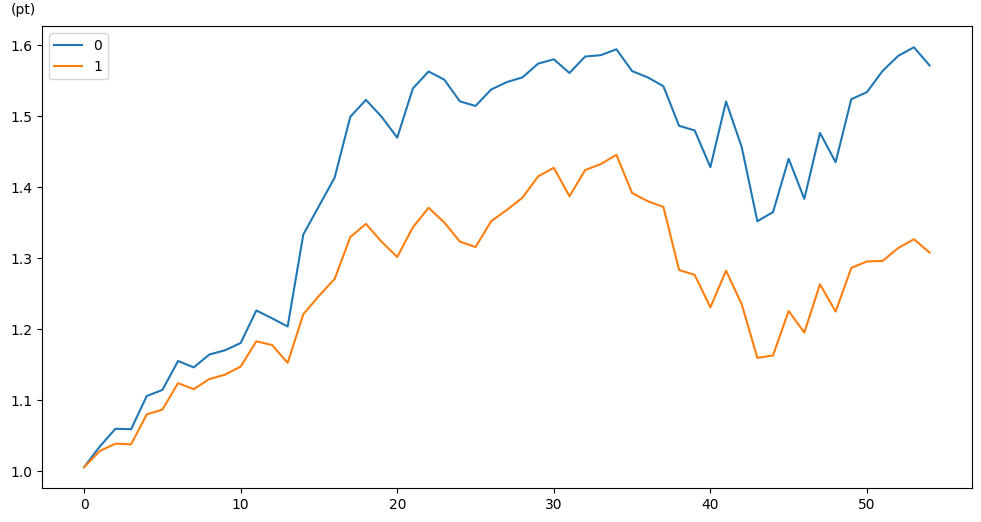

In [ ]:
indexes = pd.DataFrame([np.cumprod(1+pfret),np.cumprod(1+bmret)]).T
ts_plot(indexes)

In [ ]:
abs(pfweight[1:] - np.roll(pfweight,shift=1,axis=0)[1:]).sum(axis=1).mean()

0.28034416379409977